# Neural network for h->aa->bbtautau signal/background separation

# Model definition and training

## Packages

In [1]:
import ROOT
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Activation, Dense, Dropout
from keras.initializers import glorot_uniform
from keras.utils import plot_model

import kerastuner
from kerastuner import Hyperband

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

Welcome to JupyROOT 6.22/06


Using TensorFlow backend.


## Load root files

In [2]:
file_obs = ROOT.RDataFrame('etau_tree', 'root_raw/et18_raw/data_obs.root')
file_sig = ROOT.RDataFrame('etau_tree', {'root_raw/et18_raw/ggH_bbtt*.root', 'root_raw/et18_raw/vbf_bbtt*.root'})
file_ZTT = ROOT.RDataFrame('etau_tree', 'root_raw/et18_raw/embedded.root')
file_TT = ROOT.RDataFrame('etau_tree', 'root_raw/et18_raw/TT*.root')

files = [file_obs, file_sig, file_ZTT, file_TT]

In [3]:
# 2b events
for i in range(len(files)):
    files[i] = files[i].Filter('bpt_deepcsv_1>20 && bscore_deepcsv_1>0.4184')\
    .Filter('bpt_deepcsv_2>20 && bscore_deepcsv_2>0.4184')

## Define some input features

In [4]:
# define 4-vectors, invariant masses and etc.
myele = 'ROOT::Math::PtEtaPhiMVector(pt_1,eta_1,phi_1,m_1)'
mytau = 'ROOT::Math::PtEtaPhiMVector(pt_2,eta_2,phi_2,m_2)'
mymet = 'ROOT::Math::PtEtaPhiMVector(met,0,metphi,0)'
mytt = 'ROOT::Math::PtEtaPhiMVector((myele+mytau+mymet).Pt(),(myele+mytau+mymet).Eta(),(myele+mytau+mymet).Phi(),m_sv)'
myb1 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepcsv_1,beta_deepcsv_1,bphi_deepcsv_1,bm_deepcsv_1)'
myb2 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepcsv_2,beta_deepcsv_2,bphi_deepcsv_2,bm_deepcsv_2)'
m_b1tt = '(mytt+myb1).M()'
m_b2tt = '(mytt+myb2).M()'
m_bbtt = '(mytt+myb1+myb2).M()'
m_bb = '(myb1+myb2).M()'
m_b1e = '(myele+myb1).M()'
m_b1tau = '(mytau+myb1).M()'
m_b2e = '(myele+myb2).M()'
m_b2tau = '(mytau+myb2).M()'
m_bbe = '(myb1+myb2+myele).M()'
m_bbtau = '(myb1+myb2+mytau).M()'
dm_a = '(m_bb-m_sv)/m_sv'
dR_tt = 'ROOT::Math::VectorUtil::DeltaR(myele,mytau)'
dR_b1e = 'ROOT::Math::VectorUtil::DeltaR(myele,myb1)'
dR_b1tau = 'ROOT::Math::VectorUtil::DeltaR(mytau,myb1)'
dR_b2e = 'ROOT::Math::VectorUtil::DeltaR(myele,myb2)'
dR_b2tau = 'ROOT::Math::VectorUtil::DeltaR(mytau,myb2)'
dR_bb = 'ROOT::Math::VectorUtil::DeltaR(myb1,myb2)'
dR_b1tt = 'ROOT::Math::VectorUtil::DeltaR(myb1,mytt)'
dR_b2tt = 'ROOT::Math::VectorUtil::DeltaR(myb2,mytt)'
dR_bbe = 'ROOT::Math::VectorUtil::DeltaR(myb1+myb2,myele)'
dR_bbtau = 'ROOT::Math::VectorUtil::DeltaR(myb1+myb2,mytau)'
dR_aa = 'ROOT::Math::VectorUtil::DeltaR(mytt,myb1+myb2)'
tt_pt = 'mytt.Pt()'
tt_eta = 'mytt.Eta()'


# define transverse masses mT and D_zeta
mT_e = 'sqrt(pow(myele.Pt()+mymet.Pt(),2)-pow(myele.Px()+mymet.Px(),2)-pow(myele.Py()+mymet.Py(),2))'
mT_tau = 'sqrt(pow(mytau.Pt()+mymet.Pt(),2)-pow(mytau.Px()+mymet.Px(),2)-pow(mytau.Py()+mymet.Py(),2))'
mT_b1 = 'sqrt(pow(myb1.Pt()+mymet.Pt(),2)-pow(myb1.Px()+mymet.Px(),2)-pow(myb1.Py()+mymet.Py(),2))'
mT_b2 = 'sqrt(pow(myb2.Pt()+mymet.Pt(),2)-pow(myb2.Px()+mymet.Px(),2)-pow(myb2.Py()+mymet.Py(),2))'
mT_tt = 'sqrt(pow(mytt.Pt()+mymet.Pt(),2)-pow(mytt.Px()+mymet.Px(),2)-pow(mytt.Py()+mymet.Py(),2))'
norm_zeta = 'sqrt(pow(myele.Px()/myele.Pt()+mytau.Px()/mytau.Pt(),2)+pow(myele.Py()/myele.Pt()+mytau.Py()/mytau.Pt(),2))'
x_zeta = '(myele.Px()/myele.Pt()+mytau.Px()/mytau.Pt())/norm_zeta'
y_zeta = '(myele.Py()/myele.Pt()+mytau.Py()/mytau.Pt())/norm_zeta'
p_zeta_mis = 'mymet.Px()*x_zeta+mymet.Py()*y_zeta'
pzeta_vis = '(myele.Px()+mytau.Px())*x_zeta+(myele.Py()+mytau.Py())*y_zeta'
Dzeta = 'p_zeta_mis-0.85*pzeta_vis'


# add defined variables to dataframe
for i in range(len(files)):
    files[i] = files[i].Define('myele', myele)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1e', m_b1e)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2e', m_b2e)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbe', m_bbe)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1e', dR_b1e)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2e', dR_b2e)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbe', dR_bbe)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_e', mT_e)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('mT_tt', mT_tt)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Apply baseline selection cuts

In [5]:
# 2018 e+tau trigger requirements
trigger32 = '(passEle32 && pt_1>33 && matchEle32_1 && filterEle32_1)'
trigger35 = '(passEle35 && pt_1>33 && matchEle35_1 && filterEle35_1)'
trigger2430 = '(passEle24Tau30 && matchEle24Tau30_1 && filterEle24Tau30_1 && matchEle24Tau30_2 && filterEle24Tau30_2 && pt_1>25 && pt_2>35 && fabs(eta_2)<2.1 && pt_1<=33)'
trigger2430HPS = '(passEle24HPSTau30 && matchEle24HPSTau30_1 && filterEle24HPSTau30_1 && matchEle24HPSTau30_2 && filterEle24HPSTau30_2 && pt_1>25 && pt_2>35 && fabs(eta_2)<2.1 && pt_1<=33)'
trigger2430HPS_emb = '(matchEmbFilter_Ele24Tau30_1 && matchEmbFilter_Ele24Tau30_2 && pt_1>25 && pt_2>35 && fabs(eta_2)<2.1 && pt_1<=33)'

trigger_mc = trigger32 + str(' or ') + trigger35 + str(' or ') + trigger2430HPS
trigger_emb = trigger32 + str(' or ') + trigger35 + str(' or ') + trigger2430HPS_emb
trigger_obs_1 = trigger32 + str(' or ') + trigger35 + str(' or ') + trigger2430
trigger_obs_2 = trigger32 + str(' or ') + trigger35 + str(' or ') + trigger2430HPS


for i in range(len(files)):
    files[i] = files[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byTightDeepVSe_2 && byVLooseDeepVSmu_2')\
    .Filter('dR_tt>0.4')

files[0] = files[0].Filter('Flag_eeBadScFilter==0')
files[2] = files[2].Filter('Flag_eeBadScFilter==0')

files[3] = files[3].Filter('gen_match_2!=6').Filter('(gen_match_1<3 or gen_match_1==6) && gen_match_2<3')

files[1] = files[1].Filter('gen_match_1==3 && gen_match_2==5')#recontructed taus are gen taus
files[1] = files[1].Filter('m_b1tt<250')#reject long tail (mostly wrongly reco b jet)

#####for 2b only, remove long tails to reject wrongly reco b jet
files[1] = files[1].Filter('m_bbtt<400').Filter('m_bb<150').Filter('dm_a<2.0')

files[2] = files[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
obs1 = files[0].Filter('run<317509').Filter(trigger_obs_1)
obs2 = files[0].Filter('run>=317509').Filter(trigger_obs_2)
files[1] = files[1].Filter(trigger_mc)
files[2] = files[2].Filter(trigger_emb)
files[3] = files[3].Filter(trigger_mc)

# QCD region
qcd1 = obs1.Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')
qcd2 = obs2.Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files)):
    files[i] = files[i].Filter('q_1*q_2<0')\
    .Filter('byLooseDeepVSjet_2')

# [0]=obs, [1]=sig, [2]=embedded, [3]=ttbar

## Select all input features and save into pandas DataFrame

In [6]:
# list of feature variables
###### for 2b events
feature_list = ['pt_1', 'pt_2', 'm_b1tt', 'm_b2tt', 'm_bbtt', 'm_bb', 'm_b1e', 'm_b1tau', 'm_b2e', 'm_b2tau', 'dm_a',\
                'm_b1tt', 'm_b2tt', 'm_bbe', 'm_bbtau', 'dR_tt', 'dR_b1e', 'dR_b1tau', 'dR_b2e', 'dR_b2tau', 'dR_bb', 'dR_b1tt', 'dR_b2tt', 'dR_aa',\
                'dR_bbe','dR_bbtau', 'tt_pt', 'tt_eta', 'mT_e', 'mT_tau', 'mT_b1', 'mT_b2', 'mT_tt', 'norm_zeta', 'Dzeta',\
                'bpt_deepcsv_1', 'bpt_deepcsv_2', 'met', 'njets']

# convert root RDataFrame into pandas DataFrame, saving only the features as columns
for i in range(1,len(files)):
    files[i] = pd.DataFrame(files[i].AsNumpy(feature_list))
    print(i)
qcd1 = pd.DataFrame(qcd1.AsNumpy(feature_list))
print('qcd1')
qcd2 = pd.DataFrame(qcd2.AsNumpy(feature_list))
print('qcd2')
qcd = [qcd1, qcd2]
qcd = pd.concat(qcd)
print('qcd')

# tag MC signal events as class 1
files[1]['label'] = np.ones((files[1].shape[0], 1))

# tag MC background events as class 0
files[2]['label'] = np.zeros((files[2].shape[0], 1))
files[3]['label'] = np.zeros((files[3].shape[0], 1))
qcd['label'] = np.zeros((qcd.shape[0],1))

for i in range(1,len(files)):
    print(str(files[i].shape))
print(str(qcd.shape))

1
2
3
qcd1
qcd2
qcd
(1448, 38)
(12868, 38)
(738, 38)
(29280, 38)


## Split into MC/data

In [7]:
# reduce class 0 sample size for balanced training
files[2] = files[2].sample(n = 200, random_state = 20)#Z->tautau
files[3] = files[3].sample(n = 738, random_state = 20)#ttbar
qcd = qcd.sample(n = 510, random_state = 20)


# collect all MC as one dataframe, separated from another datafream for observed data
#df_obs = files[0]
df_MC = [files[1], files[2], files[3], qcd]

df_MC = pd.concat(df_MC)


#print('\nObserved dataframe: \n' + str(df_obs))
print('\nMC dataframe: \n' + str(df_MC))


MC dataframe: 
             pt_1       pt_2      m_b1tt      m_b2tt      m_bbtt        m_bb  \
0       35.527386  27.783640   81.428417   90.568541  121.758682   25.198803   
1       39.419514  27.334774   68.185363  105.386576  125.656761   26.219307   
2       35.017666  49.017509  103.673462   86.115231  140.385348   48.015865   
3       45.480015  30.076338   71.642926  184.829852  203.912696   53.253670   
4       45.410255  26.585423   68.906812   91.728588  114.175839   23.557440   
...           ...        ...         ...         ...         ...         ...   
8543    87.047035  23.307360  177.598511  164.208023  256.986689   98.791044   
7226   190.948700  61.340038  407.105236  503.336337  531.534641   86.543585   
17942   87.062111  42.252907  252.370042  301.584448  391.774110   32.481825   
1703    64.644386  23.925884  202.880809  286.778675  411.063882  256.919884   
5083    72.168007  80.563034  236.552515  182.091710  334.427067  159.116180   

            m_b1e     m

## Compare input feature distributions between sig and bkg

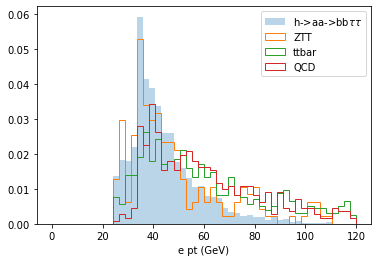

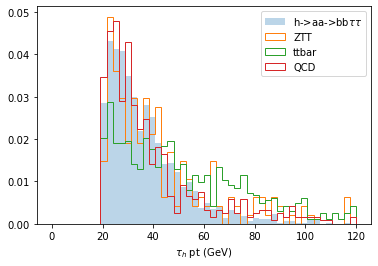

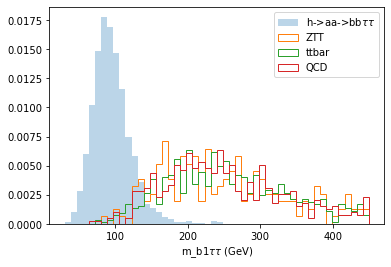

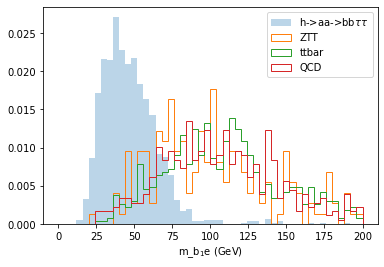

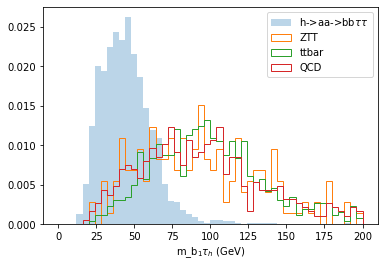

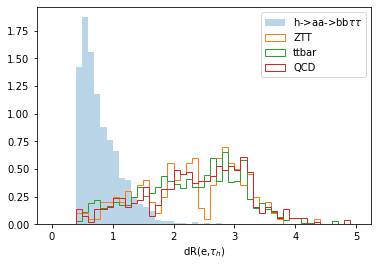

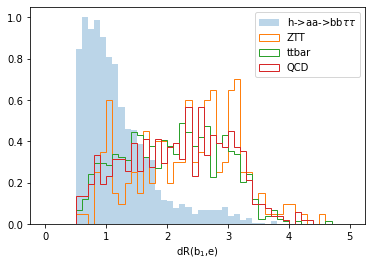

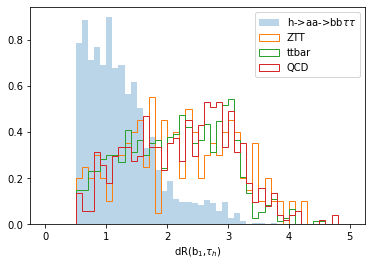

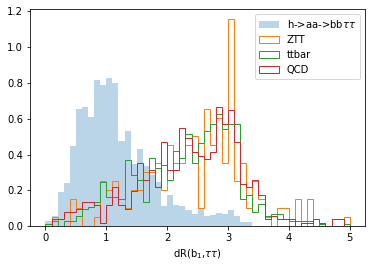

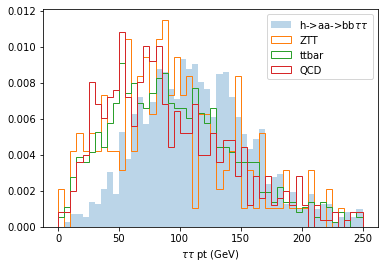

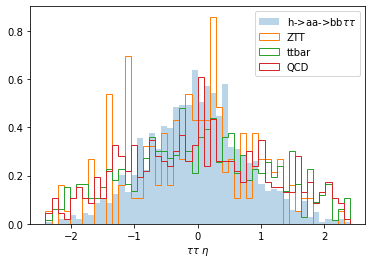

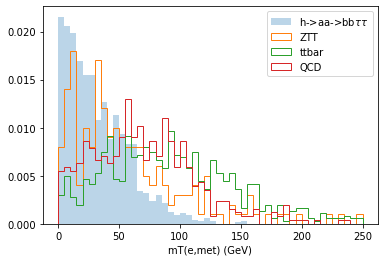

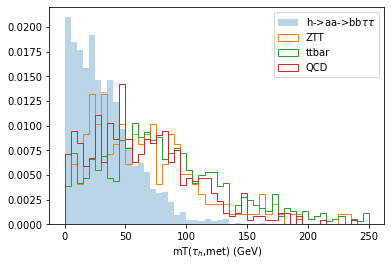

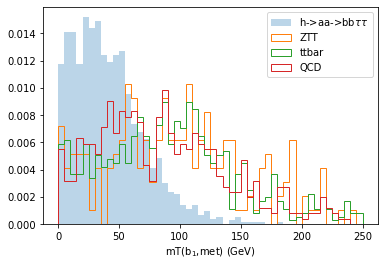

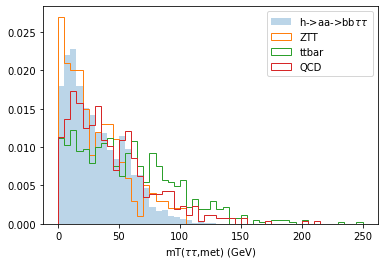

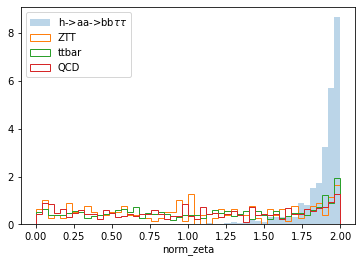

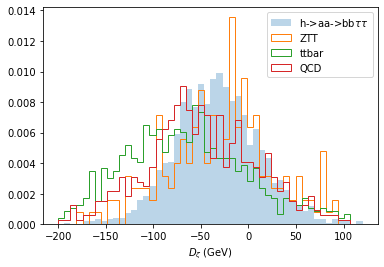

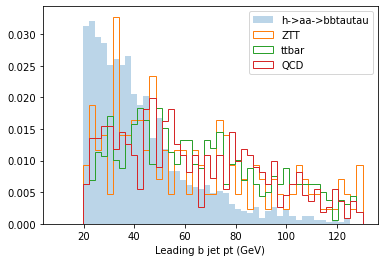

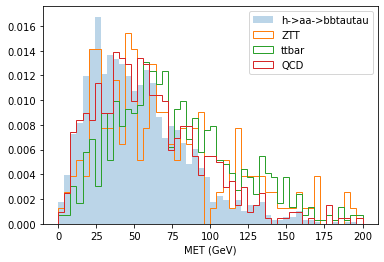

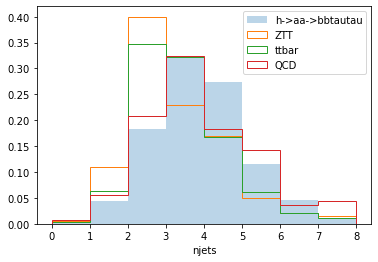

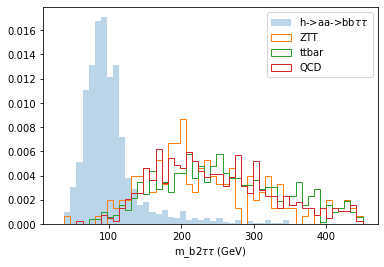

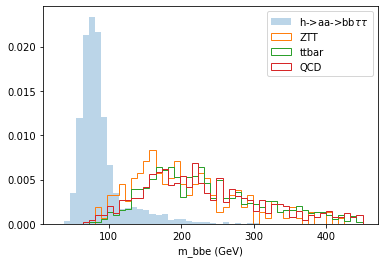

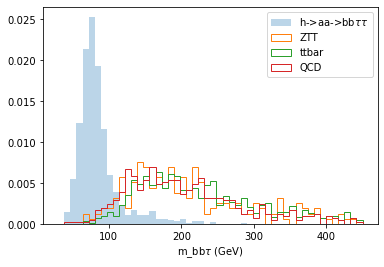

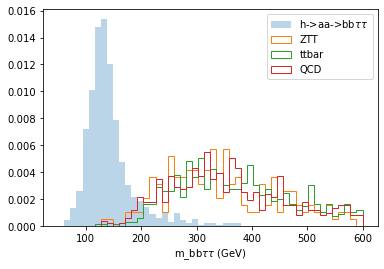

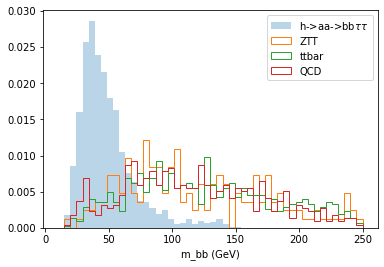

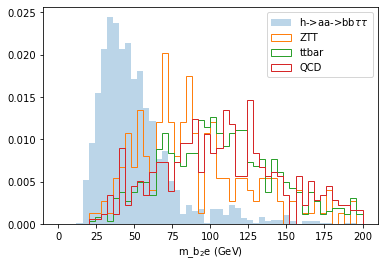

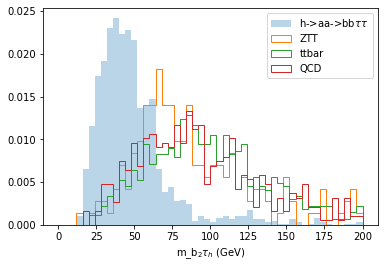

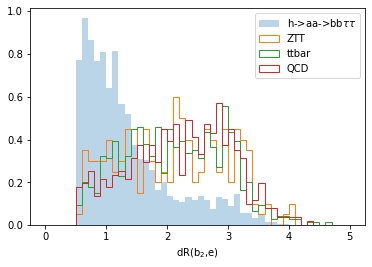

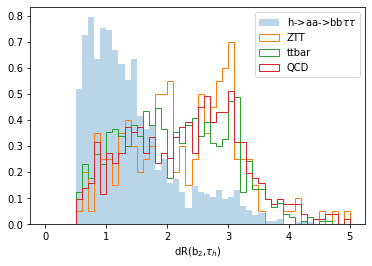

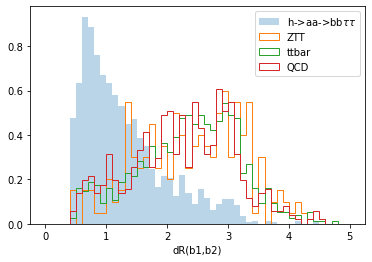

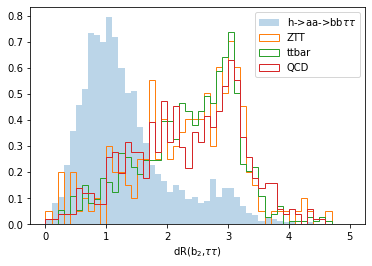

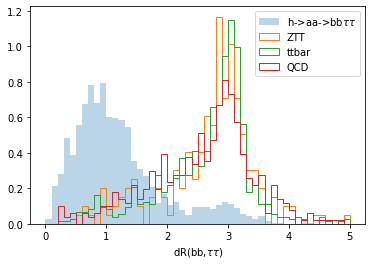

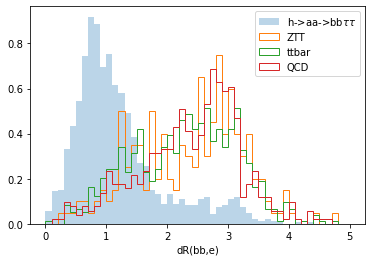

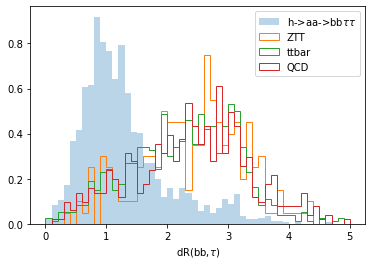

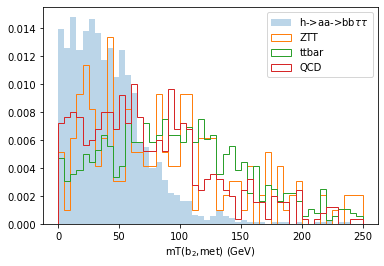

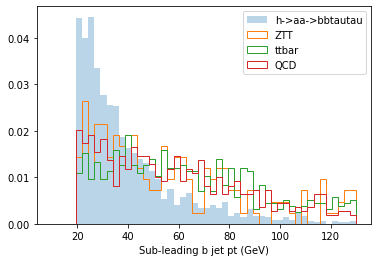

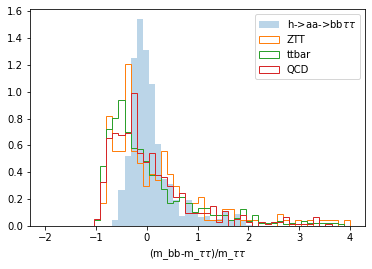

In [8]:
pyplot.hist(files[1]['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('e pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau_h$ pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_b1tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_b1tt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_b1tt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_b1tt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b1$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_b1e'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_b1e'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_b1e'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_b1e'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$e (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$$\\tau_h$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(e,$\\tau_h$)')
pyplot.show()

pyplot.hist(files[1]['dR_b1e'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_b1e'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_b1e'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_b1e'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,e)')
pyplot.show()

pyplot.hist(files[1]['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau_h$)')
pyplot.show()

pyplot.hist(files[1]['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau\\tau$)')
pyplot.show()


pyplot.hist(files[1]['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ $\eta$')
pyplot.show()


pyplot.hist(files[1]['mT_e'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['mT_e'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_e'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['mT_e'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(e,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\\tau_h$,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(b$_1$,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['mT_tt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['mT_tt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_tt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['mT_tt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\\tau\\tau$,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['norm_zeta'], density = 1, range = (0,2.), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['norm_zeta'], density = 1, range = (0,2.), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['norm_zeta'], density = 1, range = (0,2.), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['norm_zeta'], density = 1, range = (0,2.), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'best')
pyplot.xlabel('norm_zeta')
pyplot.show()

pyplot.hist(files[1]['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$D_\zeta$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Leading b jet pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['met'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['met'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['met'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['met'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('MET (GeV)')
pyplot.show()

pyplot.hist(files[1]['njets'], density = 1, range = (0,8), bins = 8, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('njets')
pyplot.show()


############## for 2b events
pyplot.hist(files[1]['m_b2tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_b2tt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_b2tt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_b2tt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b2$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_bbe'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_bbe'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_bbe'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_bbe'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bbe (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_bbtau'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_bbtau'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_bbtau'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_bbtau'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb$\\tau$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_bbtt'], density = 1, range = (50,600), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_bbtt'], density = 1, range = (50,600), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_bbtt'], density = 1, range = (50,600), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_bbtt'], density = 1, range = (50,600), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_bb'], density = 1, range = (10,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_bb'], density = 1, range = (10,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_bb'], density = 1, range = (10,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_bb'], density = 1, range = (10,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_b2e'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_b2e'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_b2e'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_b2e'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_2$e (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_b2tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_b2tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_b2tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_b2tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_2$$\\tau_h$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['dR_b2e'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_b2e'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_b2e'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_b2e'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_2$,e)')
pyplot.show()

pyplot.hist(files[1]['dR_b2tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_b2tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_b2tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_b2tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_2$,$\\tau_h$)')
pyplot.show()

pyplot.hist(files[1]['dR_bb'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_bb'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_bb'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_bb'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b1,b2)')
pyplot.show()

pyplot.hist(files[1]['dR_b2tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_b2tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_b2tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_b2tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_2$,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(files[1]['dR_aa'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_aa'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_aa'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_aa'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(bb,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(files[1]['dR_bbe'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_bbe'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_bbe'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_bbe'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(bb,e)')
pyplot.show()

pyplot.hist(files[1]['dR_bbtau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_bbtau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_bbtau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_bbtau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(bb,$\\tau$)')
pyplot.show()

pyplot.hist(files[1]['mT_b2'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['mT_b2'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_b2'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['mT_b2'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(b$_2$,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['bpt_deepcsv_2'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['bpt_deepcsv_2'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['bpt_deepcsv_2'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['bpt_deepcsv_2'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Sub-leading b jet pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['dm_a'], density = 1, range = (-2,4), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dm_a'], density = 1, range = (-2,4), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dm_a'], density = 1, range = (-2,4), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dm_a'], density = 1, range = (-2,4), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('(m_bb-m_$\\tau\\tau$)/m_$\\tau\\tau$')
pyplot.show()


## Input data pre-processing

In [9]:
# convert to numpy arrays
dataset = df_MC.values
X = dataset[:,0:(dataset.shape[1]-1)]
Y = dataset[:,dataset.shape[1]-1]
Y = Y.reshape(Y.shape[0],1)

#dataset_obs = df_obs.values
#X_obs = dataset_obs[:,0:(dataset_obs.shape[1])]


# give train/val/test partition ratios
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 1 - train_ratio - val_ratio

# randomly partition data set into train/val/test sets with given ratios
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = test_ratio, random_state=15)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio+train_ratio), random_state=15)

# standardize feature variables
# only based on means and stds in train_val set, should apply this only scaler to all other sets
# think of the transformation in phase space
scaler = StandardScaler().fit(X_train_val)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
#X_obs = scaler.transform(X_obs)


# print input data shapes
print("\nPartition the data set into train/val/test: %.2f/%.2f/%.2f" % (train_ratio, val_ratio, test_ratio))
print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("Y_val.shape: " + str(Y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))
#print("\nX_obs.shape: " + str(X_obs.shape))

# print ratio of signal/background examples in each set
train_sig = np.count_nonzero(Y_train)
train_bkg = np.count_nonzero(Y_train == 0)
train_sig_perc = 100*train_sig/(train_sig+train_bkg)
train_bkg_perc = 100*train_bkg/(train_sig+train_bkg)
val_sig = np.count_nonzero(Y_val)
val_bkg = np.count_nonzero(Y_val == 0)
val_sig_perc = 100*val_sig/(val_sig+val_bkg)
val_bkg_perc = 100*val_bkg/(val_sig+val_bkg)
test_sig = np.count_nonzero(Y_test)
test_bkg = np.count_nonzero(Y_test == 0)
test_sig_perc = 100*test_sig/(test_sig+test_bkg)
test_bkg_perc = 100*test_bkg/(test_sig+test_bkg)

total_sig = train_sig + val_sig + test_sig
total_bkg = train_bkg + val_bkg + test_bkg
total_sig_perc = 100*total_sig/(total_sig+total_bkg)
total_bkg_perc = 100*total_bkg/(total_sig+total_bkg)
print("\nTotal number of sig/bkg examples: %d/%d (%.2f%%/%.2f%%)" % (total_sig, total_bkg, total_sig_perc, total_bkg_perc))

print("\nNumber of sig/bkg examples in each set:")
print("train : %d/%d (%.1f%%/%.1f%%)" % (train_sig, train_bkg, train_sig_perc, train_bkg_perc))
print("val   : %d/%d (%.1f%%/%.1f%%)" % (val_sig, val_bkg, val_sig_perc, val_bkg_perc))
print("test  : %d/%d (%.1f%%/%.1f%%)" % (test_sig, test_bkg, test_sig_perc, test_bkg_perc))


Partition the data set into train/val/test: 0.60/0.20/0.20
X_train.shape: (1737, 37)
Y_train.shape: (1737, 1)
X_val.shape: (579, 37)
Y_val.shape: (579, 1)
X_test.shape: (580, 37)
Y_test.shape: (580, 1)

Total number of sig/bkg examples: 1448/1448 (50.00%/50.00%)

Number of sig/bkg examples in each set:
train : 863/874 (49.7%/50.3%)
val   : 296/283 (51.1%/48.9%)
test  : 289/291 (49.8%/50.2%)


## DNN Hyperparameters searching

In [10]:
# define model for the search
def hypermodel(hp):
    hp_model = keras.Sequential()
    hp_model.add(keras.layers.Input(shape = (X.shape[1],)))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_1',
                                                   min_value = 40,
                                                   max_value = 100,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_1',
                                                      min_value = 0.3,
                                                      max_value = 0.5,
                                                      default = 0.3,
                                                      step = 0.1),
                                      seed = 10))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_2',
                                                   min_value = 40,
                                                   max_value = 100,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_2',
                                                      min_value = 0.3,
                                                      max_value = 0.5,
                                                      default = 0.3,
                                                      step = 0.1),
                                      seed = 10))

    hp_model.add(keras.layers.Dense(units = 1, activation = 'sigmoid', kernel_initializer = glorot_uniform(seed=1)))
    hp_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return hp_model

In [11]:
# define tuner model
tuner = Hyperband(hypermodel,
                  objective = 'val_accuracy',
                  max_epochs = 30,
                  factor = 3, #number of models to train in a bracket = 1+log_factor(max_epochs)
                  hyperband_iterations = 3, #number of times to iterate over the full Hyperband algorithm
                  seed = 10,
                  directory = 'hypertuning',
                  project_name = 'tune',
                  overwrite = True)

2021-02-15 16:40:21.441246: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-02-15 16:40:21.442199: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [12]:
# run the search
tuner.search(X_train, Y_train, epochs = 30, validation_data = (X_val,Y_val), batch_size = 128)

Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 9s - loss: 0.7540 - accuracy: 0.53 - ETA: 0s - loss: 0.6246 - accuracy: 0.66 - 1s 563us/sample - loss: 0.5405 - accuracy: 0.7358 - val_loss: 0.2941 - val_accuracy: 0.9326
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3449 - accuracy: 0.88 - ETA: 0s - loss: 0.2903 - accuracy: 0.90 - 0s 88us/sample - loss: 0.2588 - accuracy: 0.9194 - val_loss: 0.1735 - val_accuracy: 0.9447


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.9124 - accuracy: 0.46 - ETA: 0s - loss: 0.7455 - accuracy: 0.55 - 1s 436us/sample - loss: 0.6949 - accuracy: 0.6010 - val_loss: 0.4390 - val_accuracy: 0.9136
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.5502 - accuracy: 0.75 - ETA: 0s - loss: 0.4511 - accuracy: 0.80 - 0s 79us/sample - loss: 0.4282 - accuracy: 0.8227 - val_loss: 0.2602 - val_accuracy: 0.9482


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7907 - accuracy: 0.55 - ETA: 0s - loss: 0.5940 - accuracy: 0.67 - 1s 433us/sample - loss: 0.5236 - accuracy: 0.7323 - val_loss: 0.2766 - val_accuracy: 0.9465
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2664 - accuracy: 0.95 - ETA: 0s - loss: 0.2498 - accuracy: 0.93 - 0s 88us/sample - loss: 0.2318 - accuracy: 0.9401 - val_loss: 0.1595 - val_accuracy: 0.9551


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 1.0762 - accuracy: 0.41 - ETA: 0s - loss: 0.6919 - accuracy: 0.61 - 1s 442us/sample - loss: 0.5742 - accuracy: 0.7081 - val_loss: 0.2437 - val_accuracy: 0.9361
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2838 - accuracy: 0.90 - ETA: 0s - loss: 0.2325 - accuracy: 0.92 - 0s 95us/sample - loss: 0.2132 - accuracy: 0.9355 - val_loss: 0.1378 - val_accuracy: 0.9482


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7699 - accuracy: 0.55 - ETA: 0s - loss: 0.5547 - accuracy: 0.70 - 1s 472us/sample - loss: 0.4838 - accuracy: 0.7547 - val_loss: 0.2627 - val_accuracy: 0.9292
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2733 - accuracy: 0.90 - ETA: 0s - loss: 0.2460 - accuracy: 0.91 - 0s 83us/sample - loss: 0.2275 - accuracy: 0.9229 - val_loss: 0.1507 - val_accuracy: 0.9534


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.8037 - accuracy: 0.53 - ETA: 0s - loss: 0.6437 - accuracy: 0.64 - 1s 433us/sample - loss: 0.6029 - accuracy: 0.6822 - val_loss: 0.3315 - val_accuracy: 0.9413
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3772 - accuracy: 0.82 - ETA: 0s - loss: 0.3138 - accuracy: 0.88 - 0s 79us/sample - loss: 0.3008 - accuracy: 0.8952 - val_loss: 0.1877 - val_accuracy: 0.9482


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7801 - accuracy: 0.49 - ETA: 0s - loss: 0.6362 - accuracy: 0.65 - 1s 424us/sample - loss: 0.5646 - accuracy: 0.7070 - val_loss: 0.2743 - val_accuracy: 0.9206
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3209 - accuracy: 0.86 - ETA: 0s - loss: 0.2858 - accuracy: 0.89 - 0s 84us/sample - loss: 0.2595 - accuracy: 0.9056 - val_loss: 0.1618 - val_accuracy: 0.9413


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7857 - accuracy: 0.53 - ETA: 0s - loss: 0.5972 - accuracy: 0.72 - 1s 461us/sample - loss: 0.5152 - accuracy: 0.7835 - val_loss: 0.2785 - val_accuracy: 0.9378
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3105 - accuracy: 0.91 - ETA: 0s - loss: 0.2493 - accuracy: 0.92 - 0s 85us/sample - loss: 0.2298 - accuracy: 0.9361 - val_loss: 0.1554 - val_accuracy: 0.9499


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7761 - accuracy: 0.49 - ETA: 0s - loss: 0.5417 - accuracy: 0.69 - 1s 430us/sample - loss: 0.4829 - accuracy: 0.7582 - val_loss: 0.2651 - val_accuracy: 0.9430
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2836 - accuracy: 0.93 - ETA: 0s - loss: 0.2359 - accuracy: 0.95 - 0s 83us/sample - loss: 0.2167 - accuracy: 0.9511 - val_loss: 0.1406 - val_accuracy: 0.9551


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7940 - accuracy: 0.40 - ETA: 0s - loss: 0.5904 - accuracy: 0.70 - 1s 457us/sample - loss: 0.5045 - accuracy: 0.7720 - val_loss: 0.2567 - val_accuracy: 0.9447
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3052 - accuracy: 0.90 - ETA: 0s - loss: 0.2240 - accuracy: 0.94 - 0s 87us/sample - loss: 0.2055 - accuracy: 0.9493 - val_loss: 0.1316 - val_accuracy: 0.9568


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7144 - accuracy: 0.58 - ETA: 0s - loss: 0.5225 - accuracy: 0.77 - 1s 434us/sample - loss: 0.4557 - accuracy: 0.8273 - val_loss: 0.2597 - val_accuracy: 0.9344
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2732 - accuracy: 0.93 - ETA: 0s - loss: 0.2336 - accuracy: 0.93 - 0s 86us/sample - loss: 0.2137 - accuracy: 0.9407 - val_loss: 0.1446 - val_accuracy: 0.9447


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7092 - accuracy: 0.47 - ETA: 0s - loss: 0.5038 - accuracy: 0.77 - 1s 437us/sample - loss: 0.4066 - accuracy: 0.8382 - val_loss: 0.1943 - val_accuracy: 0.9482
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2011 - accuracy: 0.94 - ETA: 0s - loss: 0.1868 - accuracy: 0.94 - 0s 92us/sample - loss: 0.1615 - accuracy: 0.9505 - val_loss: 0.1139 - val_accuracy: 0.9603


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.6495 - accuracy: 0.63 - ETA: 0s - loss: 0.4800 - accuracy: 0.78 - 1s 428us/sample - loss: 0.4388 - accuracy: 0.8152 - val_loss: 0.2417 - val_accuracy: 0.9465
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2672 - accuracy: 0.94 - ETA: 0s - loss: 0.2247 - accuracy: 0.94 - 0s 84us/sample - loss: 0.2080 - accuracy: 0.9442 - val_loss: 0.1432 - val_accuracy: 0.9534


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.8740 - accuracy: 0.39 - ETA: 0s - loss: 0.6568 - accuracy: 0.59 - 1s 431us/sample - loss: 0.5741 - accuracy: 0.6868 - val_loss: 0.3097 - val_accuracy: 0.9430
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3178 - accuracy: 0.91 - ETA: 0s - loss: 0.2690 - accuracy: 0.93 - 0s 88us/sample - loss: 0.2481 - accuracy: 0.9378 - val_loss: 0.1544 - val_accuracy: 0.9516


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.8983 - accuracy: 0.31 - ETA: 0s - loss: 0.7208 - accuracy: 0.50 - 1s 418us/sample - loss: 0.6723 - accuracy: 0.5619 - val_loss: 0.4574 - val_accuracy: 0.8946
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.4686 - accuracy: 0.84 - ETA: 0s - loss: 0.3937 - accuracy: 0.87 - 0s 79us/sample - loss: 0.3717 - accuracy: 0.8854 - val_loss: 0.2598 - val_accuracy: 0.9413


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7592 - accuracy: 0.51 - ETA: 0s - loss: 0.5494 - accuracy: 0.71 - 1s 427us/sample - loss: 0.4890 - accuracy: 0.7720 - val_loss: 0.2784 - val_accuracy: 0.9344
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3182 - accuracy: 0.87 - ETA: 0s - loss: 0.2658 - accuracy: 0.91 - 0s 82us/sample - loss: 0.2454 - accuracy: 0.9211 - val_loss: 0.1552 - val_accuracy: 0.9447


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7443 - accuracy: 0.58 - ETA: 0s - loss: 0.5177 - accuracy: 0.76 - 1s 429us/sample - loss: 0.4484 - accuracy: 0.8025 - val_loss: 0.2106 - val_accuracy: 0.9465
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2754 - accuracy: 0.89 - ETA: 0s - loss: 0.2368 - accuracy: 0.92 - 0s 89us/sample - loss: 0.2129 - accuracy: 0.9332 - val_loss: 0.1276 - val_accuracy: 0.9568


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7784 - accuracy: 0.50 - ETA: 0s - loss: 0.6016 - accuracy: 0.69 - 1s 427us/sample - loss: 0.5399 - accuracy: 0.7513 - val_loss: 0.2743 - val_accuracy: 0.9603
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3114 - accuracy: 0.93 - ETA: 0s - loss: 0.2411 - accuracy: 0.93 - 0s 83us/sample - loss: 0.2224 - accuracy: 0.9424 - val_loss: 0.1436 - val_accuracy: 0.9655


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.6552 - accuracy: 0.64 - ETA: 0s - loss: 0.4743 - accuracy: 0.80 - 1s 430us/sample - loss: 0.4168 - accuracy: 0.8469 - val_loss: 0.2451 - val_accuracy: 0.9465
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2844 - accuracy: 0.90 - ETA: 0s - loss: 0.2178 - accuracy: 0.94 - 0s 83us/sample - loss: 0.2116 - accuracy: 0.9447 - val_loss: 0.1486 - val_accuracy: 0.9568


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.6692 - accuracy: 0.59 - ETA: 0s - loss: 0.4940 - accuracy: 0.78 - 1s 427us/sample - loss: 0.4202 - accuracy: 0.8348 - val_loss: 0.2311 - val_accuracy: 0.9430
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2451 - accuracy: 0.94 - ETA: 0s - loss: 0.1930 - accuracy: 0.94 - 0s 86us/sample - loss: 0.1745 - accuracy: 0.9493 - val_loss: 0.1241 - val_accuracy: 0.9585


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7544 - accuracy: 0.53 - ETA: 0s - loss: 0.6192 - accuracy: 0.67 - 1s 437us/sample - loss: 0.5663 - accuracy: 0.7185 - val_loss: 0.3451 - val_accuracy: 0.9257
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.4004 - accuracy: 0.86 - ETA: 0s - loss: 0.3379 - accuracy: 0.88 - 0s 84us/sample - loss: 0.3186 - accuracy: 0.8964 - val_loss: 0.2052 - val_accuracy: 0.9430


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.6990 - accuracy: 0.52 - ETA: 0s - loss: 0.5792 - accuracy: 0.68 - 1s 429us/sample - loss: 0.5115 - accuracy: 0.7530 - val_loss: 0.2931 - val_accuracy: 0.9396
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3556 - accuracy: 0.86 - ETA: 0s - loss: 0.2754 - accuracy: 0.91 - 0s 83us/sample - loss: 0.2615 - accuracy: 0.9182 - val_loss: 0.1753 - val_accuracy: 0.9430


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.9251 - accuracy: 0.51 - ETA: 0s - loss: 0.7549 - accuracy: 0.59 - 1s 425us/sample - loss: 0.7026 - accuracy: 0.6310 - val_loss: 0.3923 - val_accuracy: 0.9275
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.4544 - accuracy: 0.81 - ETA: 0s - loss: 0.3602 - accuracy: 0.88 - 0s 79us/sample - loss: 0.3446 - accuracy: 0.8958 - val_loss: 0.2211 - val_accuracy: 0.9430


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.8065 - accuracy: 0.52 - ETA: 0s - loss: 0.6412 - accuracy: 0.63 - 1s 431us/sample - loss: 0.5889 - accuracy: 0.6782 - val_loss: 0.3433 - val_accuracy: 0.9430
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.4103 - accuracy: 0.82 - ETA: 0s - loss: 0.3554 - accuracy: 0.86 - 0s 87us/sample - loss: 0.3232 - accuracy: 0.8854 - val_loss: 0.1901 - val_accuracy: 0.9534


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.6658 - accuracy: 0.53 - ETA: 0s - loss: 0.4876 - accuracy: 0.75 - 1s 423us/sample - loss: 0.4447 - accuracy: 0.7962 - val_loss: 0.2646 - val_accuracy: 0.9413
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2672 - accuracy: 0.93 - ETA: 0s - loss: 0.2372 - accuracy: 0.94 - 0s 120us/sample - loss: 0.2184 - accuracy: 0.9459 - val_loss: 0.1394 - val_accuracy: 0.9637


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7100 - accuracy: 0.55 - ETA: 0s - loss: 0.4878 - accuracy: 0.79 - 1s 426us/sample - loss: 0.4255 - accuracy: 0.8382 - val_loss: 0.2112 - val_accuracy: 0.9568
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2480 - accuracy: 0.92 - ETA: 0s - loss: 0.2029 - accuracy: 0.94 - 0s 114us/sample - loss: 0.1879 - accuracy: 0.9493 - val_loss: 0.1178 - val_accuracy: 0.9620


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7228 - accuracy: 0.53 - ETA: 0s - loss: 0.5667 - accuracy: 0.71 - 1s 434us/sample - loss: 0.5116 - accuracy: 0.7605 - val_loss: 0.3145 - val_accuracy: 0.9257
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3471 - accuracy: 0.88 - ETA: 0s - loss: 0.2939 - accuracy: 0.91 - 0s 84us/sample - loss: 0.2687 - accuracy: 0.9240 - val_loss: 0.1857 - val_accuracy: 0.9413


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7388 - accuracy: 0.45 - ETA: 0s - loss: 0.6050 - accuracy: 0.65 - 1s 432us/sample - loss: 0.5580 - accuracy: 0.7064 - val_loss: 0.3542 - val_accuracy: 0.9344
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3614 - accuracy: 0.89 - ETA: 0s - loss: 0.3140 - accuracy: 0.91 - 0s 80us/sample - loss: 0.2942 - accuracy: 0.9182 - val_loss: 0.1850 - val_accuracy: 0.9499


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.9422 - accuracy: 0.38 - ETA: 0s - loss: 0.6081 - accuracy: 0.67 - 1s 431us/sample - loss: 0.5369 - accuracy: 0.7346 - val_loss: 0.2546 - val_accuracy: 0.9482
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3060 - accuracy: 0.91 - ETA: 0s - loss: 0.2387 - accuracy: 0.93 - 0s 90us/sample - loss: 0.2176 - accuracy: 0.9390 - val_loss: 0.1388 - val_accuracy: 0.9516


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.5700 - accuracy: 0.69 - ETA: 0s - loss: 0.4501 - accuracy: 0.81 - 1s 434us/sample - loss: 0.3919 - accuracy: 0.8561 - val_loss: 0.2081 - val_accuracy: 0.9482
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2472 - accuracy: 0.94 - ETA: 0s - loss: 0.1840 - accuracy: 0.95 - 0s 86us/sample - loss: 0.1690 - accuracy: 0.9505 - val_loss: 0.1207 - val_accuracy: 0.9585


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7038 - accuracy: 0.62 - ETA: 0s - loss: 0.5351 - accuracy: 0.73 - 1s 431us/sample - loss: 0.4856 - accuracy: 0.7801 - val_loss: 0.2620 - val_accuracy: 0.9326
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3088 - accuracy: 0.89 - ETA: 0s - loss: 0.2516 - accuracy: 0.91 - 0s 80us/sample - loss: 0.2405 - accuracy: 0.9206 - val_loss: 0.1505 - val_accuracy: 0.9447


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.6440 - accuracy: 0.61 - ETA: 0s - loss: 0.4999 - accuracy: 0.79 - 1s 432us/sample - loss: 0.4607 - accuracy: 0.8210 - val_loss: 0.2739 - val_accuracy: 0.9465
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3037 - accuracy: 0.91 - ETA: 0s - loss: 0.2464 - accuracy: 0.93 - 0s 87us/sample - loss: 0.2272 - accuracy: 0.9401 - val_loss: 0.1500 - val_accuracy: 0.9551


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.6408 - accuracy: 0.68 - ETA: 0s - loss: 0.5391 - accuracy: 0.76 - 1s 424us/sample - loss: 0.4969 - accuracy: 0.7985 - val_loss: 0.2976 - val_accuracy: 0.9378
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3498 - accuracy: 0.91 - ETA: 0s - loss: 0.2716 - accuracy: 0.92 - 0s 82us/sample - loss: 0.2467 - accuracy: 0.9309 - val_loss: 0.1632 - val_accuracy: 0.9447


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.8645 - accuracy: 0.39 - ETA: 0s - loss: 0.6688 - accuracy: 0.61 - 1s 427us/sample - loss: 0.6237 - accuracy: 0.6695 - val_loss: 0.3629 - val_accuracy: 0.9413
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.4095 - accuracy: 0.85 - ETA: 0s - loss: 0.3489 - accuracy: 0.89 - 0s 83us/sample - loss: 0.3227 - accuracy: 0.9033 - val_loss: 0.1949 - val_accuracy: 0.9568


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.6801 - accuracy: 0.61 - ETA: 0s - loss: 0.5521 - accuracy: 0.74 - 1s 437us/sample - loss: 0.4632 - accuracy: 0.8146 - val_loss: 0.2493 - val_accuracy: 0.9516
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2497 - accuracy: 0.91 - ETA: 0s - loss: 0.2263 - accuracy: 0.93 - 0s 80us/sample - loss: 0.2109 - accuracy: 0.9401 - val_loss: 0.1406 - val_accuracy: 0.9568


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.8954 - accuracy: 0.35 - ETA: 0s - loss: 0.6557 - accuracy: 0.62 - 1s 427us/sample - loss: 0.6023 - accuracy: 0.6782 - val_loss: 0.3597 - val_accuracy: 0.9154
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.4068 - accuracy: 0.85 - ETA: 0s - loss: 0.3181 - accuracy: 0.90 - 0s 81us/sample - loss: 0.3030 - accuracy: 0.9096 - val_loss: 0.2019 - val_accuracy: 0.9396


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.8854 - accuracy: 0.39 - ETA: 0s - loss: 0.6778 - accuracy: 0.57 - 1s 434us/sample - loss: 0.5702 - accuracy: 0.6897 - val_loss: 0.2713 - val_accuracy: 0.9447
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.96 - ETA: 0s - loss: 0.2568 - accuracy: 0.93 - 0s 85us/sample - loss: 0.2375 - accuracy: 0.9338 - val_loss: 0.1438 - val_accuracy: 0.9516


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.6734 - accuracy: 0.56 - ETA: 0s - loss: 0.4883 - accuracy: 0.76 - 1s 440us/sample - loss: 0.4149 - accuracy: 0.8215 - val_loss: 0.2087 - val_accuracy: 0.9499
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2104 - accuracy: 0.96 - ETA: 0s - loss: 0.1719 - accuracy: 0.95 - 0s 89us/sample - loss: 0.1594 - accuracy: 0.9580 - val_loss: 0.1169 - val_accuracy: 0.9603


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.7690 - accuracy: 0.55 - ETA: 0s - loss: 0.5602 - accuracy: 0.73 - 1s 429us/sample - loss: 0.4913 - accuracy: 0.7997 - val_loss: 0.2600 - val_accuracy: 0.9534
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2911 - accuracy: 0.88 - ETA: 0s - loss: 0.2267 - accuracy: 0.93 - 0s 67us/sample - loss: 0.2111 - accuracy: 0.9378 - val_loss: 0.1356 - val_accuracy: 0.9516


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.7761 - accuracy: 0.42 - ETA: 0s - loss: 0.5693 - accuracy: 0.69 - 1s 435us/sample - loss: 0.4934 - accuracy: 0.7720 - val_loss: 0.2682 - val_accuracy: 0.9465
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2878 - accuracy: 0.93 - ETA: 0s - loss: 0.2268 - accuracy: 0.93 - 0s 86us/sample - loss: 0.2067 - accuracy: 0.9436 - val_loss: 0.1351 - val_accuracy: 0.9568


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.8266 - accuracy: 0.51 - ETA: 0s - loss: 0.5719 - accuracy: 0.72 - 1s 434us/sample - loss: 0.5077 - accuracy: 0.7714 - val_loss: 0.2551 - val_accuracy: 0.9396
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2907 - accuracy: 0.90 - ETA: 0s - loss: 0.2199 - accuracy: 0.94 - 0s 84us/sample - loss: 0.2018 - accuracy: 0.9424 - val_loss: 0.1443 - val_accuracy: 0.9430


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.7525 - accuracy: 0.50 - ETA: 0s - loss: 0.5500 - accuracy: 0.72 - 1s 431us/sample - loss: 0.4988 - accuracy: 0.7686 - val_loss: 0.2676 - val_accuracy: 0.9516
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3021 - accuracy: 0.90 - ETA: 0s - loss: 0.2599 - accuracy: 0.92 - 0s 87us/sample - loss: 0.2339 - accuracy: 0.9384 - val_loss: 0.1421 - val_accuracy: 0.9603


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.6532 - accuracy: 0.68 - ETA: 0s - loss: 0.4907 - accuracy: 0.79 - 1s 427us/sample - loss: 0.4493 - accuracy: 0.8273 - val_loss: 0.2588 - val_accuracy: 0.9413
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2969 - accuracy: 0.91 - ETA: 0s - loss: 0.2427 - accuracy: 0.93 - 0s 79us/sample - loss: 0.2186 - accuracy: 0.9430 - val_loss: 0.1531 - val_accuracy: 0.9482


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.8099 - accuracy: 0.50 - ETA: 0s - loss: 0.6492 - accuracy: 0.60 - 1s 427us/sample - loss: 0.5893 - accuracy: 0.6563 - val_loss: 0.3136 - val_accuracy: 0.9551
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3504 - accuracy: 0.92 - ETA: 0s - loss: 0.3005 - accuracy: 0.90 - 0s 68us/sample - loss: 0.2810 - accuracy: 0.9125 - val_loss: 0.1664 - val_accuracy: 0.9551


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.8282 - accuracy: 0.53 - ETA: 0s - loss: 0.6750 - accuracy: 0.67 - 1s 430us/sample - loss: 0.6121 - accuracy: 0.7196 - val_loss: 0.3593 - val_accuracy: 0.9516
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3656 - accuracy: 0.93 - ETA: 0s - loss: 0.3388 - accuracy: 0.92 - 0s 84us/sample - loss: 0.3074 - accuracy: 0.9263 - val_loss: 0.2004 - val_accuracy: 0.9585


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.7738 - accuracy: 0.39 - ETA: 0s - loss: 0.5633 - accuracy: 0.71 - 1s 429us/sample - loss: 0.4977 - accuracy: 0.7674 - val_loss: 0.2668 - val_accuracy: 0.9257
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2733 - accuracy: 0.89 - ETA: 0s - loss: 0.2427 - accuracy: 0.92 - 0s 86us/sample - loss: 0.2226 - accuracy: 0.9338 - val_loss: 0.1506 - val_accuracy: 0.9482


Train on 1737 samples, validate on 579 samples
Epoch 5/10
1737/1737 [==============================] - ETA: 6s - loss: 0.6815 - accuracy: 0.52 - ETA: 0s - loss: 0.5243 - accuracy: 0.73 - 1s 439us/sample - loss: 0.4217 - accuracy: 0.8169 - val_loss: 0.2064 - val_accuracy: 0.9378
Epoch 6/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1714 - accuracy: 0.96 - ETA: 0s - loss: 0.1721 - accuracy: 0.95 - 0s 94us/sample - loss: 0.1563 - accuracy: 0.9551 - val_loss: 0.1138 - val_accuracy: 0.9551
Epoch 7/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1385 - accuracy: 0.93 - ETA: 0s - loss: 0.0955 - accuracy: 0.96 - 0s 79us/sample - loss: 0.0970 - accuracy: 0.9666 - val_loss: 0.0888 - val_accuracy: 0.9551
Epoch 8/10
1737/1737 [==============================] - ETA: 0s - loss: 0.0708 - accuracy: 0.98 - ETA: 0s - loss: 0.0828 - accuracy: 0.96 - 0s 92us/sample - loss: 0.0786 - accuracy: 0.9712 - val_loss: 0.0794 - val_accuracy: 0.9568
Epoch 9/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 5/10
1737/1737 [==============================] - ETA: 6s - loss: 0.8129 - accuracy: 0.48 - ETA: 0s - loss: 0.6183 - accuracy: 0.64 - 1s 428us/sample - loss: 0.5614 - accuracy: 0.6972 - val_loss: 0.3029 - val_accuracy: 0.9326
Epoch 6/10
1737/1737 [==============================] - ETA: 0s - loss: 0.3877 - accuracy: 0.82 - ETA: 0s - loss: 0.2931 - accuracy: 0.89 - 0s 81us/sample - loss: 0.2673 - accuracy: 0.9108 - val_loss: 0.1685 - val_accuracy: 0.9413
Epoch 7/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2113 - accuracy: 0.93 - ETA: 0s - loss: 0.1603 - accuracy: 0.95 - 0s 88us/sample - loss: 0.1697 - accuracy: 0.9499 - val_loss: 0.1208 - val_accuracy: 0.9499
Epoch 8/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1141 - accuracy: 0.97 - ETA: 0s - loss: 0.1268 - accuracy: 0.96 - 0s 85us/sample - loss: 0.1258 - accuracy: 0.9626 - val_loss: 0.1020 - val_accuracy: 0.9534
Epoch 9/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 5/10
1737/1737 [==============================] - ETA: 6s - loss: 0.7758 - accuracy: 0.52 - ETA: 0s - loss: 0.5769 - accuracy: 0.71 - 1s 427us/sample - loss: 0.5157 - accuracy: 0.7697 - val_loss: 0.2790 - val_accuracy: 0.9413
Epoch 6/10
1737/1737 [==============================] - ETA: 0s - loss: 0.3207 - accuracy: 0.94 - ETA: 0s - loss: 0.2509 - accuracy: 0.94 - 0s 86us/sample - loss: 0.2233 - accuracy: 0.9516 - val_loss: 0.1576 - val_accuracy: 0.9534
Epoch 7/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1513 - accuracy: 0.94 - ETA: 0s - loss: 0.1560 - accuracy: 0.94 - 0s 83us/sample - loss: 0.1509 - accuracy: 0.9493 - val_loss: 0.1206 - val_accuracy: 0.9568
Epoch 8/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1358 - accuracy: 0.96 - ETA: 0s - loss: 0.1202 - accuracy: 0.95 - 0s 87us/sample - loss: 0.1200 - accuracy: 0.9614 - val_loss: 0.1055 - val_accuracy: 0.9585
Epoch 9/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 5/10
1737/1737 [==============================] - ETA: 6s - loss: 0.7424 - accuracy: 0.53 - ETA: 0s - loss: 0.5315 - accuracy: 0.76 - 1s 439us/sample - loss: 0.4779 - accuracy: 0.7974 - val_loss: 0.2557 - val_accuracy: 0.9568
Epoch 6/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2886 - accuracy: 0.92 - ETA: 0s - loss: 0.2185 - accuracy: 0.95 - 0s 73us/sample - loss: 0.2039 - accuracy: 0.9534 - val_loss: 0.1396 - val_accuracy: 0.9568
Epoch 7/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1935 - accuracy: 0.93 - ETA: 0s - loss: 0.1351 - accuracy: 0.96 - 0s 89us/sample - loss: 0.1285 - accuracy: 0.9655 - val_loss: 0.1036 - val_accuracy: 0.9637
Epoch 8/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1195 - accuracy: 0.96 - ETA: 0s - loss: 0.1054 - accuracy: 0.96 - 0s 87us/sample - loss: 0.1036 - accuracy: 0.9649 - val_loss: 0.0884 - val_accuracy: 0.9655
Epoch 9/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 11/30
1737/1737 [==============================] - ETA: 6s - loss: 0.7434 - accuracy: 0.60 - ETA: 0s - loss: 0.4854 - accuracy: 0.78 - 1s 454us/sample - loss: 0.3873 - accuracy: 0.8446 - val_loss: 0.1852 - val_accuracy: 0.9361
Epoch 12/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1876 - accuracy: 0.91 - ETA: 0s - loss: 0.1682 - accuracy: 0.94 - 0s 92us/sample - loss: 0.1532 - accuracy: 0.9447 - val_loss: 0.1234 - val_accuracy: 0.9482
Epoch 13/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1185 - accuracy: 0.95 - ETA: 0s - loss: 0.1177 - accuracy: 0.96 - 0s 91us/sample - loss: 0.1109 - accuracy: 0.9632 - val_loss: 0.1015 - val_accuracy: 0.9568
Epoch 14/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1338 - accuracy: 0.94 - ETA: 0s - loss: 0.1001 - accuracy: 0.96 - 0s 90us/sample - loss: 0.0898 - accuracy: 0.9660 - val_loss: 0.0913 - val_accuracy: 0.9585
Epoch 15/30
1737/1737 [=

Train on 1737 samples, validate on 579 samples
Epoch 11/30
1737/1737 [==============================] - ETA: 6s - loss: 0.7357 - accuracy: 0.51 - ETA: 0s - loss: 0.4998 - accuracy: 0.75 - 1s 431us/sample - loss: 0.4480 - accuracy: 0.8014 - val_loss: 0.2260 - val_accuracy: 0.9344
Epoch 12/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2374 - accuracy: 0.93 - ETA: 0s - loss: 0.1955 - accuracy: 0.94 - 0s 79us/sample - loss: 0.1913 - accuracy: 0.9447 - val_loss: 0.1335 - val_accuracy: 0.9534
Epoch 13/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1436 - accuracy: 0.96 - ETA: 0s - loss: 0.1419 - accuracy: 0.95 - 0s 83us/sample - loss: 0.1375 - accuracy: 0.9522 - val_loss: 0.1014 - val_accuracy: 0.9637
Epoch 14/30
1737/1737 [==============================] - ETA: 0s - loss: 0.0872 - accuracy: 0.96 - ETA: 0s - loss: 0.1085 - accuracy: 0.96 - 0s 68us/sample - loss: 0.1048 - accuracy: 0.9637 - val_loss: 0.0876 - val_accuracy: 0.9637
Epoch 15/30
1737/1737 [=

Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.6710 - accuracy: 0.56 - ETA: 0s - loss: 0.5677 - accuracy: 0.71 - 1s 437us/sample - loss: 0.5183 - accuracy: 0.7576 - val_loss: 0.3059 - val_accuracy: 0.9396
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3676 - accuracy: 0.89 - ETA: 0s - loss: 0.2940 - accuracy: 0.92 - 0s 79us/sample - loss: 0.2724 - accuracy: 0.9315 - val_loss: 0.1726 - val_accuracy: 0.9568
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2130 - accuracy: 0.95 - ETA: 0s - loss: 0.1801 - accuracy: 0.94 - 0s 79us/sample - loss: 0.1734 - accuracy: 0.9493 - val_loss: 0.1223 - val_accuracy: 0.9637
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1662 - accuracy: 0.95 - ETA: 0s - loss: 0.1266 - accuracy: 0.95 - 0s 66us/sample - loss: 0.1331 - accuracy: 0.9534 - val_loss: 0.1024 - val_accuracy: 0.9637


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.8076 - accuracy: 0.51 - ETA: 0s - loss: 0.5872 - accuracy: 0.69 - 1s 433us/sample - loss: 0.5077 - accuracy: 0.7553 - val_loss: 0.2510 - val_accuracy: 0.9292
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3229 - accuracy: 0.89 - ETA: 0s - loss: 0.2395 - accuracy: 0.92 - 0s 90us/sample - loss: 0.2173 - accuracy: 0.9361 - val_loss: 0.1471 - val_accuracy: 0.9499
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1546 - accuracy: 0.96 - ETA: 0s - loss: 0.1521 - accuracy: 0.95 - 0s 92us/sample - loss: 0.1455 - accuracy: 0.9493 - val_loss: 0.1119 - val_accuracy: 0.9637
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1229 - accuracy: 0.96 - ETA: 0s - loss: 0.1175 - accuracy: 0.95 - 0s 96us/sample - loss: 0.1057 - accuracy: 0.9591 - val_loss: 0.0932 - val_accuracy: 0.9655


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.7729 - accuracy: 0.55 - ETA: 0s - loss: 0.6233 - accuracy: 0.64 - 1s 430us/sample - loss: 0.5671 - accuracy: 0.6880 - val_loss: 0.3200 - val_accuracy: 0.9516
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3483 - accuracy: 0.90 - ETA: 0s - loss: 0.3059 - accuracy: 0.90 - 0s 78us/sample - loss: 0.2884 - accuracy: 0.9154 - val_loss: 0.1758 - val_accuracy: 0.9568
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1840 - accuracy: 0.96 - ETA: 0s - loss: 0.1802 - accuracy: 0.94 - 0s 78us/sample - loss: 0.1798 - accuracy: 0.9407 - val_loss: 0.1212 - val_accuracy: 0.9603
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1453 - accuracy: 0.94 - ETA: 0s - loss: 0.1407 - accuracy: 0.95 - 0s 80us/sample - loss: 0.1340 - accuracy: 0.9562 - val_loss: 0.1009 - val_accuracy: 0.9620


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.7415 - accuracy: 0.52 - ETA: 0s - loss: 0.5728 - accuracy: 0.69 - 1s 430us/sample - loss: 0.5004 - accuracy: 0.7605 - val_loss: 0.2660 - val_accuracy: 0.9516
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3017 - accuracy: 0.94 - ETA: 0s - loss: 0.2457 - accuracy: 0.93 - 0s 64us/sample - loss: 0.2320 - accuracy: 0.9361 - val_loss: 0.1542 - val_accuracy: 0.9482
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2057 - accuracy: 0.95 - ETA: 0s - loss: 0.1612 - accuracy: 0.95 - 0s 83us/sample - loss: 0.1541 - accuracy: 0.9528 - val_loss: 0.1158 - val_accuracy: 0.9551
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1290 - accuracy: 0.96 - ETA: 0s - loss: 0.1249 - accuracy: 0.96 - 0s 82us/sample - loss: 0.1259 - accuracy: 0.9580 - val_loss: 0.0991 - val_accuracy: 0.9603


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.8868 - accuracy: 0.42 - ETA: 0s - loss: 0.7346 - accuracy: 0.51 - 1s 428us/sample - loss: 0.6836 - accuracy: 0.5630 - val_loss: 0.4295 - val_accuracy: 0.8964
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.4791 - accuracy: 0.82 - ETA: 0s - loss: 0.3867 - accuracy: 0.87 - 0s 79us/sample - loss: 0.3748 - accuracy: 0.8733 - val_loss: 0.2342 - val_accuracy: 0.9482
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2578 - accuracy: 0.96 - ETA: 0s - loss: 0.2380 - accuracy: 0.93 - 0s 76us/sample - loss: 0.2263 - accuracy: 0.9396 - val_loss: 0.1537 - val_accuracy: 0.9585
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1512 - accuracy: 0.96 - ETA: 0s - loss: 0.1750 - accuracy: 0.95 - 0s 64us/sample - loss: 0.1692 - accuracy: 0.9551 - val_loss: 0.1204 - val_accuracy: 0.9585


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.7373 - accuracy: 0.41 - ETA: 0s - loss: 0.5867 - accuracy: 0.66 - 1s 431us/sample - loss: 0.5497 - accuracy: 0.7150 - val_loss: 0.3682 - val_accuracy: 0.9344
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3980 - accuracy: 0.90 - ETA: 0s - loss: 0.3293 - accuracy: 0.91 - 0s 81us/sample - loss: 0.3057 - accuracy: 0.9229 - val_loss: 0.1918 - val_accuracy: 0.9413
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2186 - accuracy: 0.92 - ETA: 0s - loss: 0.1943 - accuracy: 0.94 - 0s 85us/sample - loss: 0.1809 - accuracy: 0.9424 - val_loss: 0.1250 - val_accuracy: 0.9534
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1778 - accuracy: 0.94 - ETA: 0s - loss: 0.1400 - accuracy: 0.94 - 0s 85us/sample - loss: 0.1302 - accuracy: 0.9545 - val_loss: 0.1017 - val_accuracy: 0.9620


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.6833 - accuracy: 0.57 - ETA: 0s - loss: 0.5578 - accuracy: 0.72 - 1s 430us/sample - loss: 0.4997 - accuracy: 0.7789 - val_loss: 0.2987 - val_accuracy: 0.9326
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3683 - accuracy: 0.87 - ETA: 0s - loss: 0.2779 - accuracy: 0.91 - 0s 89us/sample - loss: 0.2656 - accuracy: 0.9165 - val_loss: 0.1763 - val_accuracy: 0.9413
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1727 - accuracy: 0.92 - ETA: 0s - loss: 0.1844 - accuracy: 0.93 - 0s 90us/sample - loss: 0.1795 - accuracy: 0.9390 - val_loss: 0.1298 - val_accuracy: 0.9430
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1109 - accuracy: 0.97 - ETA: 0s - loss: 0.1237 - accuracy: 0.95 - 0s 86us/sample - loss: 0.1298 - accuracy: 0.9545 - val_loss: 0.1083 - val_accuracy: 0.9516


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.9861 - accuracy: 0.36 - ETA: 0s - loss: 0.7404 - accuracy: 0.56 - 1s 427us/sample - loss: 0.6770 - accuracy: 0.6246 - val_loss: 0.3829 - val_accuracy: 0.9240
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.4521 - accuracy: 0.81 - ETA: 0s - loss: 0.3718 - accuracy: 0.86 - 0s 80us/sample - loss: 0.3479 - accuracy: 0.8774 - val_loss: 0.2068 - val_accuracy: 0.9413
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2859 - accuracy: 0.92 - ETA: 0s - loss: 0.2161 - accuracy: 0.93 - 0s 81us/sample - loss: 0.2101 - accuracy: 0.9321 - val_loss: 0.1353 - val_accuracy: 0.9534
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.98 - ETA: 0s - loss: 0.1585 - accuracy: 0.94 - 0s 81us/sample - loss: 0.1539 - accuracy: 0.9488 - val_loss: 0.1064 - val_accuracy: 0.9603


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.8027 - accuracy: 0.60 - ETA: 0s - loss: 0.5747 - accuracy: 0.71 - 1s 423us/sample - loss: 0.5123 - accuracy: 0.7576 - val_loss: 0.2330 - val_accuracy: 0.9396
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2350 - accuracy: 0.92 - ETA: 0s - loss: 0.2359 - accuracy: 0.91 - 0s 78us/sample - loss: 0.2213 - accuracy: 0.9257 - val_loss: 0.1472 - val_accuracy: 0.9499
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1271 - accuracy: 0.97 - ETA: 0s - loss: 0.1510 - accuracy: 0.95 - 0s 84us/sample - loss: 0.1589 - accuracy: 0.9488 - val_loss: 0.1162 - val_accuracy: 0.9551
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1528 - accuracy: 0.92 - ETA: 0s - loss: 0.1362 - accuracy: 0.95 - 0s 81us/sample - loss: 0.1386 - accuracy: 0.9488 - val_loss: 0.1020 - val_accuracy: 0.9585


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.6690 - accuracy: 0.57 - ETA: 0s - loss: 0.5248 - accuracy: 0.73 - 1s 423us/sample - loss: 0.4873 - accuracy: 0.7622 - val_loss: 0.2648 - val_accuracy: 0.9361
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3111 - accuracy: 0.91 - ETA: 0s - loss: 0.2616 - accuracy: 0.92 - 0s 78us/sample - loss: 0.2415 - accuracy: 0.9303 - val_loss: 0.1572 - val_accuracy: 0.9430
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1413 - accuracy: 0.96 - ETA: 0s - loss: 0.1592 - accuracy: 0.94 - 0s 80us/sample - loss: 0.1562 - accuracy: 0.9447 - val_loss: 0.1191 - val_accuracy: 0.9516
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1281 - accuracy: 0.96 - ETA: 0s - loss: 0.1208 - accuracy: 0.95 - 0s 79us/sample - loss: 0.1216 - accuracy: 0.9591 - val_loss: 0.1003 - val_accuracy: 0.9637


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.8754 - accuracy: 0.35 - ETA: 0s - loss: 0.6657 - accuracy: 0.58 - 1s 429us/sample - loss: 0.6092 - accuracy: 0.6482 - val_loss: 0.3558 - val_accuracy: 0.9344
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3784 - accuracy: 0.89 - ETA: 0s - loss: 0.3165 - accuracy: 0.91 - 0s 85us/sample - loss: 0.2839 - accuracy: 0.9286 - val_loss: 0.1953 - val_accuracy: 0.9516
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2365 - accuracy: 0.92 - ETA: 0s - loss: 0.1913 - accuracy: 0.94 - 0s 81us/sample - loss: 0.1764 - accuracy: 0.9511 - val_loss: 0.1343 - val_accuracy: 0.9551
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1301 - accuracy: 0.97 - ETA: 0s - loss: 0.1339 - accuracy: 0.96 - 0s 84us/sample - loss: 0.1293 - accuracy: 0.9614 - val_loss: 0.1102 - val_accuracy: 0.9620


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 1.1055 - accuracy: 0.46 - ETA: 0s - loss: 0.8255 - accuracy: 0.56 - 1s 425us/sample - loss: 0.7691 - accuracy: 0.5895 - val_loss: 0.4079 - val_accuracy: 0.8826
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.5068 - accuracy: 0.75 - ETA: 0s - loss: 0.4295 - accuracy: 0.80 - 0s 77us/sample - loss: 0.4077 - accuracy: 0.8198 - val_loss: 0.2370 - val_accuracy: 0.9465
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3057 - accuracy: 0.85 - ETA: 0s - loss: 0.2699 - accuracy: 0.90 - 0s 78us/sample - loss: 0.2661 - accuracy: 0.9079 - val_loss: 0.1625 - val_accuracy: 0.9516
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2316 - accuracy: 0.92 - ETA: 0s - loss: 0.2076 - accuracy: 0.93 - 0s 78us/sample - loss: 0.2044 - accuracy: 0.9332 - val_loss: 0.1292 - val_accuracy: 0.9568


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.7165 - accuracy: 0.57 - ETA: 0s - loss: 0.5640 - accuracy: 0.73 - 1s 430us/sample - loss: 0.4936 - accuracy: 0.7927 - val_loss: 0.2645 - val_accuracy: 0.9447
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3345 - accuracy: 0.90 - ETA: 0s - loss: 0.2384 - accuracy: 0.93 - 0s 88us/sample - loss: 0.2231 - accuracy: 0.9396 - val_loss: 0.1498 - val_accuracy: 0.9534
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1292 - accuracy: 0.97 - ETA: 0s - loss: 0.1402 - accuracy: 0.95 - 0s 86us/sample - loss: 0.1443 - accuracy: 0.9516 - val_loss: 0.1146 - val_accuracy: 0.9551
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1452 - accuracy: 0.94 - ETA: 0s - loss: 0.1238 - accuracy: 0.95 - 0s 88us/sample - loss: 0.1162 - accuracy: 0.9597 - val_loss: 0.0981 - val_accuracy: 0.9620


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.9140 - accuracy: 0.36 - ETA: 0s - loss: 0.6957 - accuracy: 0.58 - 1s 421us/sample - loss: 0.6667 - accuracy: 0.6223 - val_loss: 0.4689 - val_accuracy: 0.8981
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.4768 - accuracy: 0.82 - ETA: 0s - loss: 0.4253 - accuracy: 0.86 - 0s 75us/sample - loss: 0.4137 - accuracy: 0.8647 - val_loss: 0.3092 - val_accuracy: 0.9292
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3306 - accuracy: 0.91 - ETA: 0s - loss: 0.2911 - accuracy: 0.92 - 0s 79us/sample - loss: 0.2816 - accuracy: 0.9280 - val_loss: 0.2033 - val_accuracy: 0.9413
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2584 - accuracy: 0.92 - ETA: 0s - loss: 0.1999 - accuracy: 0.94 - 0s 76us/sample - loss: 0.1949 - accuracy: 0.9476 - val_loss: 0.1480 - val_accuracy: 0.9516


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.6238 - accuracy: 0.66 - ETA: 0s - loss: 0.5024 - accuracy: 0.78 - 1s 428us/sample - loss: 0.4451 - accuracy: 0.8233 - val_loss: 0.2375 - val_accuracy: 0.9361
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2242 - accuracy: 0.93 - ETA: 0s - loss: 0.2095 - accuracy: 0.94 - 0s 83us/sample - loss: 0.1976 - accuracy: 0.9436 - val_loss: 0.1317 - val_accuracy: 0.9499
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1605 - accuracy: 0.95 - ETA: 0s - loss: 0.1295 - accuracy: 0.95 - 0s 82us/sample - loss: 0.1268 - accuracy: 0.9557 - val_loss: 0.1020 - val_accuracy: 0.9551
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.0953 - accuracy: 0.97 - ETA: 0s - loss: 0.0960 - accuracy: 0.96 - 0s 85us/sample - loss: 0.0941 - accuracy: 0.9672 - val_loss: 0.0902 - val_accuracy: 0.9603


Train on 1737 samples, validate on 579 samples
Epoch 5/10
1737/1737 [==============================] - ETA: 6s - loss: 0.7376 - accuracy: 0.57 - ETA: 0s - loss: 0.4814 - accuracy: 0.80 - 1s 432us/sample - loss: 0.4128 - accuracy: 0.8480 - val_loss: 0.2082 - val_accuracy: 0.9447
Epoch 6/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2723 - accuracy: 0.92 - ETA: 0s - loss: 0.1925 - accuracy: 0.94 - 0s 88us/sample - loss: 0.1772 - accuracy: 0.9505 - val_loss: 0.1189 - val_accuracy: 0.9568
Epoch 7/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1429 - accuracy: 0.95 - ETA: 0s - loss: 0.1268 - accuracy: 0.96 - 0s 90us/sample - loss: 0.1173 - accuracy: 0.9626 - val_loss: 0.0990 - val_accuracy: 0.9603
Epoch 8/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1071 - accuracy: 0.93 - ETA: 0s - loss: 0.0927 - accuracy: 0.96 - 0s 77us/sample - loss: 0.0976 - accuracy: 0.9660 - val_loss: 0.0929 - val_accuracy: 0.9603
Epoch 9/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 5/10
1737/1737 [==============================] - ETA: 6s - loss: 0.8284 - accuracy: 0.45 - ETA: 0s - loss: 0.6760 - accuracy: 0.58 - 1s 426us/sample - loss: 0.6189 - accuracy: 0.6540 - val_loss: 0.3785 - val_accuracy: 0.9154
Epoch 6/10
1737/1737 [==============================] - ETA: 0s - loss: 0.4521 - accuracy: 0.85 - ETA: 0s - loss: 0.3492 - accuracy: 0.89 - 0s 80us/sample - loss: 0.3265 - accuracy: 0.9039 - val_loss: 0.2201 - val_accuracy: 0.9447
Epoch 7/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2557 - accuracy: 0.92 - ETA: 0s - loss: 0.2286 - accuracy: 0.92 - 0s 78us/sample - loss: 0.2109 - accuracy: 0.9407 - val_loss: 0.1421 - val_accuracy: 0.9551
Epoch 8/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2159 - accuracy: 0.92 - ETA: 0s - loss: 0.1612 - accuracy: 0.94 - 0s 80us/sample - loss: 0.1570 - accuracy: 0.9488 - val_loss: 0.1099 - val_accuracy: 0.9585
Epoch 9/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 5/10
1737/1737 [==============================] - ETA: 6s - loss: 0.7649 - accuracy: 0.59 - ETA: 0s - loss: 0.5363 - accuracy: 0.75 - 1s 425us/sample - loss: 0.4884 - accuracy: 0.7927 - val_loss: 0.2652 - val_accuracy: 0.9465
Epoch 6/10
1737/1737 [==============================] - ETA: 0s - loss: 0.3116 - accuracy: 0.90 - ETA: 0s - loss: 0.2568 - accuracy: 0.92 - 0s 83us/sample - loss: 0.2464 - accuracy: 0.9252 - val_loss: 0.1548 - val_accuracy: 0.9568
Epoch 7/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2028 - accuracy: 0.91 - ETA: 0s - loss: 0.1751 - accuracy: 0.94 - 0s 70us/sample - loss: 0.1557 - accuracy: 0.9539 - val_loss: 0.1149 - val_accuracy: 0.9568
Epoch 8/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1495 - accuracy: 0.93 - ETA: 0s - loss: 0.1354 - accuracy: 0.95 - 0s 81us/sample - loss: 0.1296 - accuracy: 0.9557 - val_loss: 0.0995 - val_accuracy: 0.9637
Epoch 9/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 5/10
1737/1737 [==============================] - ETA: 6s - loss: 0.7805 - accuracy: 0.52 - ETA: 0s - loss: 0.5811 - accuracy: 0.69 - 1s 431us/sample - loss: 0.5342 - accuracy: 0.7340 - val_loss: 0.2837 - val_accuracy: 0.9551
Epoch 6/10
1737/1737 [==============================] - ETA: 0s - loss: 0.3174 - accuracy: 0.91 - ETA: 0s - loss: 0.2847 - accuracy: 0.91 - 0s 84us/sample - loss: 0.2668 - accuracy: 0.9200 - val_loss: 0.1547 - val_accuracy: 0.9603
Epoch 7/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2286 - accuracy: 0.92 - ETA: 0s - loss: 0.1725 - accuracy: 0.94 - 0s 79us/sample - loss: 0.1660 - accuracy: 0.9476 - val_loss: 0.1112 - val_accuracy: 0.9655
Epoch 8/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1610 - accuracy: 0.93 - ETA: 0s - loss: 0.1370 - accuracy: 0.95 - 0s 87us/sample - loss: 0.1322 - accuracy: 0.9574 - val_loss: 0.0928 - val_accuracy: 0.9672
Epoch 9/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 5/10
1737/1737 [==============================] - ETA: 6s - loss: 0.8588 - accuracy: 0.46 - ETA: 0s - loss: 0.6694 - accuracy: 0.63 - 1s 430us/sample - loss: 0.6235 - accuracy: 0.6805 - val_loss: 0.3899 - val_accuracy: 0.9085
Epoch 6/10
1737/1737 [==============================] - ETA: 0s - loss: 0.4832 - accuracy: 0.82 - ETA: 0s - loss: 0.3694 - accuracy: 0.85 - 0s 80us/sample - loss: 0.3355 - accuracy: 0.8820 - val_loss: 0.2260 - val_accuracy: 0.9309
Epoch 7/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2750 - accuracy: 0.90 - ETA: 0s - loss: 0.2373 - accuracy: 0.91 - 0s 83us/sample - loss: 0.2143 - accuracy: 0.9257 - val_loss: 0.1561 - val_accuracy: 0.9430
Epoch 8/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1720 - accuracy: 0.92 - ETA: 0s - loss: 0.1732 - accuracy: 0.93 - 0s 80us/sample - loss: 0.1634 - accuracy: 0.9401 - val_loss: 0.1215 - val_accuracy: 0.9534
Epoch 9/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 11/30
1737/1737 [==============================] - ETA: 6s - loss: 0.8335 - accuracy: 0.39 - ETA: 0s - loss: 0.6754 - accuracy: 0.59 - 1s 424us/sample - loss: 0.6386 - accuracy: 0.6356 - val_loss: 0.4092 - val_accuracy: 0.9275
Epoch 12/30
1737/1737 [==============================] - ETA: 0s - loss: 0.4809 - accuracy: 0.78 - ETA: 0s - loss: 0.3726 - accuracy: 0.86 - 0s 79us/sample - loss: 0.3499 - accuracy: 0.8797 - val_loss: 0.2339 - val_accuracy: 0.9447
Epoch 13/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2915 - accuracy: 0.90 - ETA: 0s - loss: 0.2216 - accuracy: 0.93 - 0s 86us/sample - loss: 0.2121 - accuracy: 0.9367 - val_loss: 0.1510 - val_accuracy: 0.9551
Epoch 14/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2064 - accuracy: 0.92 - ETA: 0s - loss: 0.1599 - accuracy: 0.95 - 0s 81us/sample - loss: 0.1524 - accuracy: 0.9499 - val_loss: 0.1160 - val_accuracy: 0.9603
Epoch 15/30
1737/1737 [=

Train on 1737 samples, validate on 579 samples
Epoch 11/30
1737/1737 [==============================] - ETA: 6s - loss: 0.8966 - accuracy: 0.50 - ETA: 0s - loss: 0.7128 - accuracy: 0.58 - 1s 426us/sample - loss: 0.6605 - accuracy: 0.6241 - val_loss: 0.3742 - val_accuracy: 0.9223
Epoch 12/30
1737/1737 [==============================] - ETA: 0s - loss: 0.4507 - accuracy: 0.82 - ETA: 0s - loss: 0.3529 - accuracy: 0.89 - 0s 79us/sample - loss: 0.3270 - accuracy: 0.9004 - val_loss: 0.2133 - val_accuracy: 0.9344
Epoch 13/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1999 - accuracy: 0.96 - ETA: 0s - loss: 0.2037 - accuracy: 0.95 - 0s 79us/sample - loss: 0.2039 - accuracy: 0.9424 - val_loss: 0.1499 - val_accuracy: 0.9396
Epoch 14/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1937 - accuracy: 0.93 - ETA: 0s - loss: 0.1560 - accuracy: 0.95 - 0s 80us/sample - loss: 0.1450 - accuracy: 0.9557 - val_loss: 0.1231 - val_accuracy: 0.9465
Epoch 15/30
1737/1737 [=

Train on 1737 samples, validate on 579 samples
Epoch 1/10
1737/1737 [==============================] - ETA: 6s - loss: 0.8163 - accuracy: 0.43 - ETA: 0s - loss: 0.6947 - accuracy: 0.56 - 1s 428us/sample - loss: 0.6469 - accuracy: 0.6195 - val_loss: 0.4163 - val_accuracy: 0.9344
Epoch 2/10
1737/1737 [==============================] - ETA: 0s - loss: 0.4640 - accuracy: 0.83 - ETA: 0s - loss: 0.4000 - accuracy: 0.85 - 0s 79us/sample - loss: 0.3778 - accuracy: 0.8739 - val_loss: 0.2481 - val_accuracy: 0.9551
Epoch 3/10
1737/1737 [==============================] - ETA: 0s - loss: 0.3242 - accuracy: 0.84 - ETA: 0s - loss: 0.2607 - accuracy: 0.91 - 0s 68us/sample - loss: 0.2505 - accuracy: 0.9194 - val_loss: 0.1621 - val_accuracy: 0.9551
Epoch 4/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2215 - accuracy: 0.96 - ETA: 0s - loss: 0.1747 - accuracy: 0.95 - 0s 78us/sample - loss: 0.1781 - accuracy: 0.9482 - val_loss: 0.1235 - val_accuracy: 0.9585
Epoch 5/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/10
1737/1737 [==============================] - ETA: 6s - loss: 0.6270 - accuracy: 0.71 - ETA: 0s - loss: 0.5046 - accuracy: 0.78 - 1s 432us/sample - loss: 0.4670 - accuracy: 0.8129 - val_loss: 0.2827 - val_accuracy: 0.9413
Epoch 2/10
1737/1737 [==============================] - ETA: 0s - loss: 0.3535 - accuracy: 0.88 - ETA: 0s - loss: 0.2503 - accuracy: 0.93 - 0s 83us/sample - loss: 0.2362 - accuracy: 0.9367 - val_loss: 0.1612 - val_accuracy: 0.9551
Epoch 3/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2143 - accuracy: 0.92 - ETA: 0s - loss: 0.1790 - accuracy: 0.94 - 0s 67us/sample - loss: 0.1627 - accuracy: 0.9470 - val_loss: 0.1223 - val_accuracy: 0.9534
Epoch 4/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1522 - accuracy: 0.96 - ETA: 0s - loss: 0.1279 - accuracy: 0.95 - 0s 85us/sample - loss: 0.1234 - accuracy: 0.9591 - val_loss: 0.1057 - val_accuracy: 0.9585
Epoch 5/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/10
1737/1737 [==============================] - ETA: 6s - loss: 0.7114 - accuracy: 0.54 - ETA: 0s - loss: 0.5366 - accuracy: 0.70 - 1s 440us/sample - loss: 0.4691 - accuracy: 0.7709 - val_loss: 0.2609 - val_accuracy: 0.9516
Epoch 2/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2817 - accuracy: 0.92 - ETA: 0s - loss: 0.2255 - accuracy: 0.94 - 0s 75us/sample - loss: 0.2032 - accuracy: 0.9488 - val_loss: 0.1336 - val_accuracy: 0.9499
Epoch 3/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1837 - accuracy: 0.95 - ETA: 0s - loss: 0.1242 - accuracy: 0.96 - 0s 91us/sample - loss: 0.1262 - accuracy: 0.9637 - val_loss: 0.0999 - val_accuracy: 0.9534
Epoch 4/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1503 - accuracy: 0.96 - ETA: 0s - loss: 0.0948 - accuracy: 0.96 - 0s 91us/sample - loss: 0.0962 - accuracy: 0.9660 - val_loss: 0.0877 - val_accuracy: 0.9568
Epoch 5/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/10
1737/1737 [==============================] - ETA: 6s - loss: 0.7355 - accuracy: 0.59 - ETA: 0s - loss: 0.5500 - accuracy: 0.76 - 1s 446us/sample - loss: 0.5095 - accuracy: 0.7922 - val_loss: 0.3105 - val_accuracy: 0.9292
Epoch 2/10
1737/1737 [==============================] - ETA: 0s - loss: 0.3179 - accuracy: 0.94 - ETA: 0s - loss: 0.2719 - accuracy: 0.93 - 0s 84us/sample - loss: 0.2572 - accuracy: 0.9309 - val_loss: 0.1750 - val_accuracy: 0.9482
Epoch 3/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1686 - accuracy: 0.94 - ETA: 0s - loss: 0.1669 - accuracy: 0.95 - 0s 87us/sample - loss: 0.1645 - accuracy: 0.9493 - val_loss: 0.1238 - val_accuracy: 0.9516
Epoch 4/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1301 - accuracy: 0.96 - ETA: 0s - loss: 0.1236 - accuracy: 0.96 - 0s 71us/sample - loss: 0.1230 - accuracy: 0.9614 - val_loss: 0.1038 - val_accuracy: 0.9482
Epoch 5/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/10
1737/1737 [==============================] - ETA: 6s - loss: 0.6415 - accuracy: 0.54 - ETA: 0s - loss: 0.5409 - accuracy: 0.71 - 1s 438us/sample - loss: 0.4927 - accuracy: 0.7634 - val_loss: 0.2694 - val_accuracy: 0.9430
Epoch 2/10
1737/1737 [==============================] - ETA: 0s - loss: 0.3176 - accuracy: 0.91 - ETA: 0s - loss: 0.2585 - accuracy: 0.93 - 0s 85us/sample - loss: 0.2405 - accuracy: 0.9390 - val_loss: 0.1483 - val_accuracy: 0.9568
Epoch 3/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1641 - accuracy: 0.94 - ETA: 0s - loss: 0.1547 - accuracy: 0.95 - 0s 71us/sample - loss: 0.1493 - accuracy: 0.9534 - val_loss: 0.1094 - val_accuracy: 0.9568
Epoch 4/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1519 - accuracy: 0.94 - ETA: 0s - loss: 0.1236 - accuracy: 0.95 - 0s 81us/sample - loss: 0.1149 - accuracy: 0.9609 - val_loss: 0.0939 - val_accuracy: 0.9603
Epoch 5/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/10
1737/1737 [==============================] - ETA: 6s - loss: 0.6834 - accuracy: 0.53 - ETA: 0s - loss: 0.5012 - accuracy: 0.75 - 1s 436us/sample - loss: 0.4314 - accuracy: 0.8123 - val_loss: 0.2352 - val_accuracy: 0.9499
Epoch 2/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2685 - accuracy: 0.94 - ETA: 0s - loss: 0.2186 - accuracy: 0.93 - 0s 86us/sample - loss: 0.1963 - accuracy: 0.9430 - val_loss: 0.1270 - val_accuracy: 0.9568
Epoch 3/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 0.97 - ETA: 0s - loss: 0.1357 - accuracy: 0.94 - 0s 87us/sample - loss: 0.1253 - accuracy: 0.9557 - val_loss: 0.0971 - val_accuracy: 0.9603
Epoch 4/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1330 - accuracy: 0.94 - ETA: 0s - loss: 0.1072 - accuracy: 0.96 - 0s 74us/sample - loss: 0.1022 - accuracy: 0.9637 - val_loss: 0.0855 - val_accuracy: 0.9603
Epoch 5/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/10
1737/1737 [==============================] - ETA: 6s - loss: 0.8038 - accuracy: 0.50 - ETA: 0s - loss: 0.6294 - accuracy: 0.66 - 1s 441us/sample - loss: 0.5545 - accuracy: 0.7214 - val_loss: 0.2959 - val_accuracy: 0.9326
Epoch 2/10
1737/1737 [==============================] - ETA: 0s - loss: 0.3395 - accuracy: 0.90 - ETA: 0s - loss: 0.2891 - accuracy: 0.91 - 0s 101us/sample - loss: 0.2601 - accuracy: 0.9223 - val_loss: 0.1632 - val_accuracy: 0.9465
Epoch 3/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1381 - accuracy: 0.96 - ETA: 0s - loss: 0.1730 - accuracy: 0.94 - 0s 85us/sample - loss: 0.1609 - accuracy: 0.9522 - val_loss: 0.1188 - val_accuracy: 0.9568
Epoch 4/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1254 - accuracy: 0.96 - ETA: 0s - loss: 0.1396 - accuracy: 0.95 - 0s 82us/sample - loss: 0.1335 - accuracy: 0.9574 - val_loss: 0.1016 - val_accuracy: 0.9585
Epoch 5/10
1737/1737 [=====

Train on 1737 samples, validate on 579 samples
Epoch 1/10
1737/1737 [==============================] - ETA: 6s - loss: 0.9081 - accuracy: 0.46 - ETA: 0s - loss: 0.6193 - accuracy: 0.66 - 1s 437us/sample - loss: 0.5638 - accuracy: 0.7156 - val_loss: 0.3378 - val_accuracy: 0.9465
Epoch 2/10
1737/1737 [==============================] - ETA: 0s - loss: 0.3344 - accuracy: 0.88 - ETA: 0s - loss: 0.3045 - accuracy: 0.91 - 0s 83us/sample - loss: 0.2854 - accuracy: 0.9240 - val_loss: 0.1856 - val_accuracy: 0.9637
Epoch 3/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2172 - accuracy: 0.92 - ETA: 0s - loss: 0.1933 - accuracy: 0.94 - 0s 73us/sample - loss: 0.1783 - accuracy: 0.9430 - val_loss: 0.1254 - val_accuracy: 0.9620
Epoch 4/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1674 - accuracy: 0.95 - ETA: 0s - loss: 0.1447 - accuracy: 0.95 - 0s 86us/sample - loss: 0.1366 - accuracy: 0.9580 - val_loss: 0.0997 - val_accuracy: 0.9672
Epoch 5/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 11/30
1737/1737 [==============================] - ETA: 6s - loss: 0.8456 - accuracy: 0.44 - ETA: 0s - loss: 0.6067 - accuracy: 0.66 - 1s 440us/sample - loss: 0.5320 - accuracy: 0.7450 - val_loss: 0.2788 - val_accuracy: 0.9396
Epoch 12/30
1737/1737 [==============================] - ETA: 0s - loss: 0.3085 - accuracy: 0.91 - ETA: 0s - loss: 0.2618 - accuracy: 0.92 - 0s 85us/sample - loss: 0.2423 - accuracy: 0.9292 - val_loss: 0.1505 - val_accuracy: 0.9465
Epoch 13/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2069 - accuracy: 0.92 - ETA: 0s - loss: 0.1823 - accuracy: 0.93 - 0s 90us/sample - loss: 0.1590 - accuracy: 0.9482 - val_loss: 0.1132 - val_accuracy: 0.9568
Epoch 14/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1309 - accuracy: 0.95 - ETA: 0s - loss: 0.1275 - accuracy: 0.95 - 0s 75us/sample - loss: 0.1203 - accuracy: 0.9568 - val_loss: 0.0977 - val_accuracy: 0.9568
Epoch 15/30
1737/1737 [=

Train on 1737 samples, validate on 579 samples
Epoch 11/30
1737/1737 [==============================] - ETA: 6s - loss: 0.7218 - accuracy: 0.47 - ETA: 0s - loss: 0.6249 - accuracy: 0.62 - 1s 429us/sample - loss: 0.5981 - accuracy: 0.6534 - val_loss: 0.4039 - val_accuracy: 0.9309
Epoch 12/30
1737/1737 [==============================] - ETA: 0s - loss: 0.4366 - accuracy: 0.85 - ETA: 0s - loss: 0.3655 - accuracy: 0.88 - 0s 77us/sample - loss: 0.3587 - accuracy: 0.8877 - val_loss: 0.2396 - val_accuracy: 0.9482
Epoch 13/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2558 - accuracy: 0.92 - ETA: 0s - loss: 0.2346 - accuracy: 0.93 - 0s 77us/sample - loss: 0.2312 - accuracy: 0.9338 - val_loss: 0.1578 - val_accuracy: 0.9516
Epoch 14/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1373 - accuracy: 0.96 - ETA: 0s - loss: 0.1688 - accuracy: 0.94 - 0s 78us/sample - loss: 0.1676 - accuracy: 0.9511 - val_loss: 0.1222 - val_accuracy: 0.9551
Epoch 15/30
1737/1737 [=

Train on 1737 samples, validate on 579 samples
Epoch 11/30
1737/1737 [==============================] - ETA: 6s - loss: 0.8747 - accuracy: 0.46 - ETA: 0s - loss: 0.6367 - accuracy: 0.65 - 1s 443us/sample - loss: 0.5442 - accuracy: 0.7306 - val_loss: 0.2703 - val_accuracy: 0.9516
Epoch 12/30
1737/1737 [==============================] - ETA: 0s - loss: 0.3180 - accuracy: 0.89 - ETA: 0s - loss: 0.2627 - accuracy: 0.92 - 0s 88us/sample - loss: 0.2385 - accuracy: 0.9280 - val_loss: 0.1428 - val_accuracy: 0.9568
Epoch 13/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1485 - accuracy: 0.96 - ETA: 0s - loss: 0.1610 - accuracy: 0.94 - 0s 93us/sample - loss: 0.1447 - accuracy: 0.9534 - val_loss: 0.1055 - val_accuracy: 0.9637
Epoch 14/30
1737/1737 [==============================] - ETA: 0s - loss: 0.0840 - accuracy: 0.98 - ETA: 0s - loss: 0.1318 - accuracy: 0.95 - 0s 87us/sample - loss: 0.1207 - accuracy: 0.9603 - val_loss: 0.0886 - val_accuracy: 0.9724
Epoch 15/30
1737/1737 [=

Train on 1737 samples, validate on 579 samples
Epoch 1/30
1737/1737 [==============================] - ETA: 6s - loss: 0.6518 - accuracy: 0.60 - ETA: 0s - loss: 0.5058 - accuracy: 0.74 - 1s 434us/sample - loss: 0.4353 - accuracy: 0.8066 - val_loss: 0.2237 - val_accuracy: 0.9516
Epoch 2/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2787 - accuracy: 0.92 - ETA: 0s - loss: 0.2054 - accuracy: 0.94 - 0s 96us/sample - loss: 0.1850 - accuracy: 0.9470 - val_loss: 0.1181 - val_accuracy: 0.9603
Epoch 3/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1127 - accuracy: 0.98 - ETA: 0s - loss: 0.1218 - accuracy: 0.96 - 0s 92us/sample - loss: 0.1149 - accuracy: 0.9637 - val_loss: 0.0927 - val_accuracy: 0.9620
Epoch 4/30
1737/1737 [==============================] - ETA: 0s - loss: 0.0683 - accuracy: 0.98 - ETA: 0s - loss: 0.0871 - accuracy: 0.96 - 0s 76us/sample - loss: 0.0974 - accuracy: 0.9632 - val_loss: 0.0840 - val_accuracy: 0.9603
Epoch 5/30
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/30
1737/1737 [==============================] - ETA: 6s - loss: 0.6405 - accuracy: 0.64 - ETA: 0s - loss: 0.4978 - accuracy: 0.79 - 1s 434us/sample - loss: 0.4474 - accuracy: 0.8256 - val_loss: 0.2592 - val_accuracy: 0.9344
Epoch 2/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2618 - accuracy: 0.93 - ETA: 0s - loss: 0.2505 - accuracy: 0.92 - 0s 92us/sample - loss: 0.2202 - accuracy: 0.9384 - val_loss: 0.1458 - val_accuracy: 0.9534
Epoch 3/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1657 - accuracy: 0.97 - ETA: 0s - loss: 0.1560 - accuracy: 0.95 - 0s 85us/sample - loss: 0.1565 - accuracy: 0.9493 - val_loss: 0.1102 - val_accuracy: 0.9551
Epoch 4/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1341 - accuracy: 0.96 - ETA: 0s - loss: 0.1145 - accuracy: 0.96 - 0s 89us/sample - loss: 0.1209 - accuracy: 0.9614 - val_loss: 0.0973 - val_accuracy: 0.9603
Epoch 5/30
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/30
1737/1737 [==============================] - ETA: 6s - loss: 0.8737 - accuracy: 0.37 - ETA: 0s - loss: 0.6504 - accuracy: 0.61 - 1s 444us/sample - loss: 0.5383 - accuracy: 0.7288 - val_loss: 0.2663 - val_accuracy: 0.9430
Epoch 2/30
1737/1737 [==============================] - ETA: 0s - loss: 0.3282 - accuracy: 0.89 - ETA: 0s - loss: 0.2446 - accuracy: 0.92 - 0s 91us/sample - loss: 0.2217 - accuracy: 0.9338 - val_loss: 0.1399 - val_accuracy: 0.9585
Epoch 3/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1102 - accuracy: 0.98 - ETA: 0s - loss: 0.1480 - accuracy: 0.95 - 0s 91us/sample - loss: 0.1378 - accuracy: 0.9539 - val_loss: 0.1016 - val_accuracy: 0.9620
Epoch 4/30
1737/1737 [==============================] - ETA: 0s - loss: 0.0864 - accuracy: 0.97 - ETA: 0s - loss: 0.1057 - accuracy: 0.96 - 0s 91us/sample - loss: 0.1046 - accuracy: 0.9620 - val_loss: 0.0882 - val_accuracy: 0.9672
Epoch 5/30
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/30
1737/1737 [==============================] - ETA: 6s - loss: 0.8589 - accuracy: 0.53 - ETA: 0s - loss: 0.5908 - accuracy: 0.70 - 1s 432us/sample - loss: 0.5332 - accuracy: 0.7490 - val_loss: 0.2578 - val_accuracy: 0.9361
Epoch 2/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2904 - accuracy: 0.92 - ETA: 0s - loss: 0.2398 - accuracy: 0.92 - 0s 81us/sample - loss: 0.2295 - accuracy: 0.9315 - val_loss: 0.1527 - val_accuracy: 0.9430
Epoch 3/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1673 - accuracy: 0.92 - ETA: 0s - loss: 0.1614 - accuracy: 0.94 - 0s 87us/sample - loss: 0.1571 - accuracy: 0.9505 - val_loss: 0.1165 - val_accuracy: 0.9551
Epoch 4/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1103 - accuracy: 0.96 - ETA: 0s - loss: 0.1189 - accuracy: 0.96 - 0s 87us/sample - loss: 0.1169 - accuracy: 0.9626 - val_loss: 0.0989 - val_accuracy: 0.9603
Epoch 5/30
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/30
1737/1737 [==============================] - ETA: 6s - loss: 0.8416 - accuracy: 0.42 - ETA: 0s - loss: 0.6531 - accuracy: 0.60 - 1s 427us/sample - loss: 0.5980 - accuracy: 0.6644 - val_loss: 0.3605 - val_accuracy: 0.9326
Epoch 2/30
1737/1737 [==============================] - ETA: 0s - loss: 0.3915 - accuracy: 0.88 - ETA: 0s - loss: 0.3290 - accuracy: 0.90 - 0s 84us/sample - loss: 0.3055 - accuracy: 0.9159 - val_loss: 0.2031 - val_accuracy: 0.9534
Epoch 3/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2392 - accuracy: 0.90 - ETA: 0s - loss: 0.1917 - accuracy: 0.94 - 0s 67us/sample - loss: 0.1836 - accuracy: 0.9499 - val_loss: 0.1375 - val_accuracy: 0.9534
Epoch 4/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1548 - accuracy: 0.92 - ETA: 0s - loss: 0.1317 - accuracy: 0.95 - 0s 81us/sample - loss: 0.1298 - accuracy: 0.9568 - val_loss: 0.1118 - val_accuracy: 0.9568
Epoch 5/30
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.9342 - accuracy: 0.33 - ETA: 0s - loss: 0.6413 - accuracy: 0.65 - 1s 437us/sample - loss: 0.5821 - accuracy: 0.7133 - val_loss: 0.3355 - val_accuracy: 0.9637
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3407 - accuracy: 0.93 - ETA: 0s - loss: 0.2967 - accuracy: 0.94 - 0s 67us/sample - loss: 0.2686 - accuracy: 0.9413 - val_loss: 0.1655 - val_accuracy: 0.9637


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.6415 - accuracy: 0.63 - ETA: 0s - loss: 0.5209 - accuracy: 0.74 - 1s 433us/sample - loss: 0.4743 - accuracy: 0.7818 - val_loss: 0.2744 - val_accuracy: 0.9396
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3217 - accuracy: 0.90 - ETA: 0s - loss: 0.2649 - accuracy: 0.92 - 0s 82us/sample - loss: 0.2512 - accuracy: 0.9275 - val_loss: 0.1638 - val_accuracy: 0.9534


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.6669 - accuracy: 0.57 - ETA: 0s - loss: 0.5032 - accuracy: 0.79 - 1s 438us/sample - loss: 0.4260 - accuracy: 0.8423 - val_loss: 0.2213 - val_accuracy: 0.9326
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.1968 - accuracy: 0.96 - ETA: 0s - loss: 0.1944 - accuracy: 0.94 - 0s 120us/sample - loss: 0.1803 - accuracy: 0.9493 - val_loss: 0.1211 - val_accuracy: 0.9551


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.8405 - accuracy: 0.56 - ETA: 0s - loss: 0.6847 - accuracy: 0.61 - 1s 443us/sample - loss: 0.5678 - accuracy: 0.7168 - val_loss: 0.2992 - val_accuracy: 0.9361
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3199 - accuracy: 0.92 - ETA: 0s - loss: 0.2564 - accuracy: 0.93 - 0s 92us/sample - loss: 0.2299 - accuracy: 0.9372 - val_loss: 0.1517 - val_accuracy: 0.9447


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.8447 - accuracy: 0.53 - ETA: 0s - loss: 0.7300 - accuracy: 0.57 - 1s 428us/sample - loss: 0.6762 - accuracy: 0.6200 - val_loss: 0.4118 - val_accuracy: 0.9223
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.5392 - accuracy: 0.74 - ETA: 0s - loss: 0.4407 - accuracy: 0.81 - 0s 80us/sample - loss: 0.4162 - accuracy: 0.8302 - val_loss: 0.2498 - val_accuracy: 0.9516


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.6658 - accuracy: 0.53 - ETA: 0s - loss: 0.4722 - accuracy: 0.77 - 1s 431us/sample - loss: 0.4094 - accuracy: 0.8238 - val_loss: 0.1900 - val_accuracy: 0.9482
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.1697 - accuracy: 0.96 - ETA: 0s - loss: 0.1854 - accuracy: 0.95 - 0s 84us/sample - loss: 0.1763 - accuracy: 0.9505 - val_loss: 0.1151 - val_accuracy: 0.9568


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7503 - accuracy: 0.53 - ETA: 0s - loss: 0.5869 - accuracy: 0.67 - 1s 428us/sample - loss: 0.5365 - accuracy: 0.7191 - val_loss: 0.2830 - val_accuracy: 0.9516
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3100 - accuracy: 0.90 - ETA: 0s - loss: 0.2746 - accuracy: 0.92 - 0s 80us/sample - loss: 0.2578 - accuracy: 0.9303 - val_loss: 0.1542 - val_accuracy: 0.9534


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.8272 - accuracy: 0.54 - ETA: 0s - loss: 0.5779 - accuracy: 0.69 - 1s 431us/sample - loss: 0.5217 - accuracy: 0.7386 - val_loss: 0.2527 - val_accuracy: 0.9430
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2863 - accuracy: 0.88 - ETA: 0s - loss: 0.2542 - accuracy: 0.92 - 0s 89us/sample - loss: 0.2283 - accuracy: 0.9332 - val_loss: 0.1419 - val_accuracy: 0.9568


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.9127 - accuracy: 0.53 - ETA: 0s - loss: 0.6633 - accuracy: 0.68 - 1s 439us/sample - loss: 0.5761 - accuracy: 0.7478 - val_loss: 0.2871 - val_accuracy: 0.9223
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3308 - accuracy: 0.91 - ETA: 0s - loss: 0.2620 - accuracy: 0.92 - 0s 90us/sample - loss: 0.2464 - accuracy: 0.9257 - val_loss: 0.1538 - val_accuracy: 0.9447


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.8892 - accuracy: 0.43 - ETA: 0s - loss: 0.7399 - accuracy: 0.56 - 1s 436us/sample - loss: 0.6880 - accuracy: 0.6114 - val_loss: 0.4014 - val_accuracy: 0.9361
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.5092 - accuracy: 0.75 - ETA: 0s - loss: 0.4301 - accuracy: 0.81 - 0s 83us/sample - loss: 0.4015 - accuracy: 0.8417 - val_loss: 0.2456 - val_accuracy: 0.9499


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7168 - accuracy: 0.56 - ETA: 0s - loss: 0.5775 - accuracy: 0.66 - 1s 457us/sample - loss: 0.5279 - accuracy: 0.7254 - val_loss: 0.3365 - val_accuracy: 0.9361
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3592 - accuracy: 0.82 - ETA: 0s - loss: 0.3263 - accuracy: 0.89 - 0s 84us/sample - loss: 0.2997 - accuracy: 0.9062 - val_loss: 0.1979 - val_accuracy: 0.9499


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.8137 - accuracy: 0.42 - ETA: 0s - loss: 0.5398 - accuracy: 0.73 - 1s 436us/sample - loss: 0.4704 - accuracy: 0.7858 - val_loss: 0.2402 - val_accuracy: 0.9430
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2614 - accuracy: 0.91 - ETA: 0s - loss: 0.2172 - accuracy: 0.94 - 0s 87us/sample - loss: 0.2067 - accuracy: 0.9372 - val_loss: 0.1470 - val_accuracy: 0.9516


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.8473 - accuracy: 0.46 - ETA: 0s - loss: 0.6455 - accuracy: 0.64 - 1s 433us/sample - loss: 0.5864 - accuracy: 0.6966 - val_loss: 0.3101 - val_accuracy: 0.9378
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3959 - accuracy: 0.81 - ETA: 0s - loss: 0.2980 - accuracy: 0.91 - 0s 88us/sample - loss: 0.2721 - accuracy: 0.9177 - val_loss: 0.1796 - val_accuracy: 0.9499


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7375 - accuracy: 0.52 - ETA: 0s - loss: 0.5943 - accuracy: 0.70 - 1s 438us/sample - loss: 0.5169 - accuracy: 0.7640 - val_loss: 0.2688 - val_accuracy: 0.9465
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3220 - accuracy: 0.90 - ETA: 0s - loss: 0.2780 - accuracy: 0.92 - 0s 85us/sample - loss: 0.2615 - accuracy: 0.9229 - val_loss: 0.1510 - val_accuracy: 0.9603


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.8299 - accuracy: 0.51 - ETA: 0s - loss: 0.6205 - accuracy: 0.66 - 1s 432us/sample - loss: 0.5900 - accuracy: 0.6931 - val_loss: 0.3725 - val_accuracy: 0.9206
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3940 - accuracy: 0.84 - ETA: 0s - loss: 0.3654 - accuracy: 0.87 - 0s 78us/sample - loss: 0.3526 - accuracy: 0.8774 - val_loss: 0.2242 - val_accuracy: 0.9378


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.8244 - accuracy: 0.41 - ETA: 0s - loss: 0.6060 - accuracy: 0.65 - 1s 440us/sample - loss: 0.5440 - accuracy: 0.7162 - val_loss: 0.2964 - val_accuracy: 0.9257
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3546 - accuracy: 0.89 - ETA: 0s - loss: 0.2638 - accuracy: 0.92 - 0s 99us/sample - loss: 0.2407 - accuracy: 0.9309 - val_loss: 0.1656 - val_accuracy: 0.9430


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.8081 - accuracy: 0.53 - ETA: 0s - loss: 0.6866 - accuracy: 0.56 - 1s 443us/sample - loss: 0.5711 - accuracy: 0.6788 - val_loss: 0.3016 - val_accuracy: 0.9603
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3413 - accuracy: 0.92 - ETA: 0s - loss: 0.2667 - accuracy: 0.93 - 0s 91us/sample - loss: 0.2432 - accuracy: 0.9361 - val_loss: 0.1433 - val_accuracy: 0.9655


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.8834 - accuracy: 0.44 - ETA: 0s - loss: 0.7239 - accuracy: 0.57 - 1s 429us/sample - loss: 0.6899 - accuracy: 0.6016 - val_loss: 0.4680 - val_accuracy: 0.9136
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.4783 - accuracy: 0.81 - ETA: 0s - loss: 0.4544 - accuracy: 0.81 - 0s 81us/sample - loss: 0.4341 - accuracy: 0.8296 - val_loss: 0.2868 - val_accuracy: 0.9396


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.8035 - accuracy: 0.49 - ETA: 0s - loss: 0.5963 - accuracy: 0.67 - 1s 443us/sample - loss: 0.5220 - accuracy: 0.7352 - val_loss: 0.2516 - val_accuracy: 0.9344
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2329 - accuracy: 0.92 - ETA: 0s - loss: 0.2464 - accuracy: 0.92 - 0s 89us/sample - loss: 0.2363 - accuracy: 0.9321 - val_loss: 0.1483 - val_accuracy: 0.9534


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7456 - accuracy: 0.56 - ETA: 0s - loss: 0.5067 - accuracy: 0.75 - 1s 430us/sample - loss: 0.4539 - accuracy: 0.7927 - val_loss: 0.2293 - val_accuracy: 0.9430
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2191 - accuracy: 0.93 - ETA: 0s - loss: 0.2099 - accuracy: 0.94 - 0s 81us/sample - loss: 0.1973 - accuracy: 0.9453 - val_loss: 0.1373 - val_accuracy: 0.9499


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.8117 - accuracy: 0.41 - ETA: 0s - loss: 0.6884 - accuracy: 0.56 - 1s 427us/sample - loss: 0.6524 - accuracy: 0.6022 - val_loss: 0.4123 - val_accuracy: 0.9154
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.4505 - accuracy: 0.83 - ETA: 0s - loss: 0.3741 - accuracy: 0.89 - 0s 85us/sample - loss: 0.3533 - accuracy: 0.8987 - val_loss: 0.2300 - val_accuracy: 0.9482


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.9015 - accuracy: 0.39 - ETA: 0s - loss: 0.6982 - accuracy: 0.58 - 1s 434us/sample - loss: 0.6593 - accuracy: 0.6166 - val_loss: 0.4154 - val_accuracy: 0.9292
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.4758 - accuracy: 0.85 - ETA: 0s - loss: 0.4085 - accuracy: 0.85 - 0s 79us/sample - loss: 0.3912 - accuracy: 0.8653 - val_loss: 0.2484 - val_accuracy: 0.9447


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.6664 - accuracy: 0.54 - ETA: 0s - loss: 0.5171 - accuracy: 0.73 - 1s 441us/sample - loss: 0.4601 - accuracy: 0.7945 - val_loss: 0.2572 - val_accuracy: 0.9516
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3100 - accuracy: 0.94 - ETA: 0s - loss: 0.2409 - accuracy: 0.94 - 0s 86us/sample - loss: 0.2171 - accuracy: 0.9516 - val_loss: 0.1322 - val_accuracy: 0.9620


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.6760 - accuracy: 0.54 - ETA: 0s - loss: 0.5341 - accuracy: 0.72 - 1s 442us/sample - loss: 0.4452 - accuracy: 0.8031 - val_loss: 0.2324 - val_accuracy: 0.9396
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3490 - accuracy: 0.88 - ETA: 0s - loss: 0.2300 - accuracy: 0.92 - 0s 87us/sample - loss: 0.2082 - accuracy: 0.9378 - val_loss: 0.1278 - val_accuracy: 0.9465


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7024 - accuracy: 0.54 - ETA: 0s - loss: 0.5876 - accuracy: 0.70 - 1s 454us/sample - loss: 0.5303 - accuracy: 0.7536 - val_loss: 0.3435 - val_accuracy: 0.9257
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3815 - accuracy: 0.83 - ETA: 0s - loss: 0.2998 - accuracy: 0.91 - 0s 82us/sample - loss: 0.2789 - accuracy: 0.9275 - val_loss: 0.1933 - val_accuracy: 0.9396


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7828 - accuracy: 0.51 - ETA: 0s - loss: 0.5657 - accuracy: 0.68 - 1s 439us/sample - loss: 0.4846 - accuracy: 0.7571 - val_loss: 0.2233 - val_accuracy: 0.9516
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2844 - accuracy: 0.92 - ETA: 0s - loss: 0.2179 - accuracy: 0.93 - 0s 96us/sample - loss: 0.1867 - accuracy: 0.9419 - val_loss: 0.1271 - val_accuracy: 0.9534


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7146 - accuracy: 0.55 - ETA: 0s - loss: 0.5747 - accuracy: 0.67 - 1s 458us/sample - loss: 0.5024 - accuracy: 0.7524 - val_loss: 0.2993 - val_accuracy: 0.9344
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3419 - accuracy: 0.92 - ETA: 0s - loss: 0.2683 - accuracy: 0.93 - 0s 93us/sample - loss: 0.2444 - accuracy: 0.9384 - val_loss: 0.1618 - val_accuracy: 0.9585


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.8561 - accuracy: 0.42 - ETA: 0s - loss: 0.6443 - accuracy: 0.62 - 1s 439us/sample - loss: 0.5779 - accuracy: 0.6955 - val_loss: 0.3214 - val_accuracy: 0.9344
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3702 - accuracy: 0.89 - ETA: 0s - loss: 0.3016 - accuracy: 0.91 - 0s 87us/sample - loss: 0.2853 - accuracy: 0.9159 - val_loss: 0.1765 - val_accuracy: 0.9465


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.9953 - accuracy: 0.38 - ETA: 0s - loss: 0.8146 - accuracy: 0.50 - 1s 436us/sample - loss: 0.7569 - accuracy: 0.5504 - val_loss: 0.4884 - val_accuracy: 0.8791
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.5575 - accuracy: 0.73 - ETA: 0s - loss: 0.4770 - accuracy: 0.80 - 0s 83us/sample - loss: 0.4474 - accuracy: 0.8233 - val_loss: 0.2947 - val_accuracy: 0.9499


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7344 - accuracy: 0.50 - ETA: 0s - loss: 0.4972 - accuracy: 0.79 - 1s 433us/sample - loss: 0.4473 - accuracy: 0.8319 - val_loss: 0.2436 - val_accuracy: 0.9430
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2761 - accuracy: 0.93 - ETA: 0s - loss: 0.2031 - accuracy: 0.95 - 0s 83us/sample - loss: 0.1959 - accuracy: 0.9493 - val_loss: 0.1349 - val_accuracy: 0.9551


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.6805 - accuracy: 0.58 - ETA: 0s - loss: 0.6160 - accuracy: 0.61 - 1s 434us/sample - loss: 0.5681 - accuracy: 0.6839 - val_loss: 0.4034 - val_accuracy: 0.9085
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3859 - accuracy: 0.87 - ETA: 0s - loss: 0.3352 - accuracy: 0.92 - 0s 87us/sample - loss: 0.3177 - accuracy: 0.9257 - val_loss: 0.2274 - val_accuracy: 0.9413


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.8534 - accuracy: 0.42 - ETA: 0s - loss: 0.6735 - accuracy: 0.59 - 1s 430us/sample - loss: 0.6281 - accuracy: 0.6425 - val_loss: 0.3881 - val_accuracy: 0.9309
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.4027 - accuracy: 0.85 - ETA: 0s - loss: 0.3724 - accuracy: 0.87 - 0s 79us/sample - loss: 0.3503 - accuracy: 0.8831 - val_loss: 0.2278 - val_accuracy: 0.9413


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7327 - accuracy: 0.50 - ETA: 0s - loss: 0.5419 - accuracy: 0.72 - 1s 438us/sample - loss: 0.4727 - accuracy: 0.7870 - val_loss: 0.2566 - val_accuracy: 0.9499
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3064 - accuracy: 0.89 - ETA: 0s - loss: 0.2337 - accuracy: 0.93 - 0s 71us/sample - loss: 0.2161 - accuracy: 0.9390 - val_loss: 0.1419 - val_accuracy: 0.9499


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7050 - accuracy: 0.57 - ETA: 0s - loss: 0.5499 - accuracy: 0.72 - 1s 436us/sample - loss: 0.5060 - accuracy: 0.7691 - val_loss: 0.2822 - val_accuracy: 0.9223
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2956 - accuracy: 0.87 - ETA: 0s - loss: 0.2640 - accuracy: 0.90 - 0s 86us/sample - loss: 0.2461 - accuracy: 0.9148 - val_loss: 0.1714 - val_accuracy: 0.9447


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.6291 - accuracy: 0.63 - ETA: 0s - loss: 0.4883 - accuracy: 0.76 - 1s 438us/sample - loss: 0.4074 - accuracy: 0.8256 - val_loss: 0.2037 - val_accuracy: 0.9482
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1973 - accuracy: 0.96 - ETA: 0s - loss: 0.1934 - accuracy: 0.94 - 0s 90us/sample - loss: 0.1720 - accuracy: 0.9493 - val_loss: 0.1226 - val_accuracy: 0.9603


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.8130 - accuracy: 0.50 - ETA: 0s - loss: 0.5839 - accuracy: 0.70 - 1s 441us/sample - loss: 0.5125 - accuracy: 0.7605 - val_loss: 0.2734 - val_accuracy: 0.9344
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3128 - accuracy: 0.89 - ETA: 0s - loss: 0.2505 - accuracy: 0.91 - 0s 83us/sample - loss: 0.2419 - accuracy: 0.9223 - val_loss: 0.1539 - val_accuracy: 0.9516


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.7331 - accuracy: 0.54 - ETA: 0s - loss: 0.5213 - accuracy: 0.75 - 1s 440us/sample - loss: 0.4459 - accuracy: 0.8100 - val_loss: 0.2206 - val_accuracy: 0.9516
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2520 - accuracy: 0.93 - ETA: 0s - loss: 0.2077 - accuracy: 0.93 - 0s 89us/sample - loss: 0.1902 - accuracy: 0.9401 - val_loss: 0.1213 - val_accuracy: 0.9603


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.7895 - accuracy: 0.47 - ETA: 0s - loss: 0.6891 - accuracy: 0.61 - 1s 441us/sample - loss: 0.6138 - accuracy: 0.6811 - val_loss: 0.3757 - val_accuracy: 0.9085
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.4093 - accuracy: 0.83 - ETA: 0s - loss: 0.3498 - accuracy: 0.89 - 0s 88us/sample - loss: 0.3248 - accuracy: 0.9010 - val_loss: 0.2147 - val_accuracy: 0.9344


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.7070 - accuracy: 0.54 - ETA: 0s - loss: 0.5489 - accuracy: 0.70 - 1s 439us/sample - loss: 0.4794 - accuracy: 0.7749 - val_loss: 0.2677 - val_accuracy: 0.9430
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3192 - accuracy: 0.91 - ETA: 0s - loss: 0.2485 - accuracy: 0.93 - 0s 85us/sample - loss: 0.2260 - accuracy: 0.9390 - val_loss: 0.1422 - val_accuracy: 0.9551


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.8416 - accuracy: 0.38 - ETA: 0s - loss: 0.5884 - accuracy: 0.68 - 1s 432us/sample - loss: 0.5213 - accuracy: 0.7513 - val_loss: 0.2668 - val_accuracy: 0.9482
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2582 - accuracy: 0.96 - ETA: 0s - loss: 0.2278 - accuracy: 0.94 - 0s 86us/sample - loss: 0.2131 - accuracy: 0.9499 - val_loss: 0.1402 - val_accuracy: 0.9568


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.8537 - accuracy: 0.53 - ETA: 0s - loss: 0.7216 - accuracy: 0.60 - 1s 436us/sample - loss: 0.6215 - accuracy: 0.6793 - val_loss: 0.3026 - val_accuracy: 0.9585
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3976 - accuracy: 0.87 - ETA: 0s - loss: 0.3061 - accuracy: 0.91 - 0s 91us/sample - loss: 0.2777 - accuracy: 0.9229 - val_loss: 0.1540 - val_accuracy: 0.9655


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.8393 - accuracy: 0.49 - ETA: 0s - loss: 0.6198 - accuracy: 0.68 - 1s 445us/sample - loss: 0.4994 - accuracy: 0.7830 - val_loss: 0.2436 - val_accuracy: 0.9430
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2536 - accuracy: 0.93 - ETA: 0s - loss: 0.2115 - accuracy: 0.95 - 0s 107us/sample - loss: 0.1906 - accuracy: 0.9511 - val_loss: 0.1339 - val_accuracy: 0.9534


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.7939 - accuracy: 0.43 - ETA: 0s - loss: 0.5673 - accuracy: 0.71 - 1s 435us/sample - loss: 0.5062 - accuracy: 0.7622 - val_loss: 0.2645 - val_accuracy: 0.9447
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3085 - accuracy: 0.92 - ETA: 0s - loss: 0.2252 - accuracy: 0.94 - 0s 70us/sample - loss: 0.2143 - accuracy: 0.9499 - val_loss: 0.1434 - val_accuracy: 0.9447


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.7321 - accuracy: 0.48 - ETA: 0s - loss: 0.5980 - accuracy: 0.63 - 1s 436us/sample - loss: 0.5523 - accuracy: 0.6949 - val_loss: 0.3302 - val_accuracy: 0.9275
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3477 - accuracy: 0.93 - ETA: 0s - loss: 0.3274 - accuracy: 0.89 - 0s 85us/sample - loss: 0.3078 - accuracy: 0.9079 - val_loss: 0.1847 - val_accuracy: 0.9534


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 7s - loss: 0.7794 - accuracy: 0.52 - ETA: 0s - loss: 0.6488 - accuracy: 0.65 - 1s 481us/sample - loss: 0.5739 - accuracy: 0.7145 - val_loss: 0.3116 - val_accuracy: 0.9361
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3752 - accuracy: 0.87 - ETA: 0s - loss: 0.3035 - accuracy: 0.89 - 0s 88us/sample - loss: 0.2851 - accuracy: 0.9016 - val_loss: 0.1748 - val_accuracy: 0.9551


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.7198 - accuracy: 0.63 - ETA: 0s - loss: 0.5396 - accuracy: 0.75 - 1s 453us/sample - loss: 0.4898 - accuracy: 0.7876 - val_loss: 0.2559 - val_accuracy: 0.9482
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3075 - accuracy: 0.92 - ETA: 0s - loss: 0.2563 - accuracy: 0.92 - 0s 82us/sample - loss: 0.2346 - accuracy: 0.9292 - val_loss: 0.1467 - val_accuracy: 0.9534


Train on 1737 samples, validate on 579 samples
Epoch 5/10
1737/1737 [==============================] - ETA: 6s - loss: 0.7863 - accuracy: 0.45 - ETA: 0s - loss: 0.5923 - accuracy: 0.68 - 1s 439us/sample - loss: 0.5129 - accuracy: 0.7582 - val_loss: 0.2607 - val_accuracy: 0.9603
Epoch 6/10
1737/1737 [==============================] - ETA: 0s - loss: 0.3016 - accuracy: 0.90 - ETA: 0s - loss: 0.2422 - accuracy: 0.93 - 0s 85us/sample - loss: 0.2294 - accuracy: 0.9378 - val_loss: 0.1385 - val_accuracy: 0.9672
Epoch 7/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1723 - accuracy: 0.93 - ETA: 0s - loss: 0.1454 - accuracy: 0.95 - 0s 73us/sample - loss: 0.1345 - accuracy: 0.9603 - val_loss: 0.1007 - val_accuracy: 0.9655
Epoch 8/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1075 - accuracy: 0.96 - ETA: 0s - loss: 0.1147 - accuracy: 0.96 - 0s 74us/sample - loss: 0.1141 - accuracy: 0.9609 - val_loss: 0.0854 - val_accuracy: 0.9655
Epoch 9/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 5/10
1737/1737 [==============================] - ETA: 6s - loss: 0.8996 - accuracy: 0.34 - ETA: 0s - loss: 0.6574 - accuracy: 0.61 - 1s 442us/sample - loss: 0.5718 - accuracy: 0.6931 - val_loss: 0.3028 - val_accuracy: 0.9344
Epoch 6/10
1737/1737 [==============================] - ETA: 0s - loss: 0.3488 - accuracy: 0.90 - ETA: 0s - loss: 0.2768 - accuracy: 0.92 - 0s 95us/sample - loss: 0.2554 - accuracy: 0.9275 - val_loss: 0.1590 - val_accuracy: 0.9447
Epoch 7/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1807 - accuracy: 0.92 - ETA: 0s - loss: 0.1686 - accuracy: 0.94 - 0s 99us/sample - loss: 0.1490 - accuracy: 0.9493 - val_loss: 0.1186 - val_accuracy: 0.9465
Epoch 8/10
1737/1737 [==============================] - ETA: 0s - loss: 0.0887 - accuracy: 0.97 - ETA: 0s - loss: 0.1065 - accuracy: 0.96 - 0s 91us/sample - loss: 0.1119 - accuracy: 0.9597 - val_loss: 0.1024 - val_accuracy: 0.9534
Epoch 9/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 5/10
1737/1737 [==============================] - ETA: 6s - loss: 0.7431 - accuracy: 0.57 - ETA: 0s - loss: 0.5670 - accuracy: 0.71 - 1s 437us/sample - loss: 0.5029 - accuracy: 0.7714 - val_loss: 0.2620 - val_accuracy: 0.9430
Epoch 6/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2866 - accuracy: 0.89 - ETA: 0s - loss: 0.2622 - accuracy: 0.90 - 0s 71us/sample - loss: 0.2347 - accuracy: 0.9229 - val_loss: 0.1529 - val_accuracy: 0.9430
Epoch 7/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1493 - accuracy: 0.95 - ETA: 0s - loss: 0.1474 - accuracy: 0.95 - 0s 88us/sample - loss: 0.1560 - accuracy: 0.9499 - val_loss: 0.1160 - val_accuracy: 0.9551
Epoch 8/10
1737/1737 [==============================] - ETA: 0s - loss: 0.0672 - accuracy: 0.99 - ETA: 0s - loss: 0.1263 - accuracy: 0.95 - 0s 91us/sample - loss: 0.1107 - accuracy: 0.9637 - val_loss: 0.0974 - val_accuracy: 0.9603
Epoch 9/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 5/10
1737/1737 [==============================] - ETA: 6s - loss: 0.9758 - accuracy: 0.33 - ETA: 0s - loss: 0.6501 - accuracy: 0.62 - 1s 443us/sample - loss: 0.5581 - accuracy: 0.7035 - val_loss: 0.2716 - val_accuracy: 0.9309
Epoch 6/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2997 - accuracy: 0.86 - ETA: 0s - loss: 0.2568 - accuracy: 0.91 - 0s 90us/sample - loss: 0.2301 - accuracy: 0.9200 - val_loss: 0.1522 - val_accuracy: 0.9534
Epoch 7/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2255 - accuracy: 0.92 - ETA: 0s - loss: 0.1527 - accuracy: 0.94 - 0s 89us/sample - loss: 0.1455 - accuracy: 0.9516 - val_loss: 0.1115 - val_accuracy: 0.9603
Epoch 8/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1342 - accuracy: 0.96 - ETA: 0s - loss: 0.1138 - accuracy: 0.96 - 0s 86us/sample - loss: 0.1116 - accuracy: 0.9620 - val_loss: 0.0937 - val_accuracy: 0.9655
Epoch 9/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 11/30
1737/1737 [==============================] - ETA: 6s - loss: 0.7754 - accuracy: 0.50 - ETA: 0s - loss: 0.6061 - accuracy: 0.67 - 1s 439us/sample - loss: 0.5338 - accuracy: 0.7265 - val_loss: 0.2788 - val_accuracy: 0.9465
Epoch 12/30
1737/1737 [==============================] - ETA: 0s - loss: 0.3120 - accuracy: 0.89 - ETA: 0s - loss: 0.2599 - accuracy: 0.91 - 0s 85us/sample - loss: 0.2395 - accuracy: 0.9246 - val_loss: 0.1534 - val_accuracy: 0.9585
Epoch 13/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2025 - accuracy: 0.96 - ETA: 0s - loss: 0.1566 - accuracy: 0.95 - 0s 89us/sample - loss: 0.1512 - accuracy: 0.9528 - val_loss: 0.1133 - val_accuracy: 0.9637
Epoch 14/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1401 - accuracy: 0.95 - ETA: 0s - loss: 0.1153 - accuracy: 0.95 - 0s 84us/sample - loss: 0.1214 - accuracy: 0.9580 - val_loss: 0.0979 - val_accuracy: 0.9672
Epoch 15/30
1737/1737 [=

Train on 1737 samples, validate on 579 samples
Epoch 11/30
1737/1737 [==============================] - ETA: 6s - loss: 0.8164 - accuracy: 0.43 - ETA: 0s - loss: 0.5799 - accuracy: 0.67 - 1s 434us/sample - loss: 0.5180 - accuracy: 0.7369 - val_loss: 0.2593 - val_accuracy: 0.9309
Epoch 12/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2733 - accuracy: 0.92 - ETA: 0s - loss: 0.2356 - accuracy: 0.93 - 0s 87us/sample - loss: 0.2139 - accuracy: 0.9407 - val_loss: 0.1461 - val_accuracy: 0.9430
Epoch 13/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.97 - ETA: 0s - loss: 0.1381 - accuracy: 0.95 - 0s 82us/sample - loss: 0.1339 - accuracy: 0.9580 - val_loss: 0.1112 - val_accuracy: 0.9534
Epoch 14/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1142 - accuracy: 0.94 - ETA: 0s - loss: 0.1178 - accuracy: 0.95 - 0s 88us/sample - loss: 0.1086 - accuracy: 0.9603 - val_loss: 0.0964 - val_accuracy: 0.9603
Epoch 15/30
1737/1737 [=

Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.6816 - accuracy: 0.54 - ETA: 0s - loss: 0.4991 - accuracy: 0.77 - 1s 426us/sample - loss: 0.4499 - accuracy: 0.8169 - val_loss: 0.2591 - val_accuracy: 0.9430
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2834 - accuracy: 0.93 - ETA: 0s - loss: 0.2354 - accuracy: 0.94 - 0s 82us/sample - loss: 0.2162 - accuracy: 0.9447 - val_loss: 0.1438 - val_accuracy: 0.9482
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1189 - accuracy: 0.96 - ETA: 0s - loss: 0.1409 - accuracy: 0.95 - 0s 84us/sample - loss: 0.1314 - accuracy: 0.9551 - val_loss: 0.1088 - val_accuracy: 0.9637
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1023 - accuracy: 0.96 - ETA: 0s - loss: 0.1018 - accuracy: 0.96 - 0s 66us/sample - loss: 0.1028 - accuracy: 0.9655 - val_loss: 0.0937 - val_accuracy: 0.9585


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.6577 - accuracy: 0.58 - ETA: 0s - loss: 0.4870 - accuracy: 0.77 - 1s 437us/sample - loss: 0.4185 - accuracy: 0.8267 - val_loss: 0.2045 - val_accuracy: 0.9465
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1995 - accuracy: 0.95 - ETA: 0s - loss: 0.1800 - accuracy: 0.95 - 0s 84us/sample - loss: 0.1776 - accuracy: 0.9447 - val_loss: 0.1217 - val_accuracy: 0.9534
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1265 - accuracy: 0.96 - ETA: 0s - loss: 0.1239 - accuracy: 0.95 - 0s 86us/sample - loss: 0.1168 - accuracy: 0.9585 - val_loss: 0.0982 - val_accuracy: 0.9568
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.0891 - accuracy: 0.97 - ETA: 0s - loss: 0.0877 - accuracy: 0.97 - 0s 83us/sample - loss: 0.0911 - accuracy: 0.9695 - val_loss: 0.0877 - val_accuracy: 0.9585


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.8366 - accuracy: 0.41 - ETA: 0s - loss: 0.6214 - accuracy: 0.63 - 1s 428us/sample - loss: 0.5610 - accuracy: 0.7070 - val_loss: 0.3159 - val_accuracy: 0.9430
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3275 - accuracy: 0.91 - ETA: 0s - loss: 0.2688 - accuracy: 0.93 - 0s 80us/sample - loss: 0.2534 - accuracy: 0.9384 - val_loss: 0.1630 - val_accuracy: 0.9534
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1546 - accuracy: 0.95 - ETA: 0s - loss: 0.1469 - accuracy: 0.95 - 0s 83us/sample - loss: 0.1401 - accuracy: 0.9568 - val_loss: 0.1102 - val_accuracy: 0.9637
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1110 - accuracy: 0.95 - ETA: 0s - loss: 0.1120 - accuracy: 0.95 - 0s 70us/sample - loss: 0.1042 - accuracy: 0.9637 - val_loss: 0.0913 - val_accuracy: 0.9603


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.9244 - accuracy: 0.37 - ETA: 0s - loss: 0.7077 - accuracy: 0.57 - 1s 431us/sample - loss: 0.6358 - accuracy: 0.6436 - val_loss: 0.3129 - val_accuracy: 0.9413
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.4264 - accuracy: 0.82 - ETA: 0s - loss: 0.2932 - accuracy: 0.91 - 0s 83us/sample - loss: 0.2763 - accuracy: 0.9159 - val_loss: 0.1614 - val_accuracy: 0.9534
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1425 - accuracy: 0.98 - ETA: 0s - loss: 0.1743 - accuracy: 0.94 - 0s 83us/sample - loss: 0.1670 - accuracy: 0.9453 - val_loss: 0.1132 - val_accuracy: 0.9603
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1278 - accuracy: 0.96 - ETA: 0s - loss: 0.1276 - accuracy: 0.94 - 0s 80us/sample - loss: 0.1248 - accuracy: 0.9528 - val_loss: 0.0946 - val_accuracy: 0.9672


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.7157 - accuracy: 0.57 - ETA: 0s - loss: 0.5436 - accuracy: 0.73 - 1s 426us/sample - loss: 0.5045 - accuracy: 0.7617 - val_loss: 0.2989 - val_accuracy: 0.9465
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3766 - accuracy: 0.89 - ETA: 0s - loss: 0.3017 - accuracy: 0.90 - 0s 78us/sample - loss: 0.2873 - accuracy: 0.9119 - val_loss: 0.1800 - val_accuracy: 0.9620
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1845 - accuracy: 0.96 - ETA: 0s - loss: 0.1857 - accuracy: 0.95 - 0s 75us/sample - loss: 0.1820 - accuracy: 0.9476 - val_loss: 0.1295 - val_accuracy: 0.9637
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1874 - accuracy: 0.94 - ETA: 0s - loss: 0.1551 - accuracy: 0.94 - 0s 63us/sample - loss: 0.1538 - accuracy: 0.9465 - val_loss: 0.1057 - val_accuracy: 0.9637


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.8999 - accuracy: 0.51 - ETA: 0s - loss: 0.6225 - accuracy: 0.65 - 1s 426us/sample - loss: 0.5783 - accuracy: 0.6914 - val_loss: 0.2943 - val_accuracy: 0.9465
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3800 - accuracy: 0.85 - ETA: 0s - loss: 0.3163 - accuracy: 0.88 - 0s 78us/sample - loss: 0.3020 - accuracy: 0.8906 - val_loss: 0.1731 - val_accuracy: 0.9516
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2080 - accuracy: 0.93 - ETA: 0s - loss: 0.1973 - accuracy: 0.94 - 0s 79us/sample - loss: 0.1981 - accuracy: 0.9367 - val_loss: 0.1289 - val_accuracy: 0.9568
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1178 - accuracy: 0.96 - ETA: 0s - loss: 0.1494 - accuracy: 0.94 - 0s 65us/sample - loss: 0.1568 - accuracy: 0.9453 - val_loss: 0.1111 - val_accuracy: 0.9551


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.8317 - accuracy: 0.35 - ETA: 0s - loss: 0.6190 - accuracy: 0.58 - 1s 425us/sample - loss: 0.5832 - accuracy: 0.6298 - val_loss: 0.3712 - val_accuracy: 0.9154
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3889 - accuracy: 0.80 - ETA: 0s - loss: 0.3510 - accuracy: 0.88 - 0s 77us/sample - loss: 0.3328 - accuracy: 0.8941 - val_loss: 0.2293 - val_accuracy: 0.9499
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2448 - accuracy: 0.92 - ETA: 0s - loss: 0.2245 - accuracy: 0.93 - 0s 78us/sample - loss: 0.2135 - accuracy: 0.9424 - val_loss: 0.1533 - val_accuracy: 0.9516
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1645 - accuracy: 0.94 - ETA: 0s - loss: 0.1647 - accuracy: 0.95 - 0s 61us/sample - loss: 0.1571 - accuracy: 0.9505 - val_loss: 0.1180 - val_accuracy: 0.9482


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.6922 - accuracy: 0.60 - ETA: 0s - loss: 0.5150 - accuracy: 0.75 - 1s 432us/sample - loss: 0.4685 - accuracy: 0.7916 - val_loss: 0.2652 - val_accuracy: 0.9482
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2991 - accuracy: 0.92 - ETA: 0s - loss: 0.2500 - accuracy: 0.93 - 0s 82us/sample - loss: 0.2371 - accuracy: 0.9378 - val_loss: 0.1510 - val_accuracy: 0.9551
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1579 - accuracy: 0.96 - ETA: 0s - loss: 0.1667 - accuracy: 0.94 - 0s 84us/sample - loss: 0.1597 - accuracy: 0.9488 - val_loss: 0.1112 - val_accuracy: 0.9620
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1886 - accuracy: 0.94 - ETA: 0s - loss: 0.1237 - accuracy: 0.96 - 0s 81us/sample - loss: 0.1172 - accuracy: 0.9678 - val_loss: 0.0946 - val_accuracy: 0.9655


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.7786 - accuracy: 0.53 - ETA: 0s - loss: 0.6636 - accuracy: 0.60 - 1s 427us/sample - loss: 0.6162 - accuracy: 0.6644 - val_loss: 0.3981 - val_accuracy: 0.9188
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.4069 - accuracy: 0.88 - ETA: 0s - loss: 0.3500 - accuracy: 0.89 - 0s 78us/sample - loss: 0.3344 - accuracy: 0.8969 - val_loss: 0.2357 - val_accuracy: 0.9361
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2905 - accuracy: 0.89 - ETA: 0s - loss: 0.2391 - accuracy: 0.92 - 0s 64us/sample - loss: 0.2248 - accuracy: 0.9246 - val_loss: 0.1621 - val_accuracy: 0.9361
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1809 - accuracy: 0.94 - ETA: 0s - loss: 0.1749 - accuracy: 0.93 - 0s 86us/sample - loss: 0.1688 - accuracy: 0.9430 - val_loss: 0.1279 - val_accuracy: 0.9413


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.6405 - accuracy: 0.61 - ETA: 0s - loss: 0.5353 - accuracy: 0.73 - 1s 431us/sample - loss: 0.4947 - accuracy: 0.7686 - val_loss: 0.2871 - val_accuracy: 0.9344
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3110 - accuracy: 0.90 - ETA: 0s - loss: 0.2988 - accuracy: 0.90 - 0s 84us/sample - loss: 0.2701 - accuracy: 0.9096 - val_loss: 0.1674 - val_accuracy: 0.9430
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2216 - accuracy: 0.92 - ETA: 0s - loss: 0.1864 - accuracy: 0.94 - 0s 79us/sample - loss: 0.1773 - accuracy: 0.9453 - val_loss: 0.1238 - val_accuracy: 0.9568
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1650 - accuracy: 0.95 - ETA: 0s - loss: 0.1421 - accuracy: 0.95 - 0s 69us/sample - loss: 0.1443 - accuracy: 0.9516 - val_loss: 0.1054 - val_accuracy: 0.9534


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.7357 - accuracy: 0.56 - ETA: 0s - loss: 0.6085 - accuracy: 0.67 - 1s 433us/sample - loss: 0.5650 - accuracy: 0.7168 - val_loss: 0.3389 - val_accuracy: 0.9413
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3322 - accuracy: 0.91 - ETA: 0s - loss: 0.3165 - accuracy: 0.90 - 0s 80us/sample - loss: 0.3045 - accuracy: 0.9056 - val_loss: 0.1927 - val_accuracy: 0.9465
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2169 - accuracy: 0.93 - ETA: 0s - loss: 0.2151 - accuracy: 0.93 - 0s 84us/sample - loss: 0.2037 - accuracy: 0.9407 - val_loss: 0.1355 - val_accuracy: 0.9534
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1463 - accuracy: 0.94 - ETA: 0s - loss: 0.1590 - accuracy: 0.95 - 0s 84us/sample - loss: 0.1483 - accuracy: 0.9626 - val_loss: 0.1109 - val_accuracy: 0.9568


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.6088 - accuracy: 0.60 - ETA: 0s - loss: 0.5245 - accuracy: 0.73 - 1s 432us/sample - loss: 0.4914 - accuracy: 0.7674 - val_loss: 0.3237 - val_accuracy: 0.9396
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3662 - accuracy: 0.83 - ETA: 0s - loss: 0.3194 - accuracy: 0.89 - 0s 83us/sample - loss: 0.2945 - accuracy: 0.9027 - val_loss: 0.1956 - val_accuracy: 0.9499
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2055 - accuracy: 0.94 - ETA: 0s - loss: 0.1903 - accuracy: 0.94 - 0s 77us/sample - loss: 0.1845 - accuracy: 0.9430 - val_loss: 0.1404 - val_accuracy: 0.9585
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1785 - accuracy: 0.94 - ETA: 0s - loss: 0.1445 - accuracy: 0.95 - 0s 82us/sample - loss: 0.1377 - accuracy: 0.9551 - val_loss: 0.1144 - val_accuracy: 0.9637


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.8468 - accuracy: 0.59 - ETA: 0s - loss: 0.6256 - accuracy: 0.69 - 1s 432us/sample - loss: 0.5774 - accuracy: 0.7214 - val_loss: 0.3038 - val_accuracy: 0.9257
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3449 - accuracy: 0.86 - ETA: 0s - loss: 0.2954 - accuracy: 0.90 - 0s 87us/sample - loss: 0.2756 - accuracy: 0.9090 - val_loss: 0.1769 - val_accuracy: 0.9413
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2559 - accuracy: 0.91 - ETA: 0s - loss: 0.1911 - accuracy: 0.94 - 0s 85us/sample - loss: 0.1776 - accuracy: 0.9476 - val_loss: 0.1240 - val_accuracy: 0.9534
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1078 - accuracy: 0.98 - ETA: 0s - loss: 0.1355 - accuracy: 0.95 - 0s 79us/sample - loss: 0.1321 - accuracy: 0.9603 - val_loss: 0.1027 - val_accuracy: 0.9620


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.7612 - accuracy: 0.46 - ETA: 0s - loss: 0.5386 - accuracy: 0.72 - 1s 437us/sample - loss: 0.4819 - accuracy: 0.7726 - val_loss: 0.2614 - val_accuracy: 0.9396
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2653 - accuracy: 0.94 - ETA: 0s - loss: 0.2327 - accuracy: 0.93 - 0s 83us/sample - loss: 0.2144 - accuracy: 0.9401 - val_loss: 0.1448 - val_accuracy: 0.9568
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1387 - accuracy: 0.96 - ETA: 0s - loss: 0.1464 - accuracy: 0.94 - 0s 73us/sample - loss: 0.1392 - accuracy: 0.9499 - val_loss: 0.1062 - val_accuracy: 0.9551
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1055 - accuracy: 0.96 - ETA: 0s - loss: 0.1091 - accuracy: 0.96 - 0s 87us/sample - loss: 0.1072 - accuracy: 0.9643 - val_loss: 0.0904 - val_accuracy: 0.9637


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.8422 - accuracy: 0.45 - ETA: 0s - loss: 0.6482 - accuracy: 0.62 - 1s 432us/sample - loss: 0.5925 - accuracy: 0.6661 - val_loss: 0.3427 - val_accuracy: 0.9378
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3778 - accuracy: 0.89 - ETA: 0s - loss: 0.3191 - accuracy: 0.90 - 0s 85us/sample - loss: 0.2993 - accuracy: 0.9171 - val_loss: 0.1987 - val_accuracy: 0.9551
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2077 - accuracy: 0.96 - ETA: 0s - loss: 0.1895 - accuracy: 0.95 - 0s 87us/sample - loss: 0.1841 - accuracy: 0.9545 - val_loss: 0.1381 - val_accuracy: 0.9568
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1915 - accuracy: 0.91 - ETA: 0s - loss: 0.1405 - accuracy: 0.95 - 0s 84us/sample - loss: 0.1390 - accuracy: 0.9574 - val_loss: 0.1128 - val_accuracy: 0.9603


Train on 1737 samples, validate on 579 samples
Epoch 5/10
1737/1737 [==============================] - ETA: 6s - loss: 0.7252 - accuracy: 0.57 - ETA: 0s - loss: 0.5965 - accuracy: 0.67 - 1s 441us/sample - loss: 0.5161 - accuracy: 0.7404 - val_loss: 0.2382 - val_accuracy: 0.9516
Epoch 6/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2650 - accuracy: 0.96 - ETA: 0s - loss: 0.2419 - accuracy: 0.92 - 0s 89us/sample - loss: 0.2265 - accuracy: 0.9303 - val_loss: 0.1300 - val_accuracy: 0.9585
Epoch 7/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1591 - accuracy: 0.94 - ETA: 0s - loss: 0.1625 - accuracy: 0.94 - 0s 83us/sample - loss: 0.1517 - accuracy: 0.9453 - val_loss: 0.0983 - val_accuracy: 0.9689
Epoch 8/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1348 - accuracy: 0.96 - ETA: 0s - loss: 0.1246 - accuracy: 0.96 - 0s 72us/sample - loss: 0.1222 - accuracy: 0.9632 - val_loss: 0.0851 - val_accuracy: 0.9655
Epoch 9/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 5/10
1737/1737 [==============================] - ETA: 6s - loss: 0.7264 - accuracy: 0.57 - ETA: 0s - loss: 0.5878 - accuracy: 0.68 - 1s 437us/sample - loss: 0.5235 - accuracy: 0.7427 - val_loss: 0.2909 - val_accuracy: 0.9447
Epoch 6/10
1737/1737 [==============================] - ETA: 0s - loss: 0.3223 - accuracy: 0.92 - ETA: 0s - loss: 0.2807 - accuracy: 0.92 - 0s 84us/sample - loss: 0.2573 - accuracy: 0.9292 - val_loss: 0.1610 - val_accuracy: 0.9482
Epoch 7/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1933 - accuracy: 0.92 - ETA: 0s - loss: 0.1622 - accuracy: 0.94 - 0s 83us/sample - loss: 0.1608 - accuracy: 0.9493 - val_loss: 0.1205 - val_accuracy: 0.9516
Epoch 8/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1848 - accuracy: 0.93 - ETA: 0s - loss: 0.1294 - accuracy: 0.95 - 0s 87us/sample - loss: 0.1285 - accuracy: 0.9557 - val_loss: 0.1045 - val_accuracy: 0.9534
Epoch 9/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 5/10
1737/1737 [==============================] - ETA: 6s - loss: 0.7701 - accuracy: 0.45 - ETA: 0s - loss: 0.5350 - accuracy: 0.73 - 1s 429us/sample - loss: 0.4789 - accuracy: 0.7818 - val_loss: 0.2536 - val_accuracy: 0.9378
Epoch 6/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2175 - accuracy: 0.94 - ETA: 0s - loss: 0.2155 - accuracy: 0.94 - 0s 84us/sample - loss: 0.2041 - accuracy: 0.9436 - val_loss: 0.1421 - val_accuracy: 0.9465
Epoch 7/10
1737/1737 [==============================] - ETA: 0s - loss: 0.0988 - accuracy: 0.98 - ETA: 0s - loss: 0.1397 - accuracy: 0.95 - 0s 83us/sample - loss: 0.1297 - accuracy: 0.9568 - val_loss: 0.1063 - val_accuracy: 0.9603
Epoch 8/10
1737/1737 [==============================] - ETA: 0s - loss: 0.0916 - accuracy: 0.96 - ETA: 0s - loss: 0.1039 - accuracy: 0.96 - 0s 89us/sample - loss: 0.1011 - accuracy: 0.9649 - val_loss: 0.0923 - val_accuracy: 0.9655
Epoch 9/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 5/10
1737/1737 [==============================] - ETA: 6s - loss: 0.7349 - accuracy: 0.50 - ETA: 0s - loss: 0.4970 - accuracy: 0.77 - 1s 433us/sample - loss: 0.4408 - accuracy: 0.8129 - val_loss: 0.2259 - val_accuracy: 0.9413
Epoch 6/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2409 - accuracy: 0.93 - ETA: 0s - loss: 0.2003 - accuracy: 0.95 - 0s 85us/sample - loss: 0.1870 - accuracy: 0.9465 - val_loss: 0.1318 - val_accuracy: 0.9551
Epoch 7/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1564 - accuracy: 0.94 - ETA: 0s - loss: 0.1469 - accuracy: 0.94 - 0s 89us/sample - loss: 0.1274 - accuracy: 0.9557 - val_loss: 0.1010 - val_accuracy: 0.9585
Epoch 8/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1310 - accuracy: 0.95 - ETA: 0s - loss: 0.1028 - accuracy: 0.96 - 0s 89us/sample - loss: 0.1042 - accuracy: 0.9655 - val_loss: 0.0879 - val_accuracy: 0.9620
Epoch 9/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 5/10
1737/1737 [==============================] - ETA: 6s - loss: 0.7440 - accuracy: 0.52 - ETA: 0s - loss: 0.5988 - accuracy: 0.67 - 1s 435us/sample - loss: 0.5518 - accuracy: 0.7173 - val_loss: 0.3305 - val_accuracy: 0.9465
Epoch 6/10
1737/1737 [==============================] - ETA: 0s - loss: 0.3976 - accuracy: 0.82 - ETA: 0s - loss: 0.3318 - accuracy: 0.88 - 0s 81us/sample - loss: 0.3045 - accuracy: 0.8975 - val_loss: 0.1928 - val_accuracy: 0.9482
Epoch 7/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2360 - accuracy: 0.92 - ETA: 0s - loss: 0.1984 - accuracy: 0.94 - 0s 82us/sample - loss: 0.1945 - accuracy: 0.9419 - val_loss: 0.1378 - val_accuracy: 0.9499
Epoch 8/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1214 - accuracy: 0.98 - ETA: 0s - loss: 0.1448 - accuracy: 0.96 - 0s 80us/sample - loss: 0.1467 - accuracy: 0.9551 - val_loss: 0.1131 - val_accuracy: 0.9585
Epoch 9/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 11/30
1737/1737 [==============================] - ETA: 6s - loss: 0.7862 - accuracy: 0.53 - ETA: 0s - loss: 0.5689 - accuracy: 0.72 - 1s 436us/sample - loss: 0.5060 - accuracy: 0.7691 - val_loss: 0.2663 - val_accuracy: 0.9516
Epoch 12/30
1737/1737 [==============================] - ETA: 0s - loss: 0.3151 - accuracy: 0.90 - ETA: 0s - loss: 0.2772 - accuracy: 0.91 - 0s 75us/sample - loss: 0.2431 - accuracy: 0.9275 - val_loss: 0.1489 - val_accuracy: 0.9516
Epoch 13/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2281 - accuracy: 0.93 - ETA: 0s - loss: 0.1574 - accuracy: 0.95 - 0s 91us/sample - loss: 0.1497 - accuracy: 0.9522 - val_loss: 0.1114 - val_accuracy: 0.9568
Epoch 14/30
1737/1737 [==============================] - ETA: 0s - loss: 0.0653 - accuracy: 0.99 - ETA: 0s - loss: 0.1166 - accuracy: 0.95 - 0s 89us/sample - loss: 0.1198 - accuracy: 0.9568 - val_loss: 0.0970 - val_accuracy: 0.9585
Epoch 15/30
1737/1737 [=

Train on 1737 samples, validate on 579 samples
Epoch 11/30
1737/1737 [==============================] - ETA: 6s - loss: 0.8498 - accuracy: 0.47 - ETA: 0s - loss: 0.6177 - accuracy: 0.68 - 1s 435us/sample - loss: 0.5599 - accuracy: 0.7404 - val_loss: 0.3115 - val_accuracy: 0.9396
Epoch 12/30
1737/1737 [==============================] - ETA: 0s - loss: 0.3582 - accuracy: 0.88 - ETA: 0s - loss: 0.2723 - accuracy: 0.93 - 0s 80us/sample - loss: 0.2534 - accuracy: 0.9344 - val_loss: 0.1696 - val_accuracy: 0.9482
Epoch 13/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1520 - accuracy: 0.96 - ETA: 0s - loss: 0.1601 - accuracy: 0.95 - 0s 81us/sample - loss: 0.1505 - accuracy: 0.9557 - val_loss: 0.1188 - val_accuracy: 0.9603
Epoch 14/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1427 - accuracy: 0.96 - ETA: 0s - loss: 0.1183 - accuracy: 0.96 - 0s 71us/sample - loss: 0.1101 - accuracy: 0.9672 - val_loss: 0.0977 - val_accuracy: 0.9603
Epoch 15/30
1737/1737 [=

Train on 1737 samples, validate on 579 samples
Epoch 1/10
1737/1737 [==============================] - ETA: 6s - loss: 0.7650 - accuracy: 0.55 - ETA: 0s - loss: 0.6149 - accuracy: 0.65 - 1s 438us/sample - loss: 0.5674 - accuracy: 0.6995 - val_loss: 0.3390 - val_accuracy: 0.9378
Epoch 2/10
1737/1737 [==============================] - ETA: 0s - loss: 0.3964 - accuracy: 0.82 - ETA: 0s - loss: 0.3295 - accuracy: 0.89 - 0s 88us/sample - loss: 0.3116 - accuracy: 0.8981 - val_loss: 0.1880 - val_accuracy: 0.9516
Epoch 3/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2420 - accuracy: 0.91 - ETA: 0s - loss: 0.2142 - accuracy: 0.92 - 0s 87us/sample - loss: 0.1950 - accuracy: 0.9372 - val_loss: 0.1315 - val_accuracy: 0.9534
Epoch 4/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1494 - accuracy: 0.93 - ETA: 0s - loss: 0.1658 - accuracy: 0.94 - 0s 88us/sample - loss: 0.1516 - accuracy: 0.9516 - val_loss: 0.1090 - val_accuracy: 0.9568
Epoch 5/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/10
1737/1737 [==============================] - ETA: 6s - loss: 0.8936 - accuracy: 0.57 - ETA: 0s - loss: 0.7223 - accuracy: 0.61 - 1s 437us/sample - loss: 0.6618 - accuracy: 0.6552 - val_loss: 0.3624 - val_accuracy: 0.9275
Epoch 2/10
1737/1737 [==============================] - ETA: 0s - loss: 0.4315 - accuracy: 0.78 - ETA: 0s - loss: 0.3717 - accuracy: 0.85 - 0s 80us/sample - loss: 0.3554 - accuracy: 0.8647 - val_loss: 0.2112 - val_accuracy: 0.9637
Epoch 3/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2666 - accuracy: 0.89 - ETA: 0s - loss: 0.2452 - accuracy: 0.92 - 0s 69us/sample - loss: 0.2242 - accuracy: 0.9349 - val_loss: 0.1432 - val_accuracy: 0.9620
Epoch 4/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1884 - accuracy: 0.92 - ETA: 0s - loss: 0.1734 - accuracy: 0.94 - 0s 68us/sample - loss: 0.1733 - accuracy: 0.9447 - val_loss: 0.1118 - val_accuracy: 0.9620
Epoch 5/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/10
1737/1737 [==============================] - ETA: 6s - loss: 0.7387 - accuracy: 0.51 - ETA: 0s - loss: 0.5196 - accuracy: 0.76 - 1s 433us/sample - loss: 0.4642 - accuracy: 0.8071 - val_loss: 0.2439 - val_accuracy: 0.9499
Epoch 2/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2487 - accuracy: 0.92 - ETA: 0s - loss: 0.2137 - accuracy: 0.94 - 0s 83us/sample - loss: 0.2011 - accuracy: 0.9465 - val_loss: 0.1407 - val_accuracy: 0.9568
Epoch 3/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1231 - accuracy: 0.99 - ETA: 0s - loss: 0.1337 - accuracy: 0.96 - 0s 83us/sample - loss: 0.1295 - accuracy: 0.9626 - val_loss: 0.1058 - val_accuracy: 0.9620
Epoch 4/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1211 - accuracy: 0.96 - ETA: 0s - loss: 0.1014 - accuracy: 0.96 - 0s 84us/sample - loss: 0.1007 - accuracy: 0.9666 - val_loss: 0.0899 - val_accuracy: 0.9689
Epoch 5/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/10
1737/1737 [==============================] - ETA: 6s - loss: 1.0572 - accuracy: 0.32 - ETA: 0s - loss: 0.6499 - accuracy: 0.64 - 1s 440us/sample - loss: 0.5396 - accuracy: 0.7352 - val_loss: 0.2176 - val_accuracy: 0.9534
Epoch 2/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2647 - accuracy: 0.95 - ETA: 0s - loss: 0.2123 - accuracy: 0.95 - 0s 79us/sample - loss: 0.1925 - accuracy: 0.9465 - val_loss: 0.1233 - val_accuracy: 0.9534
Epoch 3/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1370 - accuracy: 0.93 - ETA: 0s - loss: 0.1243 - accuracy: 0.96 - 0s 90us/sample - loss: 0.1216 - accuracy: 0.9609 - val_loss: 0.0972 - val_accuracy: 0.9568
Epoch 4/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1294 - accuracy: 0.96 - ETA: 0s - loss: 0.1106 - accuracy: 0.95 - 0s 93us/sample - loss: 0.0999 - accuracy: 0.9609 - val_loss: 0.0855 - val_accuracy: 0.9603
Epoch 5/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/10
1737/1737 [==============================] - ETA: 6s - loss: 0.8591 - accuracy: 0.42 - ETA: 0s - loss: 0.6950 - accuracy: 0.57 - 1s 434us/sample - loss: 0.6308 - accuracy: 0.6379 - val_loss: 0.3706 - val_accuracy: 0.9119
Epoch 2/10
1737/1737 [==============================] - ETA: 0s - loss: 0.3528 - accuracy: 0.92 - ETA: 0s - loss: 0.3600 - accuracy: 0.87 - 0s 83us/sample - loss: 0.3389 - accuracy: 0.8814 - val_loss: 0.2207 - val_accuracy: 0.9378
Epoch 3/10
1737/1737 [==============================] - ETA: 0s - loss: 0.3444 - accuracy: 0.89 - ETA: 0s - loss: 0.2554 - accuracy: 0.91 - 0s 86us/sample - loss: 0.2401 - accuracy: 0.9240 - val_loss: 0.1560 - val_accuracy: 0.9465
Epoch 4/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2337 - accuracy: 0.90 - ETA: 0s - loss: 0.1971 - accuracy: 0.93 - 0s 85us/sample - loss: 0.1855 - accuracy: 0.9401 - val_loss: 0.1285 - val_accuracy: 0.9499
Epoch 5/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/10
1737/1737 [==============================] - ETA: 6s - loss: 0.6596 - accuracy: 0.62 - ETA: 0s - loss: 0.5516 - accuracy: 0.72 - 1s 430us/sample - loss: 0.5142 - accuracy: 0.7559 - val_loss: 0.3109 - val_accuracy: 0.9326
Epoch 2/10
1737/1737 [==============================] - ETA: 0s - loss: 0.3545 - accuracy: 0.87 - ETA: 0s - loss: 0.3223 - accuracy: 0.88 - 0s 86us/sample - loss: 0.3085 - accuracy: 0.8941 - val_loss: 0.1883 - val_accuracy: 0.9413
Epoch 3/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2399 - accuracy: 0.93 - ETA: 0s - loss: 0.2268 - accuracy: 0.92 - 0s 83us/sample - loss: 0.2220 - accuracy: 0.9263 - val_loss: 0.1330 - val_accuracy: 0.9499
Epoch 4/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1210 - accuracy: 0.96 - ETA: 0s - loss: 0.1833 - accuracy: 0.94 - 0s 84us/sample - loss: 0.1697 - accuracy: 0.9447 - val_loss: 0.1068 - val_accuracy: 0.9585
Epoch 5/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/10
1737/1737 [==============================] - ETA: 6s - loss: 0.8361 - accuracy: 0.36 - ETA: 0s - loss: 0.6135 - accuracy: 0.65 - 1s 439us/sample - loss: 0.5430 - accuracy: 0.7300 - val_loss: 0.3022 - val_accuracy: 0.9534
Epoch 2/10
1737/1737 [==============================] - ETA: 0s - loss: 0.3219 - accuracy: 0.89 - ETA: 0s - loss: 0.2705 - accuracy: 0.93 - 0s 85us/sample - loss: 0.2472 - accuracy: 0.9355 - val_loss: 0.1555 - val_accuracy: 0.9655
Epoch 3/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2225 - accuracy: 0.92 - ETA: 0s - loss: 0.1625 - accuracy: 0.95 - 0s 71us/sample - loss: 0.1557 - accuracy: 0.9522 - val_loss: 0.1086 - val_accuracy: 0.9620
Epoch 4/10
1737/1737 [==============================] - ETA: 0s - loss: 0.0937 - accuracy: 0.96 - ETA: 0s - loss: 0.1231 - accuracy: 0.95 - 0s 72us/sample - loss: 0.1148 - accuracy: 0.9614 - val_loss: 0.0908 - val_accuracy: 0.9655
Epoch 5/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/10
1737/1737 [==============================] - ETA: 6s - loss: 0.8322 - accuracy: 0.46 - ETA: 0s - loss: 0.5956 - accuracy: 0.69 - 1s 434us/sample - loss: 0.5192 - accuracy: 0.7588 - val_loss: 0.2803 - val_accuracy: 0.9413
Epoch 2/10
1737/1737 [==============================] - ETA: 0s - loss: 0.3237 - accuracy: 0.92 - ETA: 0s - loss: 0.2562 - accuracy: 0.92 - 0s 87us/sample - loss: 0.2341 - accuracy: 0.9321 - val_loss: 0.1541 - val_accuracy: 0.9568
Epoch 3/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1993 - accuracy: 0.91 - ETA: 0s - loss: 0.1552 - accuracy: 0.95 - 0s 89us/sample - loss: 0.1521 - accuracy: 0.9534 - val_loss: 0.1143 - val_accuracy: 0.9637
Epoch 4/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1473 - accuracy: 0.92 - ETA: 0s - loss: 0.1239 - accuracy: 0.96 - 0s 72us/sample - loss: 0.1185 - accuracy: 0.9626 - val_loss: 0.0972 - val_accuracy: 0.9637
Epoch 5/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 11/30
1737/1737 [==============================] - ETA: 6s - loss: 0.7718 - accuracy: 0.51 - ETA: 0s - loss: 0.5218 - accuracy: 0.74 - 1s 441us/sample - loss: 0.4486 - accuracy: 0.8066 - val_loss: 0.2143 - val_accuracy: 0.9482
Epoch 12/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2521 - accuracy: 0.91 - ETA: 0s - loss: 0.1890 - accuracy: 0.94 - 0s 91us/sample - loss: 0.1789 - accuracy: 0.9499 - val_loss: 0.1217 - val_accuracy: 0.9603
Epoch 13/30
1737/1737 [==============================] - ETA: 0s - loss: 0.0926 - accuracy: 0.96 - ETA: 0s - loss: 0.1222 - accuracy: 0.95 - 0s 98us/sample - loss: 0.1137 - accuracy: 0.9614 - val_loss: 0.0949 - val_accuracy: 0.9637
Epoch 14/30
1737/1737 [==============================] - ETA: 0s - loss: 0.0794 - accuracy: 0.97 - ETA: 0s - loss: 0.0835 - accuracy: 0.97 - 0s 95us/sample - loss: 0.0879 - accuracy: 0.9729 - val_loss: 0.0835 - val_accuracy: 0.9672
Epoch 15/30
1737/1737 [=

Train on 1737 samples, validate on 579 samples
Epoch 11/30
1737/1737 [==============================] - ETA: 6s - loss: 0.7335 - accuracy: 0.53 - ETA: 0s - loss: 0.5674 - accuracy: 0.68 - 1s 428us/sample - loss: 0.5469 - accuracy: 0.7018 - val_loss: 0.3266 - val_accuracy: 0.9378
Epoch 12/30
1737/1737 [==============================] - ETA: 0s - loss: 0.3697 - accuracy: 0.86 - ETA: 0s - loss: 0.3386 - accuracy: 0.88 - 0s 75us/sample - loss: 0.3270 - accuracy: 0.8872 - val_loss: 0.2004 - val_accuracy: 0.9430
Epoch 13/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2698 - accuracy: 0.91 - ETA: 0s - loss: 0.2404 - accuracy: 0.92 - 0s 83us/sample - loss: 0.2304 - accuracy: 0.9263 - val_loss: 0.1440 - val_accuracy: 0.9447
Epoch 14/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2174 - accuracy: 0.90 - ETA: 0s - loss: 0.2006 - accuracy: 0.92 - ETA: 0s - loss: 0.1891 - accuracy: 0.92 - 0s 117us/sample - loss: 0.1891 - accuracy: 0.9275 - val_loss: 0.1151 - va

Train on 1737 samples, validate on 579 samples
Epoch 11/30
1737/1737 [==============================] - ETA: 6s - loss: 0.6674 - accuracy: 0.65 - ETA: 0s - loss: 0.5207 - accuracy: 0.77 - 1s 430us/sample - loss: 0.4731 - accuracy: 0.8043 - val_loss: 0.2555 - val_accuracy: 0.9447
Epoch 12/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2701 - accuracy: 0.95 - ETA: 0s - loss: 0.2409 - accuracy: 0.93 - 0s 83us/sample - loss: 0.2194 - accuracy: 0.9407 - val_loss: 0.1454 - val_accuracy: 0.9568
Epoch 13/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2224 - accuracy: 0.92 - ETA: 0s - loss: 0.1617 - accuracy: 0.94 - 0s 85us/sample - loss: 0.1504 - accuracy: 0.9499 - val_loss: 0.1097 - val_accuracy: 0.9637
Epoch 14/30
1737/1737 [==============================] - ETA: 0s - loss: 0.0906 - accuracy: 0.96 - ETA: 0s - loss: 0.1111 - accuracy: 0.96 - 0s 71us/sample - loss: 0.1113 - accuracy: 0.9666 - val_loss: 0.0965 - val_accuracy: 0.9620
Epoch 15/30
1737/1737 [=

Train on 1737 samples, validate on 579 samples
Epoch 1/30
1737/1737 [==============================] - ETA: 6s - loss: 0.9588 - accuracy: 0.48 - ETA: 0s - loss: 0.8434 - accuracy: 0.53 - 1s 430us/sample - loss: 0.7948 - accuracy: 0.5688 - val_loss: 0.4952 - val_accuracy: 0.8238
Epoch 2/30
1737/1737 [==============================] - ETA: 0s - loss: 0.6440 - accuracy: 0.63 - ETA: 0s - loss: 0.5103 - accuracy: 0.75 - 0s 82us/sample - loss: 0.4797 - accuracy: 0.7709 - val_loss: 0.2918 - val_accuracy: 0.9499
Epoch 3/30
1737/1737 [==============================] - ETA: 0s - loss: 0.4008 - accuracy: 0.82 - ETA: 0s - loss: 0.3380 - accuracy: 0.87 - 0s 80us/sample - loss: 0.3196 - accuracy: 0.8843 - val_loss: 0.1886 - val_accuracy: 0.9534
Epoch 4/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2684 - accuracy: 0.89 - ETA: 0s - loss: 0.2393 - accuracy: 0.91 - 0s 80us/sample - loss: 0.2339 - accuracy: 0.9182 - val_loss: 0.1405 - val_accuracy: 0.9620
Epoch 5/30
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/30
1737/1737 [==============================] - ETA: 6s - loss: 0.8807 - accuracy: 0.43 - ETA: 0s - loss: 0.6273 - accuracy: 0.66 - 1s 439us/sample - loss: 0.5073 - accuracy: 0.7628 - val_loss: 0.2240 - val_accuracy: 0.9568
Epoch 2/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2823 - accuracy: 0.91 - ETA: 0s - loss: 0.2159 - accuracy: 0.93 - 0s 88us/sample - loss: 0.1968 - accuracy: 0.9442 - val_loss: 0.1232 - val_accuracy: 0.9585
Epoch 3/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2058 - accuracy: 0.90 - ETA: 0s - loss: 0.1425 - accuracy: 0.94 - 0s 91us/sample - loss: 0.1241 - accuracy: 0.9562 - val_loss: 0.0960 - val_accuracy: 0.9672
Epoch 4/30
1737/1737 [==============================] - ETA: 0s - loss: 0.0863 - accuracy: 0.97 - ETA: 0s - loss: 0.1097 - accuracy: 0.96 - ETA: 0s - loss: 0.1054 - accuracy: 0.96 - 0s 104us/sample - loss: 0.1047 - accuracy: 0.9643 - val_loss: 0.0864 - val_ac

Train on 1737 samples, validate on 579 samples
Epoch 1/30
1737/1737 [==============================] - ETA: 6s - loss: 0.7895 - accuracy: 0.46 - ETA: 0s - loss: 0.6092 - accuracy: 0.66 - 1s 437us/sample - loss: 0.4972 - accuracy: 0.7507 - val_loss: 0.2198 - val_accuracy: 0.9465
Epoch 2/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2330 - accuracy: 0.94 - ETA: 0s - loss: 0.2069 - accuracy: 0.94 - 0s 86us/sample - loss: 0.1975 - accuracy: 0.9407 - val_loss: 0.1274 - val_accuracy: 0.9516
Epoch 3/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1640 - accuracy: 0.95 - ETA: 0s - loss: 0.1421 - accuracy: 0.95 - 0s 85us/sample - loss: 0.1342 - accuracy: 0.9591 - val_loss: 0.1014 - val_accuracy: 0.9585
Epoch 4/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1161 - accuracy: 0.94 - ETA: 0s - loss: 0.1087 - accuracy: 0.95 - 0s 87us/sample - loss: 0.1024 - accuracy: 0.9591 - val_loss: 0.0892 - val_accuracy: 0.9672
Epoch 5/30
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/30
1737/1737 [==============================] - ETA: 6s - loss: 0.8184 - accuracy: 0.51 - ETA: 0s - loss: 0.6083 - accuracy: 0.70 - 1s 437us/sample - loss: 0.5300 - accuracy: 0.7599 - val_loss: 0.2853 - val_accuracy: 0.9344
Epoch 2/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2993 - accuracy: 0.92 - ETA: 0s - loss: 0.2409 - accuracy: 0.93 - 0s 85us/sample - loss: 0.2293 - accuracy: 0.9344 - val_loss: 0.1565 - val_accuracy: 0.9482
Epoch 3/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1319 - accuracy: 0.98 - ETA: 0s - loss: 0.1492 - accuracy: 0.95 - 0s 85us/sample - loss: 0.1462 - accuracy: 0.9522 - val_loss: 0.1140 - val_accuracy: 0.9499
Epoch 4/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1005 - accuracy: 0.97 - ETA: 0s - loss: 0.1078 - accuracy: 0.96 - 0s 90us/sample - loss: 0.1040 - accuracy: 0.9678 - val_loss: 0.0964 - val_accuracy: 0.9585
Epoch 5/30
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/30
1737/1737 [==============================] - ETA: 6s - loss: 0.6834 - accuracy: 0.50 - ETA: 0s - loss: 0.5207 - accuracy: 0.74 - 1s 432us/sample - loss: 0.4728 - accuracy: 0.7933 - val_loss: 0.3004 - val_accuracy: 0.9309
Epoch 2/30
1737/1737 [==============================] - ETA: 0s - loss: 0.3151 - accuracy: 0.89 - ETA: 0s - loss: 0.2611 - accuracy: 0.93 - 0s 87us/sample - loss: 0.2365 - accuracy: 0.9390 - val_loss: 0.1611 - val_accuracy: 0.9465
Epoch 3/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1356 - accuracy: 0.97 - ETA: 0s - loss: 0.1502 - accuracy: 0.95 - 0s 83us/sample - loss: 0.1373 - accuracy: 0.9580 - val_loss: 0.1125 - val_accuracy: 0.9516
Epoch 4/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1064 - accuracy: 0.96 - ETA: 0s - loss: 0.1079 - accuracy: 0.96 - 0s 89us/sample - loss: 0.1041 - accuracy: 0.9672 - val_loss: 0.0961 - val_accuracy: 0.9551
Epoch 5/30
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.8259 - accuracy: 0.49 - ETA: 0s - loss: 0.6224 - accuracy: 0.66 - 1s 435us/sample - loss: 0.5317 - accuracy: 0.7427 - val_loss: 0.2456 - val_accuracy: 0.9413
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2596 - accuracy: 0.96 - ETA: 0s - loss: 0.2211 - accuracy: 0.94 - 0s 85us/sample - loss: 0.2075 - accuracy: 0.9401 - val_loss: 0.1302 - val_accuracy: 0.9568


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 14s - loss: 0.8781 - accuracy: 0.382 - ETA: 0s - loss: 0.6444 - accuracy: 0.572 - 1s 805us/sample - loss: 0.5771 - accuracy: 0.6534 - val_loss: 0.3611 - val_accuracy: 0.9275
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.4258 - accuracy: 0.85 - ETA: 0s - loss: 0.3187 - accuracy: 0.92 - 0s 85us/sample - loss: 0.2948 - accuracy: 0.9309 - val_loss: 0.2094 - val_accuracy: 0.9603


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 7s - loss: 0.8177 - accuracy: 0.34 - ETA: 0s - loss: 0.6343 - accuracy: 0.62 - 1s 479us/sample - loss: 0.5430 - accuracy: 0.7242 - val_loss: 0.3083 - val_accuracy: 0.9309
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3471 - accuracy: 0.85 - ETA: 0s - loss: 0.2814 - accuracy: 0.91 - 0s 97us/sample - loss: 0.2642 - accuracy: 0.9217 - val_loss: 0.1740 - val_accuracy: 0.9430


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 7s - loss: 0.6965 - accuracy: 0.50 - ETA: 0s - loss: 0.5116 - accuracy: 0.74 - 1s 479us/sample - loss: 0.4365 - accuracy: 0.8037 - val_loss: 0.2187 - val_accuracy: 0.9499
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2446 - accuracy: 0.92 - ETA: 0s - loss: 0.1960 - accuracy: 0.94 - 0s 97us/sample - loss: 0.1678 - accuracy: 0.9551 - val_loss: 0.1194 - val_accuracy: 0.9568


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.6364 - accuracy: 0.62 - ETA: 0s - loss: 0.5550 - accuracy: 0.67 - 1s 432us/sample - loss: 0.5182 - accuracy: 0.7139 - val_loss: 0.3494 - val_accuracy: 0.9223
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3719 - accuracy: 0.85 - ETA: 0s - loss: 0.3555 - accuracy: 0.86 - 0s 77us/sample - loss: 0.3485 - accuracy: 0.8722 - val_loss: 0.2154 - val_accuracy: 0.9499


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7019 - accuracy: 0.57 - ETA: 0s - loss: 0.5669 - accuracy: 0.70 - 1s 439us/sample - loss: 0.4669 - accuracy: 0.7858 - val_loss: 0.2427 - val_accuracy: 0.9378
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2507 - accuracy: 0.95 - ETA: 0s - loss: 0.2337 - accuracy: 0.93 - 0s 91us/sample - loss: 0.2153 - accuracy: 0.9355 - val_loss: 0.1326 - val_accuracy: 0.9482


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.8323 - accuracy: 0.56 - ETA: 0s - loss: 0.5928 - accuracy: 0.71 - 1s 438us/sample - loss: 0.5109 - accuracy: 0.7674 - val_loss: 0.2449 - val_accuracy: 0.9447
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2881 - accuracy: 0.89 - ETA: 0s - loss: 0.2519 - accuracy: 0.91 - 0s 84us/sample - loss: 0.2235 - accuracy: 0.9309 - val_loss: 0.1401 - val_accuracy: 0.9534


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7913 - accuracy: 0.42 - ETA: 0s - loss: 0.5728 - accuracy: 0.71 - 1s 433us/sample - loss: 0.5179 - accuracy: 0.7582 - val_loss: 0.2799 - val_accuracy: 0.9257
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3113 - accuracy: 0.93 - ETA: 0s - loss: 0.2465 - accuracy: 0.92 - 0s 84us/sample - loss: 0.2320 - accuracy: 0.9303 - val_loss: 0.1617 - val_accuracy: 0.9413


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.8564 - accuracy: 0.53 - ETA: 0s - loss: 0.6089 - accuracy: 0.70 - 1s 433us/sample - loss: 0.5606 - accuracy: 0.7358 - val_loss: 0.3030 - val_accuracy: 0.9447
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3449 - accuracy: 0.87 - ETA: 0s - loss: 0.2968 - accuracy: 0.91 - 0s 84us/sample - loss: 0.2736 - accuracy: 0.9217 - val_loss: 0.1638 - val_accuracy: 0.9568


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.9779 - accuracy: 0.42 - ETA: 0s - loss: 0.6304 - accuracy: 0.62 - 1s 430us/sample - loss: 0.5715 - accuracy: 0.6753 - val_loss: 0.2885 - val_accuracy: 0.9309
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2890 - accuracy: 0.91 - ETA: 0s - loss: 0.2599 - accuracy: 0.92 - 0s 84us/sample - loss: 0.2393 - accuracy: 0.9292 - val_loss: 0.1489 - val_accuracy: 0.9568


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.6845 - accuracy: 0.63 - ETA: 0s - loss: 0.5598 - accuracy: 0.72 - 1s 432us/sample - loss: 0.5066 - accuracy: 0.7703 - val_loss: 0.2923 - val_accuracy: 0.9413
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3441 - accuracy: 0.90 - ETA: 0s - loss: 0.2746 - accuracy: 0.92 - 0s 81us/sample - loss: 0.2523 - accuracy: 0.9309 - val_loss: 0.1743 - val_accuracy: 0.9516


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7896 - accuracy: 0.47 - ETA: 0s - loss: 0.5696 - accuracy: 0.68 - 1s 430us/sample - loss: 0.5177 - accuracy: 0.7288 - val_loss: 0.2592 - val_accuracy: 0.9447
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2836 - accuracy: 0.92 - ETA: 0s - loss: 0.2522 - accuracy: 0.92 - 0s 82us/sample - loss: 0.2373 - accuracy: 0.9292 - val_loss: 0.1515 - val_accuracy: 0.9465


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7756 - accuracy: 0.40 - ETA: 0s - loss: 0.5801 - accuracy: 0.69 - 1s 431us/sample - loss: 0.5127 - accuracy: 0.7622 - val_loss: 0.2891 - val_accuracy: 0.9447
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2923 - accuracy: 0.93 - ETA: 0s - loss: 0.2531 - accuracy: 0.93 - 0s 85us/sample - loss: 0.2312 - accuracy: 0.9407 - val_loss: 0.1546 - val_accuracy: 0.9534


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.8483 - accuracy: 0.36 - ETA: 0s - loss: 0.6246 - accuracy: 0.63 - 1s 443us/sample - loss: 0.5416 - accuracy: 0.7179 - val_loss: 0.2609 - val_accuracy: 0.9413
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2490 - accuracy: 0.92 - ETA: 0s - loss: 0.2230 - accuracy: 0.93 - 0s 87us/sample - loss: 0.1994 - accuracy: 0.9465 - val_loss: 0.1284 - val_accuracy: 0.9499


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.9493 - accuracy: 0.41 - ETA: 0s - loss: 0.7224 - accuracy: 0.57 - 1s 438us/sample - loss: 0.5979 - accuracy: 0.6897 - val_loss: 0.3084 - val_accuracy: 0.9309
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3597 - accuracy: 0.85 - ETA: 0s - loss: 0.3040 - accuracy: 0.90 - 0s 99us/sample - loss: 0.2647 - accuracy: 0.9159 - val_loss: 0.1646 - val_accuracy: 0.9396


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.6623 - accuracy: 0.58 - ETA: 0s - loss: 0.5098 - accuracy: 0.72 - 1s 441us/sample - loss: 0.4407 - accuracy: 0.7876 - val_loss: 0.2310 - val_accuracy: 0.9447
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2447 - accuracy: 0.93 - ETA: 0s - loss: 0.2126 - accuracy: 0.94 - 0s 84us/sample - loss: 0.1974 - accuracy: 0.9465 - val_loss: 0.1320 - val_accuracy: 0.9568


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7310 - accuracy: 0.51 - ETA: 0s - loss: 0.5794 - accuracy: 0.65 - 1s 445us/sample - loss: 0.5238 - accuracy: 0.7116 - val_loss: 0.3113 - val_accuracy: 0.9292
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3262 - accuracy: 0.91 - ETA: 0s - loss: 0.2757 - accuracy: 0.93 - 0s 85us/sample - loss: 0.2534 - accuracy: 0.9396 - val_loss: 0.1722 - val_accuracy: 0.9465


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.8806 - accuracy: 0.50 - ETA: 0s - loss: 0.6784 - accuracy: 0.63 - 1s 435us/sample - loss: 0.6204 - accuracy: 0.6908 - val_loss: 0.3474 - val_accuracy: 0.9482
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3993 - accuracy: 0.88 - ETA: 0s - loss: 0.3222 - accuracy: 0.90 - 0s 90us/sample - loss: 0.2956 - accuracy: 0.9211 - val_loss: 0.1790 - val_accuracy: 0.9620


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.6652 - accuracy: 0.63 - ETA: 0s - loss: 0.5219 - accuracy: 0.75 - 1s 428us/sample - loss: 0.4758 - accuracy: 0.7968 - val_loss: 0.2654 - val_accuracy: 0.9430
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.4089 - accuracy: 0.84 - ETA: 0s - loss: 0.2751 - accuracy: 0.90 - 0s 87us/sample - loss: 0.2480 - accuracy: 0.9182 - val_loss: 0.1505 - val_accuracy: 0.9568


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.6668 - accuracy: 0.59 - ETA: 0s - loss: 0.4746 - accuracy: 0.78 - 1s 438us/sample - loss: 0.4184 - accuracy: 0.8319 - val_loss: 0.2444 - val_accuracy: 0.9361
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2856 - accuracy: 0.89 - ETA: 0s - loss: 0.2153 - accuracy: 0.93 - 0s 85us/sample - loss: 0.2026 - accuracy: 0.9361 - val_loss: 0.1387 - val_accuracy: 0.9482


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.9281 - accuracy: 0.41 - ETA: 0s - loss: 0.7353 - accuracy: 0.55 - 1s 425us/sample - loss: 0.7043 - accuracy: 0.5884 - val_loss: 0.4479 - val_accuracy: 0.9033
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.6177 - accuracy: 0.66 - ETA: 0s - loss: 0.4632 - accuracy: 0.78 - 0s 74us/sample - loss: 0.4500 - accuracy: 0.7974 - val_loss: 0.2930 - val_accuracy: 0.9240


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 1.0226 - accuracy: 0.43 - ETA: 0s - loss: 0.7646 - accuracy: 0.62 - 1s 427us/sample - loss: 0.7199 - accuracy: 0.6448 - val_loss: 0.4218 - val_accuracy: 0.8653
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.4686 - accuracy: 0.86 - ETA: 0s - loss: 0.3911 - accuracy: 0.85 - 0s 83us/sample - loss: 0.3611 - accuracy: 0.8728 - val_loss: 0.2431 - val_accuracy: 0.9378


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.8512 - accuracy: 0.40 - ETA: 0s - loss: 0.5896 - accuracy: 0.69 - 1s 438us/sample - loss: 0.5065 - accuracy: 0.7709 - val_loss: 0.2533 - val_accuracy: 0.9447
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2706 - accuracy: 0.92 - ETA: 0s - loss: 0.2124 - accuracy: 0.94 - 0s 97us/sample - loss: 0.1939 - accuracy: 0.9476 - val_loss: 0.1306 - val_accuracy: 0.9551


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.8592 - accuracy: 0.42 - ETA: 0s - loss: 0.6225 - accuracy: 0.66 - 1s 430us/sample - loss: 0.5664 - accuracy: 0.7070 - val_loss: 0.3128 - val_accuracy: 0.9309
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3472 - accuracy: 0.87 - ETA: 0s - loss: 0.2963 - accuracy: 0.90 - 0s 84us/sample - loss: 0.2732 - accuracy: 0.9131 - val_loss: 0.1818 - val_accuracy: 0.9447


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.9401 - accuracy: 0.42 - ETA: 0s - loss: 0.7536 - accuracy: 0.55 - 1s 426us/sample - loss: 0.6894 - accuracy: 0.6074 - val_loss: 0.3556 - val_accuracy: 0.9085
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3895 - accuracy: 0.85 - ETA: 0s - loss: 0.3437 - accuracy: 0.88 - 0s 81us/sample - loss: 0.3149 - accuracy: 0.8952 - val_loss: 0.1915 - val_accuracy: 0.9534


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7291 - accuracy: 0.60 - ETA: 0s - loss: 0.5855 - accuracy: 0.72 - 1s 438us/sample - loss: 0.5098 - accuracy: 0.7801 - val_loss: 0.2790 - val_accuracy: 0.9551
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3130 - accuracy: 0.90 - ETA: 0s - loss: 0.2698 - accuracy: 0.92 - 0s 73us/sample - loss: 0.2452 - accuracy: 0.9292 - val_loss: 0.1535 - val_accuracy: 0.9551


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7056 - accuracy: 0.59 - ETA: 0s - loss: 0.5859 - accuracy: 0.69 - 1s 437us/sample - loss: 0.5369 - accuracy: 0.7329 - val_loss: 0.3236 - val_accuracy: 0.9223
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3402 - accuracy: 0.89 - ETA: 0s - loss: 0.3090 - accuracy: 0.89 - 0s 82us/sample - loss: 0.2895 - accuracy: 0.9079 - val_loss: 0.1900 - val_accuracy: 0.9413


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 1.2270 - accuracy: 0.46 - ETA: 0s - loss: 0.8942 - accuracy: 0.56 - 1s 440us/sample - loss: 0.7970 - accuracy: 0.6183 - val_loss: 0.3877 - val_accuracy: 0.9067
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.5426 - accuracy: 0.72 - ETA: 0s - loss: 0.4084 - accuracy: 0.83 - 0s 81us/sample - loss: 0.3732 - accuracy: 0.8538 - val_loss: 0.2158 - val_accuracy: 0.9534


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.8122 - accuracy: 0.47 - ETA: 0s - loss: 0.6028 - accuracy: 0.67 - 1s 430us/sample - loss: 0.5594 - accuracy: 0.7162 - val_loss: 0.3356 - val_accuracy: 0.9326
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3692 - accuracy: 0.92 - ETA: 0s - loss: 0.3341 - accuracy: 0.89 - 0s 77us/sample - loss: 0.3119 - accuracy: 0.9056 - val_loss: 0.1986 - val_accuracy: 0.9430


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.6508 - accuracy: 0.53 - ETA: 0s - loss: 0.5654 - accuracy: 0.67 - 1s 437us/sample - loss: 0.5184 - accuracy: 0.7340 - val_loss: 0.3296 - val_accuracy: 0.9413
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3802 - accuracy: 0.89 - ETA: 0s - loss: 0.3025 - accuracy: 0.91 - 0s 88us/sample - loss: 0.2728 - accuracy: 0.9269 - val_loss: 0.1751 - val_accuracy: 0.9534


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.5762 - accuracy: 0.68 - ETA: 0s - loss: 0.5132 - accuracy: 0.76 - 1s 434us/sample - loss: 0.4512 - accuracy: 0.8140 - val_loss: 0.2547 - val_accuracy: 0.9344
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2642 - accuracy: 0.92 - ETA: 0s - loss: 0.2159 - accuracy: 0.94 - 0s 84us/sample - loss: 0.2029 - accuracy: 0.9430 - val_loss: 0.1432 - val_accuracy: 0.9465


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.6413 - accuracy: 0.54 - ETA: 0s - loss: 0.5438 - accuracy: 0.73 - 1s 426us/sample - loss: 0.5217 - accuracy: 0.7565 - val_loss: 0.3587 - val_accuracy: 0.9309
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.4190 - accuracy: 0.87 - ETA: 0s - loss: 0.3487 - accuracy: 0.89 - 0s 80us/sample - loss: 0.3308 - accuracy: 0.8987 - val_loss: 0.2212 - val_accuracy: 0.9326


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.9068 - accuracy: 0.49 - ETA: 0s - loss: 0.6903 - accuracy: 0.61 - 1s 428us/sample - loss: 0.6268 - accuracy: 0.6667 - val_loss: 0.3407 - val_accuracy: 0.9257
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.3070 - accuracy: 0.92 - ETA: 0s - loss: 0.3068 - accuracy: 0.91 - 0s 80us/sample - loss: 0.2881 - accuracy: 0.9177 - val_loss: 0.1722 - val_accuracy: 0.9568


Train on 1737 samples, validate on 579 samples
Epoch 1/2
1737/1737 [==============================] - ETA: 6s - loss: 0.7246 - accuracy: 0.48 - ETA: 0s - loss: 0.5385 - accuracy: 0.68 - 1s 437us/sample - loss: 0.4778 - accuracy: 0.7524 - val_loss: 0.2522 - val_accuracy: 0.9447
Epoch 2/2
1737/1737 [==============================] - ETA: 0s - loss: 0.2506 - accuracy: 0.95 - ETA: 0s - loss: 0.2295 - accuracy: 0.94 - 0s 85us/sample - loss: 0.2122 - accuracy: 0.9447 - val_loss: 0.1343 - val_accuracy: 0.9568


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.9026 - accuracy: 0.49 - ETA: 0s - loss: 0.7010 - accuracy: 0.57 - 1s 431us/sample - loss: 0.6360 - accuracy: 0.6396 - val_loss: 0.3453 - val_accuracy: 0.9361
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3842 - accuracy: 0.85 - ETA: 0s - loss: 0.3032 - accuracy: 0.90 - 0s 83us/sample - loss: 0.2841 - accuracy: 0.9165 - val_loss: 0.1894 - val_accuracy: 0.9534


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.6894 - accuracy: 0.54 - ETA: 0s - loss: 0.5623 - accuracy: 0.69 - 1s 428us/sample - loss: 0.5156 - accuracy: 0.7530 - val_loss: 0.3213 - val_accuracy: 0.9396
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3343 - accuracy: 0.90 - ETA: 0s - loss: 0.2755 - accuracy: 0.92 - 0s 80us/sample - loss: 0.2527 - accuracy: 0.9338 - val_loss: 0.1730 - val_accuracy: 0.9620


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.6394 - accuracy: 0.67 - ETA: 0s - loss: 0.5004 - accuracy: 0.78 - 1s 440us/sample - loss: 0.4301 - accuracy: 0.8267 - val_loss: 0.2346 - val_accuracy: 0.9396
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2364 - accuracy: 0.93 - ETA: 0s - loss: 0.2135 - accuracy: 0.94 - 0s 84us/sample - loss: 0.2004 - accuracy: 0.9447 - val_loss: 0.1407 - val_accuracy: 0.9499


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.8644 - accuracy: 0.38 - ETA: 0s - loss: 0.6187 - accuracy: 0.62 - 1s 445us/sample - loss: 0.5314 - accuracy: 0.7121 - val_loss: 0.2776 - val_accuracy: 0.9378
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2769 - accuracy: 0.93 - ETA: 0s - loss: 0.2429 - accuracy: 0.94 - 0s 96us/sample - loss: 0.2124 - accuracy: 0.9419 - val_loss: 0.1406 - val_accuracy: 0.9603


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.7324 - accuracy: 0.54 - ETA: 0s - loss: 0.5403 - accuracy: 0.72 - 1s 439us/sample - loss: 0.4945 - accuracy: 0.7640 - val_loss: 0.2807 - val_accuracy: 0.9516
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3543 - accuracy: 0.92 - ETA: 0s - loss: 0.2547 - accuracy: 0.93 - 0s 80us/sample - loss: 0.2483 - accuracy: 0.9298 - val_loss: 0.1529 - val_accuracy: 0.9603


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.6295 - accuracy: 0.64 - ETA: 0s - loss: 0.5192 - accuracy: 0.74 - 1s 432us/sample - loss: 0.4552 - accuracy: 0.7950 - val_loss: 0.2296 - val_accuracy: 0.9516
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3080 - accuracy: 0.87 - ETA: 0s - loss: 0.2370 - accuracy: 0.92 - 0s 84us/sample - loss: 0.2202 - accuracy: 0.9338 - val_loss: 0.1312 - val_accuracy: 0.9620


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.9082 - accuracy: 0.39 - ETA: 0s - loss: 0.6434 - accuracy: 0.64 - 1s 439us/sample - loss: 0.5729 - accuracy: 0.7006 - val_loss: 0.2969 - val_accuracy: 0.9378
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3607 - accuracy: 0.87 - ETA: 0s - loss: 0.2661 - accuracy: 0.92 - 0s 86us/sample - loss: 0.2486 - accuracy: 0.9321 - val_loss: 0.1654 - val_accuracy: 0.9499


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 1.1302 - accuracy: 0.28 - ETA: 0s - loss: 0.8410 - accuracy: 0.44 - 1s 431us/sample - loss: 0.7702 - accuracy: 0.5003 - val_loss: 0.4834 - val_accuracy: 0.8515
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.5154 - accuracy: 0.72 - ETA: 0s - loss: 0.4207 - accuracy: 0.83 - 0s 80us/sample - loss: 0.3930 - accuracy: 0.8538 - val_loss: 0.2539 - val_accuracy: 0.9447


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 1.0428 - accuracy: 0.39 - ETA: 0s - loss: 0.7408 - accuracy: 0.57 - 1s 434us/sample - loss: 0.6392 - accuracy: 0.6534 - val_loss: 0.3134 - val_accuracy: 0.9344
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.4087 - accuracy: 0.82 - ETA: 0s - loss: 0.3170 - accuracy: 0.88 - 0s 70us/sample - loss: 0.2970 - accuracy: 0.8975 - val_loss: 0.1733 - val_accuracy: 0.9344


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.8880 - accuracy: 0.36 - ETA: 0s - loss: 0.6641 - accuracy: 0.57 - 1s 436us/sample - loss: 0.5808 - accuracy: 0.6713 - val_loss: 0.3167 - val_accuracy: 0.9378
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3727 - accuracy: 0.87 - ETA: 0s - loss: 0.2948 - accuracy: 0.91 - 0s 85us/sample - loss: 0.2624 - accuracy: 0.9269 - val_loss: 0.1653 - val_accuracy: 0.9534


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.7575 - accuracy: 0.57 - ETA: 0s - loss: 0.5283 - accuracy: 0.75 - 1s 442us/sample - loss: 0.4453 - accuracy: 0.8140 - val_loss: 0.2124 - val_accuracy: 0.9534
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2362 - accuracy: 0.92 - ETA: 0s - loss: 0.2008 - accuracy: 0.94 - 0s 98us/sample - loss: 0.1823 - accuracy: 0.9447 - val_loss: 0.1202 - val_accuracy: 0.9603


Train on 1737 samples, validate on 579 samples
Epoch 3/4
1737/1737 [==============================] - ETA: 6s - loss: 0.8782 - accuracy: 0.45 - ETA: 0s - loss: 0.6674 - accuracy: 0.62 - 1s 431us/sample - loss: 0.5939 - accuracy: 0.6943 - val_loss: 0.3121 - val_accuracy: 0.9206
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3913 - accuracy: 0.82 - ETA: 0s - loss: 0.2993 - accuracy: 0.89 - 0s 89us/sample - loss: 0.2721 - accuracy: 0.9085 - val_loss: 0.1756 - val_accuracy: 0.9396


Train on 1737 samples, validate on 579 samples
Epoch 5/10
1737/1737 [==============================] - ETA: 6s - loss: 0.7505 - accuracy: 0.53 - ETA: 0s - loss: 0.5508 - accuracy: 0.71 - 1s 433us/sample - loss: 0.4961 - accuracy: 0.7617 - val_loss: 0.2766 - val_accuracy: 0.9309
Epoch 6/10
1737/1737 [==============================] - ETA: 0s - loss: 0.3337 - accuracy: 0.89 - ETA: 0s - loss: 0.2536 - accuracy: 0.92 - 0s 87us/sample - loss: 0.2290 - accuracy: 0.9298 - val_loss: 0.1570 - val_accuracy: 0.9465
Epoch 7/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1606 - accuracy: 0.95 - ETA: 0s - loss: 0.1576 - accuracy: 0.95 - 0s 84us/sample - loss: 0.1488 - accuracy: 0.9534 - val_loss: 0.1172 - val_accuracy: 0.9568
Epoch 8/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1492 - accuracy: 0.96 - ETA: 0s - loss: 0.1287 - accuracy: 0.95 - 0s 83us/sample - loss: 0.1174 - accuracy: 0.9620 - val_loss: 0.1002 - val_accuracy: 0.9620
Epoch 9/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 5/10
1737/1737 [==============================] - ETA: 6s - loss: 0.7265 - accuracy: 0.53 - ETA: 0s - loss: 0.5284 - accuracy: 0.74 - 1s 433us/sample - loss: 0.4658 - accuracy: 0.7962 - val_loss: 0.2419 - val_accuracy: 0.9655
Epoch 6/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2424 - accuracy: 0.97 - ETA: 0s - loss: 0.2191 - accuracy: 0.94 - 0s 85us/sample - loss: 0.2074 - accuracy: 0.9459 - val_loss: 0.1290 - val_accuracy: 0.9672
Epoch 7/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1576 - accuracy: 0.96 - ETA: 0s - loss: 0.1334 - accuracy: 0.95 - 0s 84us/sample - loss: 0.1322 - accuracy: 0.9562 - val_loss: 0.0966 - val_accuracy: 0.9689
Epoch 8/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1525 - accuracy: 0.94 - ETA: 0s - loss: 0.1174 - accuracy: 0.95 - 0s 68us/sample - loss: 0.1128 - accuracy: 0.9603 - val_loss: 0.0861 - val_accuracy: 0.9620
Epoch 9/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 5/10
1737/1737 [==============================] - ETA: 6s - loss: 0.8655 - accuracy: 0.54 - ETA: 0s - loss: 0.6143 - accuracy: 0.65 - 1s 441us/sample - loss: 0.4924 - accuracy: 0.7588 - val_loss: 0.2314 - val_accuracy: 0.9465
Epoch 6/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2404 - accuracy: 0.92 - ETA: 0s - loss: 0.1912 - accuracy: 0.96 - 0s 92us/sample - loss: 0.1735 - accuracy: 0.9580 - val_loss: 0.1240 - val_accuracy: 0.9568
Epoch 7/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1228 - accuracy: 0.95 - ETA: 0s - loss: 0.1149 - accuracy: 0.96 - 0s 78us/sample - loss: 0.1133 - accuracy: 0.9620 - val_loss: 0.0993 - val_accuracy: 0.9534
Epoch 8/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1408 - accuracy: 0.95 - ETA: 0s - loss: 0.0945 - accuracy: 0.97 - 0s 93us/sample - loss: 0.0971 - accuracy: 0.9666 - val_loss: 0.0906 - val_accuracy: 0.9603
Epoch 9/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 5/10
1737/1737 [==============================] - ETA: 6s - loss: 0.7704 - accuracy: 0.53 - ETA: 0s - loss: 0.5872 - accuracy: 0.70 - 1s 431us/sample - loss: 0.5208 - accuracy: 0.7622 - val_loss: 0.2669 - val_accuracy: 0.9516
Epoch 6/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2733 - accuracy: 0.94 - ETA: 0s - loss: 0.2619 - accuracy: 0.91 - 0s 85us/sample - loss: 0.2482 - accuracy: 0.9246 - val_loss: 0.1539 - val_accuracy: 0.9585
Epoch 7/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1918 - accuracy: 0.91 - ETA: 0s - loss: 0.1517 - accuracy: 0.95 - 0s 87us/sample - loss: 0.1589 - accuracy: 0.9539 - val_loss: 0.1133 - val_accuracy: 0.9637
Epoch 8/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1864 - accuracy: 0.95 - ETA: 0s - loss: 0.1331 - accuracy: 0.95 - 0s 87us/sample - loss: 0.1308 - accuracy: 0.9562 - val_loss: 0.0975 - val_accuracy: 0.9655
Epoch 9/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 11/30
1737/1737 [==============================] - ETA: 6s - loss: 0.8279 - accuracy: 0.35 - ETA: 0s - loss: 0.6443 - accuracy: 0.62 - 1s 436us/sample - loss: 0.5858 - accuracy: 0.6880 - val_loss: 0.3334 - val_accuracy: 0.9430
Epoch 12/30
1737/1737 [==============================] - ETA: 0s - loss: 0.3519 - accuracy: 0.92 - ETA: 0s - loss: 0.3229 - accuracy: 0.91 - 0s 92us/sample - loss: 0.2897 - accuracy: 0.9211 - val_loss: 0.1721 - val_accuracy: 0.9534
Epoch 13/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1701 - accuracy: 0.97 - ETA: 0s - loss: 0.1784 - accuracy: 0.95 - 0s 90us/sample - loss: 0.1729 - accuracy: 0.9539 - val_loss: 0.1150 - val_accuracy: 0.9585
Epoch 14/30
1737/1737 [==============================] - ETA: 0s - loss: 0.0895 - accuracy: 1.00 - ETA: 0s - loss: 0.1335 - accuracy: 0.96 - 0s 71us/sample - loss: 0.1281 - accuracy: 0.9637 - val_loss: 0.0935 - val_accuracy: 0.9585
Epoch 15/30
1737/1737 [=

Train on 1737 samples, validate on 579 samples
Epoch 11/30
1737/1737 [==============================] - ETA: 6s - loss: 0.9434 - accuracy: 0.53 - ETA: 0s - loss: 0.6150 - accuracy: 0.70 - 1s 438us/sample - loss: 0.5139 - accuracy: 0.7732 - val_loss: 0.2228 - val_accuracy: 0.9447
Epoch 12/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2408 - accuracy: 0.92 - ETA: 0s - loss: 0.2028 - accuracy: 0.94 - 0s 90us/sample - loss: 0.1844 - accuracy: 0.9424 - val_loss: 0.1222 - val_accuracy: 0.9551
Epoch 13/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1750 - accuracy: 0.95 - ETA: 0s - loss: 0.1170 - accuracy: 0.96 - 0s 93us/sample - loss: 0.1187 - accuracy: 0.9637 - val_loss: 0.0938 - val_accuracy: 0.9585
Epoch 14/30
1737/1737 [==============================] - ETA: 0s - loss: 0.0845 - accuracy: 0.96 - ETA: 0s - loss: 0.0903 - accuracy: 0.96 - 0s 80us/sample - loss: 0.0880 - accuracy: 0.9666 - val_loss: 0.0840 - val_accuracy: 0.9585
Epoch 15/30
1737/1737 [=

Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.8421 - accuracy: 0.36 - ETA: 0s - loss: 0.6536 - accuracy: 0.57 - 1s 435us/sample - loss: 0.5908 - accuracy: 0.6471 - val_loss: 0.3505 - val_accuracy: 0.9275
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3990 - accuracy: 0.84 - ETA: 0s - loss: 0.3255 - accuracy: 0.89 - 0s 86us/sample - loss: 0.3016 - accuracy: 0.9062 - val_loss: 0.1851 - val_accuracy: 0.9534
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2092 - accuracy: 0.94 - ETA: 0s - loss: 0.2008 - accuracy: 0.93 - 0s 72us/sample - loss: 0.1986 - accuracy: 0.9332 - val_loss: 0.1259 - val_accuracy: 0.9534
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1580 - accuracy: 0.92 - ETA: 0s - loss: 0.1578 - accuracy: 0.94 - 0s 86us/sample - loss: 0.1488 - accuracy: 0.9470 - val_loss: 0.1016 - val_accuracy: 0.9620


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.7297 - accuracy: 0.47 - ETA: 0s - loss: 0.6113 - accuracy: 0.66 - 1s 428us/sample - loss: 0.5853 - accuracy: 0.6955 - val_loss: 0.4037 - val_accuracy: 0.9240
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.4448 - accuracy: 0.85 - ETA: 0s - loss: 0.3730 - accuracy: 0.88 - 0s 78us/sample - loss: 0.3468 - accuracy: 0.8993 - val_loss: 0.2337 - val_accuracy: 0.9447
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2561 - accuracy: 0.92 - ETA: 0s - loss: 0.2268 - accuracy: 0.93 - 0s 76us/sample - loss: 0.2172 - accuracy: 0.9355 - val_loss: 0.1526 - val_accuracy: 0.9516
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2432 - accuracy: 0.93 - ETA: 0s - loss: 0.1726 - accuracy: 0.94 - 0s 78us/sample - loss: 0.1614 - accuracy: 0.9528 - val_loss: 0.1187 - val_accuracy: 0.9620


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.7784 - accuracy: 0.43 - ETA: 0s - loss: 0.6007 - accuracy: 0.64 - 1s 430us/sample - loss: 0.5454 - accuracy: 0.7116 - val_loss: 0.3321 - val_accuracy: 0.9430
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3599 - accuracy: 0.88 - ETA: 0s - loss: 0.3227 - accuracy: 0.90 - 0s 85us/sample - loss: 0.2878 - accuracy: 0.9217 - val_loss: 0.1778 - val_accuracy: 0.9568
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1683 - accuracy: 0.96 - ETA: 0s - loss: 0.1834 - accuracy: 0.94 - 0s 70us/sample - loss: 0.1723 - accuracy: 0.9516 - val_loss: 0.1220 - val_accuracy: 0.9534
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1587 - accuracy: 0.92 - ETA: 0s - loss: 0.1349 - accuracy: 0.95 - 0s 73us/sample - loss: 0.1231 - accuracy: 0.9574 - val_loss: 0.1035 - val_accuracy: 0.9534


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 1.0214 - accuracy: 0.52 - ETA: 0s - loss: 0.7684 - accuracy: 0.58 - 1s 425us/sample - loss: 0.7275 - accuracy: 0.6062 - val_loss: 0.4349 - val_accuracy: 0.8273
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.6048 - accuracy: 0.64 - ETA: 0s - loss: 0.4301 - accuracy: 0.79 - 0s 76us/sample - loss: 0.4104 - accuracy: 0.8060 - val_loss: 0.2643 - val_accuracy: 0.9482
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3642 - accuracy: 0.84 - ETA: 0s - loss: 0.2837 - accuracy: 0.88 - 0s 74us/sample - loss: 0.2778 - accuracy: 0.8900 - val_loss: 0.1807 - val_accuracy: 0.9551
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2256 - accuracy: 0.92 - ETA: 0s - loss: 0.2035 - accuracy: 0.93 - 0s 78us/sample - loss: 0.1953 - accuracy: 0.9361 - val_loss: 0.1387 - val_accuracy: 0.9585


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.9081 - accuracy: 0.43 - ETA: 0s - loss: 0.6368 - accuracy: 0.66 - 1s 446us/sample - loss: 0.5495 - accuracy: 0.7375 - val_loss: 0.2723 - val_accuracy: 0.9378
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3003 - accuracy: 0.89 - ETA: 0s - loss: 0.2589 - accuracy: 0.92 - 0s 84us/sample - loss: 0.2384 - accuracy: 0.9338 - val_loss: 0.1478 - val_accuracy: 0.9534
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1711 - accuracy: 0.93 - ETA: 0s - loss: 0.1473 - accuracy: 0.95 - 0s 82us/sample - loss: 0.1409 - accuracy: 0.9568 - val_loss: 0.1088 - val_accuracy: 0.9551
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.0991 - accuracy: 0.97 - ETA: 0s - loss: 0.1227 - accuracy: 0.95 - 0s 82us/sample - loss: 0.1233 - accuracy: 0.9534 - val_loss: 0.0940 - val_accuracy: 0.9620


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.6558 - accuracy: 0.61 - ETA: 0s - loss: 0.5141 - accuracy: 0.75 - 1s 440us/sample - loss: 0.4481 - accuracy: 0.8060 - val_loss: 0.2410 - val_accuracy: 0.9430
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2400 - accuracy: 0.95 - ETA: 0s - loss: 0.2101 - accuracy: 0.94 - 0s 82us/sample - loss: 0.1960 - accuracy: 0.9459 - val_loss: 0.1408 - val_accuracy: 0.9516
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1553 - accuracy: 0.96 - ETA: 0s - loss: 0.1265 - accuracy: 0.96 - 0s 81us/sample - loss: 0.1341 - accuracy: 0.9580 - val_loss: 0.1092 - val_accuracy: 0.9568
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1226 - accuracy: 0.96 - ETA: 0s - loss: 0.1097 - accuracy: 0.96 - 0s 76us/sample - loss: 0.1065 - accuracy: 0.9672 - val_loss: 0.0961 - val_accuracy: 0.9551


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 1.0887 - accuracy: 0.45 - ETA: 0s - loss: 0.7235 - accuracy: 0.61 - 1s 427us/sample - loss: 0.6806 - accuracy: 0.6454 - val_loss: 0.3228 - val_accuracy: 0.9413
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.4334 - accuracy: 0.83 - ETA: 0s - loss: 0.3430 - accuracy: 0.87 - 0s 78us/sample - loss: 0.3301 - accuracy: 0.8843 - val_loss: 0.1861 - val_accuracy: 0.9516
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2191 - accuracy: 0.95 - ETA: 0s - loss: 0.2198 - accuracy: 0.93 - 0s 83us/sample - loss: 0.2188 - accuracy: 0.9367 - val_loss: 0.1343 - val_accuracy: 0.9603
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1970 - accuracy: 0.92 - ETA: 0s - loss: 0.1592 - accuracy: 0.94 - 0s 81us/sample - loss: 0.1595 - accuracy: 0.9470 - val_loss: 0.1129 - val_accuracy: 0.9620


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.6683 - accuracy: 0.67 - ETA: 0s - loss: 0.4923 - accuracy: 0.78 - 1s 422us/sample - loss: 0.4569 - accuracy: 0.8054 - val_loss: 0.2493 - val_accuracy: 0.9413
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3066 - accuracy: 0.87 - ETA: 0s - loss: 0.2594 - accuracy: 0.91 - 0s 79us/sample - loss: 0.2394 - accuracy: 0.9206 - val_loss: 0.1569 - val_accuracy: 0.9499
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1514 - accuracy: 0.94 - ETA: 0s - loss: 0.1706 - accuracy: 0.94 - 0s 81us/sample - loss: 0.1637 - accuracy: 0.9476 - val_loss: 0.1206 - val_accuracy: 0.9551
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1150 - accuracy: 0.96 - ETA: 0s - loss: 0.1338 - accuracy: 0.95 - 0s 78us/sample - loss: 0.1340 - accuracy: 0.9557 - val_loss: 0.1033 - val_accuracy: 0.9585


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.9308 - accuracy: 0.27 - ETA: 0s - loss: 0.7054 - accuracy: 0.52 - 1s 431us/sample - loss: 0.6503 - accuracy: 0.5884 - val_loss: 0.4067 - val_accuracy: 0.9085
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.5056 - accuracy: 0.78 - ETA: 0s - loss: 0.4165 - accuracy: 0.84 - 0s 80us/sample - loss: 0.3967 - accuracy: 0.8584 - val_loss: 0.2516 - val_accuracy: 0.9275
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3725 - accuracy: 0.82 - ETA: 0s - loss: 0.2854 - accuracy: 0.90 - 0s 82us/sample - loss: 0.2700 - accuracy: 0.9148 - val_loss: 0.1695 - val_accuracy: 0.9430
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2857 - accuracy: 0.89 - ETA: 0s - loss: 0.2053 - accuracy: 0.93 - 0s 84us/sample - loss: 0.1987 - accuracy: 0.9344 - val_loss: 0.1302 - val_accuracy: 0.9534


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 1.0951 - accuracy: 0.38 - ETA: 0s - loss: 0.7194 - accuracy: 0.59 - 1s 438us/sample - loss: 0.6012 - accuracy: 0.6989 - val_loss: 0.2743 - val_accuracy: 0.9326
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3140 - accuracy: 0.89 - ETA: 0s - loss: 0.2532 - accuracy: 0.92 - 0s 88us/sample - loss: 0.2224 - accuracy: 0.9367 - val_loss: 0.1478 - val_accuracy: 0.9499
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1804 - accuracy: 0.93 - ETA: 0s - loss: 0.1633 - accuracy: 0.94 - 0s 89us/sample - loss: 0.1452 - accuracy: 0.9545 - val_loss: 0.1088 - val_accuracy: 0.9637
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.0895 - accuracy: 0.98 - ETA: 0s - loss: 0.1136 - accuracy: 0.96 - 0s 90us/sample - loss: 0.1113 - accuracy: 0.9603 - val_loss: 0.0911 - val_accuracy: 0.9672


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.6996 - accuracy: 0.53 - ETA: 0s - loss: 0.5703 - accuracy: 0.70 - 1s 435us/sample - loss: 0.5018 - accuracy: 0.7697 - val_loss: 0.3061 - val_accuracy: 0.9275
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3620 - accuracy: 0.90 - ETA: 0s - loss: 0.2865 - accuracy: 0.91 - 0s 85us/sample - loss: 0.2548 - accuracy: 0.9275 - val_loss: 0.1683 - val_accuracy: 0.9361
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1805 - accuracy: 0.94 - ETA: 0s - loss: 0.1647 - accuracy: 0.94 - 0s 86us/sample - loss: 0.1560 - accuracy: 0.9482 - val_loss: 0.1238 - val_accuracy: 0.9465
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1208 - accuracy: 0.97 - ETA: 0s - loss: 0.1335 - accuracy: 0.95 - 0s 84us/sample - loss: 0.1194 - accuracy: 0.9620 - val_loss: 0.1064 - val_accuracy: 0.9482


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.7374 - accuracy: 0.54 - ETA: 0s - loss: 0.5511 - accuracy: 0.74 - 1s 431us/sample - loss: 0.4906 - accuracy: 0.7893 - val_loss: 0.2681 - val_accuracy: 0.9482
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3042 - accuracy: 0.91 - ETA: 0s - loss: 0.2614 - accuracy: 0.92 - 0s 70us/sample - loss: 0.2276 - accuracy: 0.9349 - val_loss: 0.1501 - val_accuracy: 0.9465
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1661 - accuracy: 0.95 - ETA: 0s - loss: 0.1466 - accuracy: 0.95 - 0s 81us/sample - loss: 0.1442 - accuracy: 0.9545 - val_loss: 0.1128 - val_accuracy: 0.9568
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1132 - accuracy: 0.96 - ETA: 0s - loss: 0.1131 - accuracy: 0.96 - 0s 80us/sample - loss: 0.1164 - accuracy: 0.9597 - val_loss: 0.0964 - val_accuracy: 0.9603


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 1.1074 - accuracy: 0.27 - ETA: 0s - loss: 0.8121 - accuracy: 0.51 - 1s 437us/sample - loss: 0.6837 - accuracy: 0.6200 - val_loss: 0.3191 - val_accuracy: 0.9292
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3178 - accuracy: 0.92 - ETA: 0s - loss: 0.2872 - accuracy: 0.90 - ETA: 0s - loss: 0.2561 - accuracy: 0.91 - 0s 108us/sample - loss: 0.2534 - accuracy: 0.9194 - val_loss: 0.1685 - val_accuracy: 0.9465
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1895 - accuracy: 0.94 - ETA: 0s - loss: 0.1981 - accuracy: 0.94 - 0s 85us/sample - loss: 0.1756 - accuracy: 0.9442 - val_loss: 0.1206 - val_accuracy: 0.9585
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1237 - accuracy: 0.95 - ETA: 0s - loss: 0.1291 - accuracy: 0.96 - 0s 69us/sample - loss: 0.1265 - accuracy: 0.9609 - val_loss: 0.1015 - val_accura

Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.7108 - accuracy: 0.60 - ETA: 0s - loss: 0.5856 - accuracy: 0.66 - 1s 441us/sample - loss: 0.5115 - accuracy: 0.7404 - val_loss: 0.2723 - val_accuracy: 0.9465
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3081 - accuracy: 0.92 - ETA: 0s - loss: 0.2477 - accuracy: 0.93 - 0s 91us/sample - loss: 0.2169 - accuracy: 0.9442 - val_loss: 0.1352 - val_accuracy: 0.9655
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1457 - accuracy: 0.95 - ETA: 0s - loss: 0.1296 - accuracy: 0.96 - 0s 74us/sample - loss: 0.1253 - accuracy: 0.9568 - val_loss: 0.0977 - val_accuracy: 0.9620
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.0832 - accuracy: 0.97 - ETA: 0s - loss: 0.1024 - accuracy: 0.96 - 0s 78us/sample - loss: 0.0962 - accuracy: 0.9689 - val_loss: 0.0853 - val_accuracy: 0.9620


Train on 1737 samples, validate on 579 samples
Epoch 1/4
1737/1737 [==============================] - ETA: 6s - loss: 0.8035 - accuracy: 0.46 - ETA: 0s - loss: 0.6318 - accuracy: 0.63 - 1s 453us/sample - loss: 0.5573 - accuracy: 0.7087 - val_loss: 0.3127 - val_accuracy: 0.9378
Epoch 2/4
1737/1737 [==============================] - ETA: 0s - loss: 0.3516 - accuracy: 0.90 - ETA: 0s - loss: 0.2897 - accuracy: 0.91 - 0s 78us/sample - loss: 0.2766 - accuracy: 0.9240 - val_loss: 0.1773 - val_accuracy: 0.9551
Epoch 3/4
1737/1737 [==============================] - ETA: 0s - loss: 0.1889 - accuracy: 0.95 - ETA: 0s - loss: 0.1841 - accuracy: 0.95 - 0s 96us/sample - loss: 0.1793 - accuracy: 0.9511 - val_loss: 0.1267 - val_accuracy: 0.9620
Epoch 4/4
1737/1737 [==============================] - ETA: 0s - loss: 0.2007 - accuracy: 0.92 - ETA: 0s - loss: 0.1394 - accuracy: 0.95 - 0s 84us/sample - loss: 0.1318 - accuracy: 0.9643 - val_loss: 0.1053 - val_accuracy: 0.9655


Train on 1737 samples, validate on 579 samples
Epoch 5/10
1737/1737 [==============================] - ETA: 6s - loss: 0.8040 - accuracy: 0.50 - ETA: 0s - loss: 0.5998 - accuracy: 0.69 - 1s 439us/sample - loss: 0.5005 - accuracy: 0.7807 - val_loss: 0.2482 - val_accuracy: 0.9516
Epoch 6/10
1737/1737 [==============================] - ETA: 0s - loss: 0.3170 - accuracy: 0.89 - ETA: 0s - loss: 0.2234 - accuracy: 0.93 - 0s 102us/sample - loss: 0.1956 - accuracy: 0.9493 - val_loss: 0.1279 - val_accuracy: 0.9568
Epoch 7/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2342 - accuracy: 0.91 - ETA: 0s - loss: 0.1282 - accuracy: 0.96 - 0s 91us/sample - loss: 0.1252 - accuracy: 0.9585 - val_loss: 0.0973 - val_accuracy: 0.9585
Epoch 8/10
1737/1737 [==============================] - ETA: 0s - loss: 0.0852 - accuracy: 0.96 - ETA: 0s - loss: 0.1061 - accuracy: 0.96 - 0s 90us/sample - loss: 0.1019 - accuracy: 0.9649 - val_loss: 0.0852 - val_accuracy: 0.9655
Epoch 9/10
1737/1737 [=====

Train on 1737 samples, validate on 579 samples
Epoch 5/10
1737/1737 [==============================] - ETA: 6s - loss: 0.7049 - accuracy: 0.60 - ETA: 0s - loss: 0.5474 - accuracy: 0.74 - 1s 435us/sample - loss: 0.4726 - accuracy: 0.8014 - val_loss: 0.2278 - val_accuracy: 0.9430
Epoch 6/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2230 - accuracy: 0.93 - ETA: 0s - loss: 0.2014 - accuracy: 0.94 - 0s 89us/sample - loss: 0.1947 - accuracy: 0.9390 - val_loss: 0.1304 - val_accuracy: 0.9499
Epoch 7/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1681 - accuracy: 0.95 - ETA: 0s - loss: 0.1382 - accuracy: 0.95 - 0s 89us/sample - loss: 0.1255 - accuracy: 0.9591 - val_loss: 0.1013 - val_accuracy: 0.9603
Epoch 8/10
1737/1737 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.96 - ETA: 0s - loss: 0.0976 - accuracy: 0.96 - 0s 89us/sample - loss: 0.0942 - accuracy: 0.9678 - val_loss: 0.0906 - val_accuracy: 0.9655
Epoch 9/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 5/10
1737/1737 [==============================] - ETA: 6s - loss: 0.7324 - accuracy: 0.51 - ETA: 0s - loss: 0.5986 - accuracy: 0.68 - 1s 433us/sample - loss: 0.5399 - accuracy: 0.7306 - val_loss: 0.2856 - val_accuracy: 0.9309
Epoch 6/10
1737/1737 [==============================] - ETA: 0s - loss: 0.4091 - accuracy: 0.82 - ETA: 0s - loss: 0.2924 - accuracy: 0.90 - 0s 82us/sample - loss: 0.2595 - accuracy: 0.9206 - val_loss: 0.1645 - val_accuracy: 0.9361
Epoch 7/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1838 - accuracy: 0.92 - ETA: 0s - loss: 0.1687 - accuracy: 0.94 - 0s 80us/sample - loss: 0.1691 - accuracy: 0.9390 - val_loss: 0.1233 - val_accuracy: 0.9465
Epoch 8/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1529 - accuracy: 0.92 - ETA: 0s - loss: 0.1288 - accuracy: 0.96 - 0s 82us/sample - loss: 0.1251 - accuracy: 0.9603 - val_loss: 0.1046 - val_accuracy: 0.9551
Epoch 9/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 5/10
1737/1737 [==============================] - ETA: 6s - loss: 0.9166 - accuracy: 0.42 - ETA: 0s - loss: 0.6746 - accuracy: 0.59 - 1s 434us/sample - loss: 0.6159 - accuracy: 0.6523 - val_loss: 0.3180 - val_accuracy: 0.9326
Epoch 6/10
1737/1737 [==============================] - ETA: 0s - loss: 0.4050 - accuracy: 0.88 - ETA: 0s - loss: 0.3169 - accuracy: 0.90 - 0s 83us/sample - loss: 0.2928 - accuracy: 0.9102 - val_loss: 0.1774 - val_accuracy: 0.9499
Epoch 7/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2733 - accuracy: 0.91 - ETA: 0s - loss: 0.1919 - accuracy: 0.94 - 0s 85us/sample - loss: 0.1770 - accuracy: 0.9465 - val_loss: 0.1225 - val_accuracy: 0.9585
Epoch 8/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1573 - accuracy: 0.95 - ETA: 0s - loss: 0.1365 - accuracy: 0.96 - 0s 74us/sample - loss: 0.1348 - accuracy: 0.9585 - val_loss: 0.0986 - val_accuracy: 0.9568
Epoch 9/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 5/10
1737/1737 [==============================] - ETA: 6s - loss: 1.1479 - accuracy: 0.44 - ETA: 0s - loss: 0.8390 - accuracy: 0.56 - 1s 426us/sample - loss: 0.7932 - accuracy: 0.5907 - val_loss: 0.4364 - val_accuracy: 0.8739
Epoch 6/10
1737/1737 [==============================] - ETA: 0s - loss: 0.4451 - accuracy: 0.84 - ETA: 0s - loss: 0.3842 - accuracy: 0.85 - 0s 78us/sample - loss: 0.3689 - accuracy: 0.8595 - val_loss: 0.2407 - val_accuracy: 0.9396
Epoch 7/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2449 - accuracy: 0.92 - ETA: 0s - loss: 0.2247 - accuracy: 0.93 - 0s 78us/sample - loss: 0.2225 - accuracy: 0.9309 - val_loss: 0.1636 - val_accuracy: 0.9430
Epoch 8/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1513 - accuracy: 0.96 - ETA: 0s - loss: 0.1613 - accuracy: 0.94 - 0s 88us/sample - loss: 0.1620 - accuracy: 0.9459 - val_loss: 0.1279 - val_accuracy: 0.9499
Epoch 9/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 11/30
1737/1737 [==============================] - ETA: 6s - loss: 0.9180 - accuracy: 0.45 - ETA: 0s - loss: 0.6129 - accuracy: 0.68 - 1s 437us/sample - loss: 0.5165 - accuracy: 0.7605 - val_loss: 0.2353 - val_accuracy: 0.9482
Epoch 12/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2460 - accuracy: 0.94 - ETA: 0s - loss: 0.2063 - accuracy: 0.94 - 0s 73us/sample - loss: 0.1855 - accuracy: 0.9499 - val_loss: 0.1309 - val_accuracy: 0.9482
Epoch 13/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1165 - accuracy: 0.96 - ETA: 0s - loss: 0.1262 - accuracy: 0.95 - 0s 101us/sample - loss: 0.1144 - accuracy: 0.9632 - val_loss: 0.1009 - val_accuracy: 0.9620
Epoch 14/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1189 - accuracy: 0.95 - ETA: 0s - loss: 0.0890 - accuracy: 0.97 - 0s 91us/sample - loss: 0.1032 - accuracy: 0.9626 - val_loss: 0.0894 - val_accuracy: 0.9672
Epoch 15/30
1737/1737 [

Train on 1737 samples, validate on 579 samples
Epoch 11/30
1737/1737 [==============================] - ETA: 6s - loss: 0.7971 - accuracy: 0.48 - ETA: 0s - loss: 0.5830 - accuracy: 0.70 - 1s 437us/sample - loss: 0.5017 - accuracy: 0.7663 - val_loss: 0.2430 - val_accuracy: 0.9430
Epoch 12/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2172 - accuracy: 0.96 - ETA: 0s - loss: 0.2109 - accuracy: 0.95 - 0s 94us/sample - loss: 0.1953 - accuracy: 0.9436 - val_loss: 0.1281 - val_accuracy: 0.9655
Epoch 13/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1353 - accuracy: 0.95 - ETA: 0s - loss: 0.1258 - accuracy: 0.95 - 0s 77us/sample - loss: 0.1251 - accuracy: 0.9568 - val_loss: 0.0981 - val_accuracy: 0.9568
Epoch 14/30
1737/1737 [==============================] - ETA: 0s - loss: 0.0780 - accuracy: 0.96 - ETA: 0s - loss: 0.0912 - accuracy: 0.96 - 0s 75us/sample - loss: 0.0927 - accuracy: 0.9689 - val_loss: 0.0883 - val_accuracy: 0.9620
Epoch 15/30
1737/1737 [=

Train on 1737 samples, validate on 579 samples
Epoch 1/10
1737/1737 [==============================] - ETA: 6s - loss: 0.7852 - accuracy: 0.49 - ETA: 0s - loss: 0.5734 - accuracy: 0.70 - 1s 434us/sample - loss: 0.5223 - accuracy: 0.7559 - val_loss: 0.3091 - val_accuracy: 0.9430
Epoch 2/10
1737/1737 [==============================] - ETA: 0s - loss: 0.3952 - accuracy: 0.85 - ETA: 0s - loss: 0.2912 - accuracy: 0.92 - 0s 82us/sample - loss: 0.2757 - accuracy: 0.9252 - val_loss: 0.1674 - val_accuracy: 0.9551
Epoch 3/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1804 - accuracy: 0.95 - ETA: 0s - loss: 0.1757 - accuracy: 0.94 - 0s 80us/sample - loss: 0.1663 - accuracy: 0.9476 - val_loss: 0.1198 - val_accuracy: 0.9620
Epoch 4/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1273 - accuracy: 0.97 - ETA: 0s - loss: 0.1332 - accuracy: 0.95 - 0s 68us/sample - loss: 0.1240 - accuracy: 0.9614 - val_loss: 0.1022 - val_accuracy: 0.9620
Epoch 5/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/10
1737/1737 [==============================] - ETA: 6s - loss: 0.7032 - accuracy: 0.54 - ETA: 0s - loss: 0.5387 - accuracy: 0.74 - 1s 430us/sample - loss: 0.4930 - accuracy: 0.7818 - val_loss: 0.2802 - val_accuracy: 0.9447
Epoch 2/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2960 - accuracy: 0.94 - ETA: 0s - loss: 0.2535 - accuracy: 0.93 - 0s 87us/sample - loss: 0.2331 - accuracy: 0.9401 - val_loss: 0.1513 - val_accuracy: 0.9534
Epoch 3/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1792 - accuracy: 0.91 - ETA: 0s - loss: 0.1613 - accuracy: 0.94 - 0s 83us/sample - loss: 0.1472 - accuracy: 0.9493 - val_loss: 0.1125 - val_accuracy: 0.9603
Epoch 4/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1348 - accuracy: 0.94 - ETA: 0s - loss: 0.1210 - accuracy: 0.96 - 0s 81us/sample - loss: 0.1166 - accuracy: 0.9614 - val_loss: 0.0952 - val_accuracy: 0.9620
Epoch 5/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/10
1737/1737 [==============================] - ETA: 6s - loss: 0.7124 - accuracy: 0.56 - ETA: 0s - loss: 0.5798 - accuracy: 0.71 - 1s 438us/sample - loss: 0.5237 - accuracy: 0.7617 - val_loss: 0.3193 - val_accuracy: 0.9447
Epoch 2/10
1737/1737 [==============================] - ETA: 0s - loss: 0.3233 - accuracy: 0.94 - ETA: 0s - loss: 0.2885 - accuracy: 0.92 - 0s 86us/sample - loss: 0.2602 - accuracy: 0.9344 - val_loss: 0.1635 - val_accuracy: 0.9568
Epoch 3/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2154 - accuracy: 0.93 - ETA: 0s - loss: 0.1675 - accuracy: 0.95 - 0s 87us/sample - loss: 0.1529 - accuracy: 0.9551 - val_loss: 0.1091 - val_accuracy: 0.9672
Epoch 4/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1504 - accuracy: 0.95 - ETA: 0s - loss: 0.1219 - accuracy: 0.96 - 0s 70us/sample - loss: 0.1192 - accuracy: 0.9574 - val_loss: 0.0881 - val_accuracy: 0.9672
Epoch 5/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/10
1737/1737 [==============================] - ETA: 6s - loss: 0.6897 - accuracy: 0.51 - ETA: 0s - loss: 0.5497 - accuracy: 0.71 - 1s 437us/sample - loss: 0.4834 - accuracy: 0.7761 - val_loss: 0.2698 - val_accuracy: 0.9465
Epoch 2/10
1737/1737 [==============================] - ETA: 0s - loss: 0.3082 - accuracy: 0.92 - ETA: 0s - loss: 0.2324 - accuracy: 0.94 - 0s 86us/sample - loss: 0.2165 - accuracy: 0.9447 - val_loss: 0.1374 - val_accuracy: 0.9516
Epoch 3/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1493 - accuracy: 0.96 - ETA: 0s - loss: 0.1465 - accuracy: 0.95 - 0s 85us/sample - loss: 0.1278 - accuracy: 0.9597 - val_loss: 0.1015 - val_accuracy: 0.9585
Epoch 4/10
1737/1737 [==============================] - ETA: 0s - loss: 0.0955 - accuracy: 0.97 - ETA: 0s - loss: 0.1161 - accuracy: 0.96 - 0s 71us/sample - loss: 0.1067 - accuracy: 0.9683 - val_loss: 0.0893 - val_accuracy: 0.9568
Epoch 5/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/10
1737/1737 [==============================] - ETA: 6s - loss: 0.7515 - accuracy: 0.46 - ETA: 0s - loss: 0.6115 - accuracy: 0.66 - 1s 439us/sample - loss: 0.5312 - accuracy: 0.7409 - val_loss: 0.3240 - val_accuracy: 0.9447
Epoch 2/10
1737/1737 [==============================] - ETA: 0s - loss: 0.4001 - accuracy: 0.88 - ETA: 0s - loss: 0.2990 - accuracy: 0.92 - 0s 87us/sample - loss: 0.2733 - accuracy: 0.9275 - val_loss: 0.1708 - val_accuracy: 0.9551
Epoch 3/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2021 - accuracy: 0.94 - ETA: 0s - loss: 0.1725 - accuracy: 0.95 - 0s 72us/sample - loss: 0.1714 - accuracy: 0.9493 - val_loss: 0.1194 - val_accuracy: 0.9551
Epoch 4/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1694 - accuracy: 0.92 - ETA: 0s - loss: 0.1509 - accuracy: 0.94 - 0s 73us/sample - loss: 0.1355 - accuracy: 0.9505 - val_loss: 0.1012 - val_accuracy: 0.9551
Epoch 5/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/10
1737/1737 [==============================] - ETA: 6s - loss: 0.7145 - accuracy: 0.60 - ETA: 0s - loss: 0.5064 - accuracy: 0.77 - 1s 433us/sample - loss: 0.4428 - accuracy: 0.8169 - val_loss: 0.2277 - val_accuracy: 0.9551
Epoch 2/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2375 - accuracy: 0.94 - ETA: 0s - loss: 0.2172 - accuracy: 0.94 - 0s 82us/sample - loss: 0.2044 - accuracy: 0.9430 - val_loss: 0.1284 - val_accuracy: 0.9603
Epoch 3/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1241 - accuracy: 0.97 - ETA: 0s - loss: 0.1282 - accuracy: 0.96 - 0s 78us/sample - loss: 0.1259 - accuracy: 0.9643 - val_loss: 0.0977 - val_accuracy: 0.9603
Epoch 4/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1094 - accuracy: 0.96 - ETA: 0s - loss: 0.1128 - accuracy: 0.96 - 0s 69us/sample - loss: 0.1107 - accuracy: 0.9660 - val_loss: 0.0866 - val_accuracy: 0.9603
Epoch 5/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/10
1737/1737 [==============================] - ETA: 6s - loss: 0.7527 - accuracy: 0.57 - ETA: 0s - loss: 0.6248 - accuracy: 0.64 - 1s 439us/sample - loss: 0.5402 - accuracy: 0.7271 - val_loss: 0.2660 - val_accuracy: 0.9430
Epoch 2/10
1737/1737 [==============================] - ETA: 0s - loss: 0.3614 - accuracy: 0.83 - ETA: 0s - loss: 0.2552 - accuracy: 0.92 - 0s 83us/sample - loss: 0.2323 - accuracy: 0.9303 - val_loss: 0.1514 - val_accuracy: 0.9482
Epoch 3/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1467 - accuracy: 0.96 - ETA: 0s - loss: 0.1486 - accuracy: 0.94 - 0s 81us/sample - loss: 0.1437 - accuracy: 0.9499 - val_loss: 0.1178 - val_accuracy: 0.9568
Epoch 4/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1512 - accuracy: 0.94 - ETA: 0s - loss: 0.1171 - accuracy: 0.96 - 0s 83us/sample - loss: 0.1146 - accuracy: 0.9632 - val_loss: 0.1016 - val_accuracy: 0.9620
Epoch 5/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/10
1737/1737 [==============================] - ETA: 6s - loss: 0.7634 - accuracy: 0.43 - ETA: 0s - loss: 0.5791 - accuracy: 0.69 - 1s 449us/sample - loss: 0.4923 - accuracy: 0.7749 - val_loss: 0.2492 - val_accuracy: 0.9585
Epoch 2/10
1737/1737 [==============================] - ETA: 0s - loss: 0.2877 - accuracy: 0.94 - ETA: 0s - loss: 0.2226 - accuracy: 0.94 - 0s 76us/sample - loss: 0.1950 - accuracy: 0.9505 - val_loss: 0.1299 - val_accuracy: 0.9568
Epoch 3/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1595 - accuracy: 0.93 - ETA: 0s - loss: 0.1183 - accuracy: 0.96 - 0s 80us/sample - loss: 0.1164 - accuracy: 0.9609 - val_loss: 0.0993 - val_accuracy: 0.9568
Epoch 4/10
1737/1737 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 0.94 - ETA: 0s - loss: 0.1023 - accuracy: 0.96 - 0s 74us/sample - loss: 0.0925 - accuracy: 0.9649 - val_loss: 0.0891 - val_accuracy: 0.9585
Epoch 5/10
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 11/30
1737/1737 [==============================] - ETA: 6s - loss: 0.6949 - accuracy: 0.55 - ETA: 0s - loss: 0.5572 - accuracy: 0.67 - 1s 437us/sample - loss: 0.4952 - accuracy: 0.7300 - val_loss: 0.2977 - val_accuracy: 0.9396
Epoch 12/30
1737/1737 [==============================] - ETA: 0s - loss: 0.3713 - accuracy: 0.83 - ETA: 0s - loss: 0.2700 - accuracy: 0.91 - 0s 82us/sample - loss: 0.2543 - accuracy: 0.9246 - val_loss: 0.1732 - val_accuracy: 0.9465
Epoch 13/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1534 - accuracy: 0.98 - ETA: 0s - loss: 0.1718 - accuracy: 0.95 - 0s 88us/sample - loss: 0.1643 - accuracy: 0.9568 - val_loss: 0.1245 - val_accuracy: 0.9516
Epoch 14/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1781 - accuracy: 0.92 - ETA: 0s - loss: 0.1304 - accuracy: 0.95 - 0s 85us/sample - loss: 0.1264 - accuracy: 0.9568 - val_loss: 0.1036 - val_accuracy: 0.9534
Epoch 15/30
1737/1737 [=

Train on 1737 samples, validate on 579 samples
Epoch 11/30
1737/1737 [==============================] - ETA: 6s - loss: 0.6808 - accuracy: 0.56 - ETA: 0s - loss: 0.5424 - accuracy: 0.73 - 1s 437us/sample - loss: 0.4902 - accuracy: 0.7887 - val_loss: 0.3137 - val_accuracy: 0.9309
Epoch 12/30
1737/1737 [==============================] - ETA: 0s - loss: 0.3312 - accuracy: 0.89 - ETA: 0s - loss: 0.2955 - accuracy: 0.90 - 0s 87us/sample - loss: 0.2673 - accuracy: 0.9211 - val_loss: 0.1866 - val_accuracy: 0.9378
Epoch 13/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2403 - accuracy: 0.91 - ETA: 0s - loss: 0.1865 - accuracy: 0.93 - 0s 83us/sample - loss: 0.1773 - accuracy: 0.9390 - val_loss: 0.1381 - val_accuracy: 0.9465
Epoch 14/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1525 - accuracy: 0.96 - ETA: 0s - loss: 0.1423 - accuracy: 0.94 - 0s 86us/sample - loss: 0.1392 - accuracy: 0.9516 - val_loss: 0.1150 - val_accuracy: 0.9568
Epoch 15/30
1737/1737 [=

Train on 1737 samples, validate on 579 samples
Epoch 11/30
1737/1737 [==============================] - ETA: 6s - loss: 0.6062 - accuracy: 0.68 - ETA: 0s - loss: 0.4871 - accuracy: 0.79 - 1s 440us/sample - loss: 0.3954 - accuracy: 0.8584 - val_loss: 0.1893 - val_accuracy: 0.9568
Epoch 12/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1996 - accuracy: 0.94 - ETA: 0s - loss: 0.1757 - accuracy: 0.95 - 0s 93us/sample - loss: 0.1646 - accuracy: 0.9511 - val_loss: 0.1082 - val_accuracy: 0.9655
Epoch 13/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 0.97 - ETA: 0s - loss: 0.1016 - accuracy: 0.97 - 0s 91us/sample - loss: 0.1029 - accuracy: 0.9689 - val_loss: 0.0873 - val_accuracy: 0.9672
Epoch 14/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1326 - accuracy: 0.96 - ETA: 0s - loss: 0.0785 - accuracy: 0.97 - 0s 78us/sample - loss: 0.0866 - accuracy: 0.9701 - val_loss: 0.0802 - val_accuracy: 0.9672
Epoch 15/30
1737/1737 [=

Train on 1737 samples, validate on 579 samples
Epoch 1/30
1737/1737 [==============================] - ETA: 6s - loss: 0.7122 - accuracy: 0.53 - ETA: 0s - loss: 0.5294 - accuracy: 0.75 - 1s 440us/sample - loss: 0.4689 - accuracy: 0.8066 - val_loss: 0.2513 - val_accuracy: 0.9568
Epoch 2/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2571 - accuracy: 0.93 - ETA: 0s - loss: 0.2431 - accuracy: 0.93 - 0s 85us/sample - loss: 0.2302 - accuracy: 0.9407 - val_loss: 0.1450 - val_accuracy: 0.9603
Epoch 3/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2085 - accuracy: 0.92 - ETA: 0s - loss: 0.1575 - accuracy: 0.95 - 0s 66us/sample - loss: 0.1481 - accuracy: 0.9580 - val_loss: 0.1095 - val_accuracy: 0.9585
Epoch 4/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1525 - accuracy: 0.95 - ETA: 0s - loss: 0.1212 - accuracy: 0.96 - 0s 70us/sample - loss: 0.1145 - accuracy: 0.9632 - val_loss: 0.0941 - val_accuracy: 0.9568
Epoch 5/30
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/30
1737/1737 [==============================] - ETA: 6s - loss: 0.8477 - accuracy: 0.39 - ETA: 0s - loss: 0.7141 - accuracy: 0.57 - 1s 429us/sample - loss: 0.6542 - accuracy: 0.6235 - val_loss: 0.3635 - val_accuracy: 0.9344
Epoch 2/30
1737/1737 [==============================] - ETA: 0s - loss: 0.4405 - accuracy: 0.82 - ETA: 0s - loss: 0.3603 - accuracy: 0.86 - 0s 77us/sample - loss: 0.3415 - accuracy: 0.8705 - val_loss: 0.2040 - val_accuracy: 0.9516
Epoch 3/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2524 - accuracy: 0.92 - ETA: 0s - loss: 0.2331 - accuracy: 0.91 - 0s 64us/sample - loss: 0.2240 - accuracy: 0.9211 - val_loss: 0.1393 - val_accuracy: 0.9516
Epoch 4/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1799 - accuracy: 0.95 - ETA: 0s - loss: 0.1694 - accuracy: 0.94 - 0s 80us/sample - loss: 0.1673 - accuracy: 0.9465 - val_loss: 0.1113 - val_accuracy: 0.9534
Epoch 5/30
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/30
1737/1737 [==============================] - ETA: 6s - loss: 0.6803 - accuracy: 0.57 - ETA: 0s - loss: 0.5673 - accuracy: 0.71 - 1s 436us/sample - loss: 0.5118 - accuracy: 0.7530 - val_loss: 0.2570 - val_accuracy: 0.9499
Epoch 2/30
1737/1737 [==============================] - ETA: 0s - loss: 0.3433 - accuracy: 0.91 - ETA: 0s - loss: 0.2704 - accuracy: 0.91 - 0s 82us/sample - loss: 0.2506 - accuracy: 0.9182 - val_loss: 0.1466 - val_accuracy: 0.9568
Epoch 3/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1941 - accuracy: 0.92 - ETA: 0s - loss: 0.1729 - accuracy: 0.95 - 0s 69us/sample - loss: 0.1669 - accuracy: 0.9482 - val_loss: 0.1115 - val_accuracy: 0.9551
Epoch 4/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1290 - accuracy: 0.96 - ETA: 0s - loss: 0.1385 - accuracy: 0.94 - 0s 85us/sample - loss: 0.1412 - accuracy: 0.9482 - val_loss: 0.0982 - val_accuracy: 0.9585
Epoch 5/30
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/30
1737/1737 [==============================] - ETA: 6s - loss: 0.8299 - accuracy: 0.46 - ETA: 0s - loss: 0.6964 - accuracy: 0.59 - 1s 428us/sample - loss: 0.6565 - accuracy: 0.6373 - val_loss: 0.4301 - val_accuracy: 0.9033
Epoch 2/30
1737/1737 [==============================] - ETA: 0s - loss: 0.4465 - accuracy: 0.85 - ETA: 0s - loss: 0.3883 - accuracy: 0.87 - 0s 81us/sample - loss: 0.3739 - accuracy: 0.8826 - val_loss: 0.2563 - val_accuracy: 0.9430
Epoch 3/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2670 - accuracy: 0.93 - ETA: 0s - loss: 0.2711 - accuracy: 0.91 - 0s 81us/sample - loss: 0.2566 - accuracy: 0.9240 - val_loss: 0.1702 - val_accuracy: 0.9482
Epoch 4/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2208 - accuracy: 0.92 - ETA: 0s - loss: 0.2017 - accuracy: 0.93 - 0s 68us/sample - loss: 0.1893 - accuracy: 0.9378 - val_loss: 0.1342 - val_accuracy: 0.9482
Epoch 5/30
1737/1737 [======

Train on 1737 samples, validate on 579 samples
Epoch 1/30
1737/1737 [==============================] - ETA: 6s - loss: 0.7304 - accuracy: 0.45 - ETA: 0s - loss: 0.5529 - accuracy: 0.70 - 1s 432us/sample - loss: 0.5202 - accuracy: 0.7323 - val_loss: 0.3129 - val_accuracy: 0.9257
Epoch 2/30
1737/1737 [==============================] - ETA: 0s - loss: 0.3274 - accuracy: 0.91 - ETA: 0s - loss: 0.2796 - accuracy: 0.92 - 0s 88us/sample - loss: 0.2627 - accuracy: 0.9292 - val_loss: 0.1727 - val_accuracy: 0.9516
Epoch 3/30
1737/1737 [==============================] - ETA: 0s - loss: 0.2251 - accuracy: 0.91 - ETA: 0s - loss: 0.1775 - accuracy: 0.94 - 0s 80us/sample - loss: 0.1639 - accuracy: 0.9482 - val_loss: 0.1201 - val_accuracy: 0.9620
Epoch 4/30
1737/1737 [==============================] - ETA: 0s - loss: 0.1553 - accuracy: 0.94 - ETA: 0s - loss: 0.1302 - accuracy: 0.95 - 0s 79us/sample - loss: 0.1283 - accuracy: 0.9585 - val_loss: 0.0981 - val_accuracy: 0.9637
Epoch 5/30
1737/1737 [======

INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary()

## Model topology

In [39]:
######## input layer ########
X_input = Input(shape = (X.shape[1],), name = 'X_input')


######## hidden layers ########
hidden_1 = Dense(
    units = 94,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_1'
)(X_input)

dropout_1 = Dropout(rate = 0.4, seed = 10, name = 'Dropout_layer_1')(hidden_1)

hidden_2 = Dense(
    units = 88,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_2'
)(dropout_1)

dropout_2 = Dropout(rate = 0.5, seed = 10, name = 'Dropout_layer_2')(hidden_2)

######## output layer #######
Y_output = Dense(
    units = 1,
    activation = 'sigmoid',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Y_output'
)(dropout_2)


model = Model(inputs = X_input, outputs = Y_output)

# use adaptive moment estimation (adam) to train, which uses both GD with momentum and RMSprop
# the default hyperparameters in adam are usually good enough
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) ### accuracy = freq. of y_pred = y_true

# show model details
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         (None, 37)                0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 94)                3572      
_________________________________________________________________
Dropout_layer_1 (Dropout)    (None, 94)                0         
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 88)                8360      
_________________________________________________________________
Dropout_layer_2 (Dropout)    (None, 88)                0         
_________________________________________________________________
Y_output (Dense)             (None, 1)                 89        
Total params: 12,021
Trainable params: 12,021
Non-trainable params: 0
_______________________________________________________

## Model training

In [40]:
# 1 epoch = 1 pass through the data set
# typical mini-batch size = 2^n for faster computation
history = model.fit(X_train, Y_train,
                    epochs = 80,
                    validation_data = (X_val, Y_val),
                    batch_size = 128)

Train on 1737 samples, validate on 579 samples
Epoch 1/80
1737/1737 [==============================] - ETA: 7s - loss: 0.7532 - accuracy: 0.52 - ETA: 0s - loss: 0.5456 - accuracy: 0.75 - 1s 465us/step - loss: 0.4715 - accuracy: 0.8077 - val_loss: 0.2561 - val_accuracy: 0.9516
Epoch 2/80
1737/1737 [==============================] - ETA: 0s - loss: 0.2775 - accuracy: 0.94 - ETA: 0s - loss: 0.2333 - accuracy: 0.94 - 0s 61us/step - loss: 0.2081 - accuracy: 0.9499 - val_loss: 0.1368 - val_accuracy: 0.9585
Epoch 3/80
1737/1737 [==============================] - ETA: 0s - loss: 0.1984 - accuracy: 0.91 - ETA: 0s - loss: 0.1593 - accuracy: 0.94 - 0s 62us/step - loss: 0.1338 - accuracy: 0.9568 - val_loss: 0.1036 - val_accuracy: 0.9655
Epoch 4/80
1737/1737 [==============================] - ETA: 0s - loss: 0.1151 - accuracy: 0.95 - ETA: 0s - loss: 0.1109 - accuracy: 0.95 - 0s 65us/step - loss: 0.1058 - accuracy: 0.9614 - val_loss: 0.0909 - val_accuracy: 0.9655
Epoch 5/80
1737/1737 [==============

1737/1737 [==============================] - ETA: 0s - loss: 0.0478 - accuracy: 0.98 - ETA: 0s - loss: 0.0310 - accuracy: 0.99 - 0s 60us/step - loss: 0.0314 - accuracy: 0.9908 - val_loss: 0.0641 - val_accuracy: 0.9758
Epoch 37/80
1737/1737 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 0.98 - ETA: 0s - loss: 0.0325 - accuracy: 0.98 - 0s 62us/step - loss: 0.0306 - accuracy: 0.9879 - val_loss: 0.0648 - val_accuracy: 0.9758
Epoch 38/80
1737/1737 [==============================] - ETA: 0s - loss: 0.0283 - accuracy: 0.98 - ETA: 0s - loss: 0.0311 - accuracy: 0.98 - 0s 59us/step - loss: 0.0318 - accuracy: 0.9885 - val_loss: 0.0654 - val_accuracy: 0.9758
Epoch 39/80
1737/1737 [==============================] - ETA: 0s - loss: 0.0145 - accuracy: 1.00 - ETA: 0s - loss: 0.0289 - accuracy: 0.99 - 0s 57us/step - loss: 0.0285 - accuracy: 0.9891 - val_loss: 0.0652 - val_accuracy: 0.9758
Epoch 40/80
1737/1737 [==============================] - ETA: 0s - loss: 0.0135 - accuracy: 

Epoch 72/80
1737/1737 [==============================] - ETA: 0s - loss: 0.0305 - accuracy: 0.98 - ETA: 0s - loss: 0.0177 - accuracy: 0.99 - 0s 57us/step - loss: 0.0164 - accuracy: 0.9954 - val_loss: 0.0827 - val_accuracy: 0.9758
Epoch 73/80
1737/1737 [==============================] - ETA: 0s - loss: 0.0145 - accuracy: 0.99 - ETA: 0s - loss: 0.0108 - accuracy: 0.99 - 0s 61us/step - loss: 0.0103 - accuracy: 0.9965 - val_loss: 0.0810 - val_accuracy: 0.9775
Epoch 74/80
1737/1737 [==============================] - ETA: 0s - loss: 0.0192 - accuracy: 0.99 - ETA: 0s - loss: 0.0100 - accuracy: 0.99 - 0s 58us/step - loss: 0.0117 - accuracy: 0.9965 - val_loss: 0.0822 - val_accuracy: 0.9741
Epoch 75/80
1737/1737 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.00 - ETA: 0s - loss: 0.0173 - accuracy: 0.99 - 0s 59us/step - loss: 0.0167 - accuracy: 0.9937 - val_loss: 0.0827 - val_accuracy: 0.9706
Epoch 76/80
1737/1737 [==============================] - ETA: 0s - loss: 0.0170 

## Training/validation performance plots

Text(0, 0.5, 'Accuracy (y_pred = y_true)')

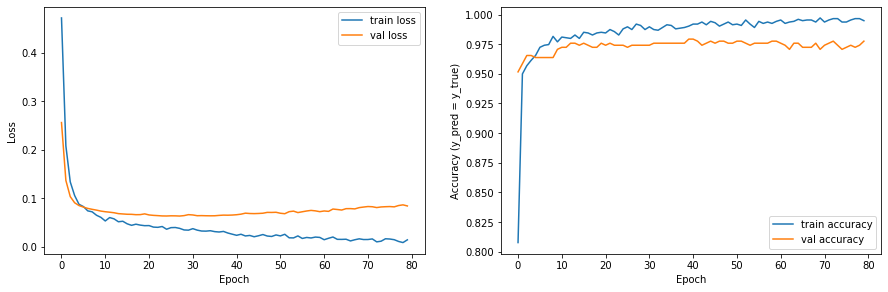

In [41]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

# plot accuracy vs epoch
axes = plt.subplot(2, 2, 2)
axes.plot(history.history['accuracy'], label = 'train accuracy')
axes.plot(history.history['val_accuracy'], label = 'val accuracy')
axes.legend(loc = "lower right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Accuracy (y_pred = y_true)')

## Partition the test set into sig/bkg sets

In [42]:
# count sig/bkg examples in the test set
test_sig_number = np.count_nonzero(Y_test)
test_bkg_number = np.count_nonzero(Y_test == 0)

X_test_sig = np.zeros((test_sig_number,X_test.shape[1]))
X_test_bkg = np.zeros((test_bkg_number,X_test.shape[1]))

j = 0
k = 0
for i in range(Y_test.shape[0]):
    if Y_test[i,0] == 1:
        X_test_sig[j,:] = X_test[i,:]
        j = j + 1
    else:
        X_test_bkg[k,:] = X_test[i,:]
        k = k + 1

## Test set performance plots

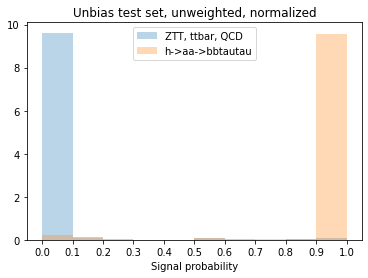

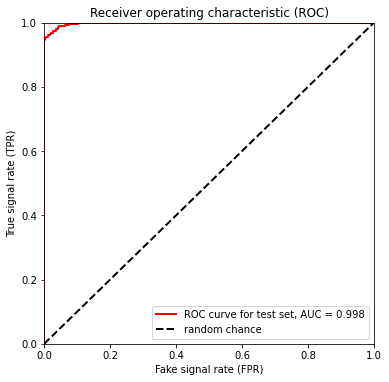

Test loss, test accuracy: [0.08920072604869975, 0.9741379022598267]


In [43]:
pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'ZTT, ttbar, QCD')
pyplot.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.legend(loc = 'upper center')
pyplot.title('Unbias test set, unweighted, normalized')
pyplot.xlabel('Signal probability')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.show()

# Plot ROC
plt.figure(figsize = (13,13))
Y_predict = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
axes = plt.subplot(2, 2, 1)
axes.plot(fpr, tpr, lw = 2, color = 'red', label = 'ROC curve for test set, AUC = %.3f' % (roc_auc))
axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
axes.set_xlabel('Fake signal rate (FPR)')
axes.set_ylabel('True signal rate (TPR)')
axes.set_title('Receiver operating characteristic (ROC)')
axes.legend(loc = "lower right")
plt.show()

results = model.evaluate(X_test, Y_test, verbose = 0, batch_size = 256)
print("Test loss, test accuracy:", results)

## Prediction on the observed data set

In [ ]:
pyplot.hist(model.predict(X_obs), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'Observed data')
#pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 10, alpha = 1.0, label = 'ZTT, ttbar, QCD (MC test set)', histtype = 'step')
#pyplot.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 10, alpha = 1.0, label = 'h->aa->bbtautau (MC test set)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Model prediction on observed data set, normalized')
pyplot.xlabel('Predicted probability of being a signal event')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.show()

# Write model prediction to root files

## Load all root files one by one

In [44]:
from root_numpy import array2root

infolder = 'root_raw/et18_raw/'
outfolder = 'root_outputs/et18_outputs/'

inpaths = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths)):
    inpaths[i] = infolder + inpaths[i]
    outpaths[i] = outfolder + outpaths[i]

allfiles = []
for i in range(len(inpaths)):
    allfiles.append(ROOT.RDataFrame('etau_tree', inpaths[i]))


for i in range(len(allfiles)):
    allfiles[i] = allfiles[i].Define('myele', myele)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1e', m_b1e)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2e', m_b2e)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbe', m_bbe)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1e', dR_b1e)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2e', dR_b2e)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbe', dR_bbe)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_e', mT_e)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('mT_tt', mT_tt)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)
    
print(len(allfiles))

46


## Data pre-processing

In [45]:
for i in range(len(allfiles)):
    allfiles[i] = pd.DataFrame(allfiles[i].AsNumpy(feature_list))
    allfiles[i] = allfiles[i].values
    allfiles[i] = scaler.transform(allfiles[i])
    print(inpaths[i])

root_raw/et18_raw/DY.root
root_raw/et18_raw/DY1.root
root_raw/et18_raw/DY2.root
root_raw/et18_raw/DY3.root
root_raw/et18_raw/DY4.root
root_raw/et18_raw/GGHTT.root
root_raw/et18_raw/GGHWW.root
root_raw/et18_raw/GGZHLLTT.root
root_raw/et18_raw/GGZHNNTT.root
root_raw/et18_raw/GGZHQQTT.root
root_raw/et18_raw/GGZHWW.root
root_raw/et18_raw/ST_tW_antitop.root
root_raw/et18_raw/ST_tW_top.root
root_raw/et18_raw/ST_t_antitop.root
root_raw/et18_raw/ST_t_top.root
root_raw/et18_raw/TTTo2L2Nu.root
root_raw/et18_raw/TTToHadronic.root
root_raw/et18_raw/TTToSemiLeptonic.root
root_raw/et18_raw/VBFHTT.root
root_raw/et18_raw/VBFHWW.root
root_raw/et18_raw/VV2L2Nu.root
root_raw/et18_raw/WZ2L2Q.root
root_raw/et18_raw/WZ3LNu.root
root_raw/et18_raw/WminusHTT.root
root_raw/et18_raw/WminusHWW.root
root_raw/et18_raw/WplusHTT.root
root_raw/et18_raw/WplusHWW.root
root_raw/et18_raw/ZHTT.root
root_raw/et18_raw/ZHWW.root
root_raw/et18_raw/ZZ2L2Q.root
root_raw/et18_raw/ZZ4L.root
root_raw/et18_raw/data_obs.root
root_raw

## Feed to NN and write outputs to root files

In [46]:
for i in range(len(allfiles)):
    y_pred = model.predict(allfiles[i])
    y_pred = np.array(y_pred, dtype = [('pred_2b', np.float32)])
    array2root(y_pred, filename = outpaths[i], treename = 'etau_tree_dnn', mode = 'update')
    print(outpaths[i])

root_outputs/et18_outputs/DY.root
root_outputs/et18_outputs/DY1.root
root_outputs/et18_outputs/DY2.root
root_outputs/et18_outputs/DY3.root
root_outputs/et18_outputs/DY4.root
root_outputs/et18_outputs/GGHTT.root
root_outputs/et18_outputs/GGHWW.root
root_outputs/et18_outputs/GGZHLLTT.root
root_outputs/et18_outputs/GGZHNNTT.root
root_outputs/et18_outputs/GGZHQQTT.root
root_outputs/et18_outputs/GGZHWW.root
root_outputs/et18_outputs/ST_tW_antitop.root
root_outputs/et18_outputs/ST_tW_top.root
root_outputs/et18_outputs/ST_t_antitop.root
root_outputs/et18_outputs/ST_t_top.root
root_outputs/et18_outputs/TTTo2L2Nu.root
root_outputs/et18_outputs/TTToHadronic.root
root_outputs/et18_outputs/TTToSemiLeptonic.root
root_outputs/et18_outputs/VBFHTT.root
root_outputs/et18_outputs/VBFHWW.root
root_outputs/et18_outputs/VV2L2Nu.root
root_outputs/et18_outputs/WZ2L2Q.root
root_outputs/et18_outputs/WZ3LNu.root
root_outputs/et18_outputs/WminusHTT.root
root_outputs/et18_outputs/WminusHWW.root
root_outputs/et18_